# SOM

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('../../scripts')
from selfsom import SimpleSOMMapper
import somtools
from TransitSOM_release import CreateSOM
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

---

## Stacking .npz files

In [2]:
def stack_npz_files(directory):
    
    """normalisation method: median, depth, depth and width"""
    
    files = os.listdir(directory)
    npz_files = [f for f in files if f.endswith('.npz')]
    if not npz_files:
        print("No .npz files found in the directory.")
        return None

    normalised_by_median = []
    normalised_by_depth = [] 
    ids = []
    
    for npz_file in npz_files:
        file_path = os.path.join(directory, npz_file)
        data = np.load(file_path)   
        normalised_lightcurve = (data['flux'])/np.median(data['flux'])

        median = np.median(data['flux'])
        #depth_normalised_lightcurve = (data['flux'] - median) / median
        abs_depth = median - np.min(data['flux'])  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = ((data['flux'] - median) / abs_depth + 1)
        #elif normalisation_method == 'depth and width':
        #plt.scatter(data['time'],depth_normalised_lightcurve,s=5)
        #plt.show()

        obj_id = data['id']
        if len(normalised_lightcurve) == 241:
            normalised_by_median.append(normalised_lightcurve)
            normalised_by_depth.append(depth_normalised_lightcurve)
            ids.append(obj_id.item())


    stacked_median_lcs = np.vstack(normalised_by_median)
    stacked_depth_lcs = np.vstack(normalised_by_depth)
    stacked_ids = ids

    # Create a dictionary to map arrays to IDs
    id_map = {tuple(array): id for array, id in zip(stacked_median_lcs, stacked_ids)}
    print(len(ids))
    return stacked_median_lcs, stacked_depth_lcs, stacked_ids, id_map

In [3]:
som_array2, som_array, ids, id_map = stack_npz_files('../som_cutouts/')

22383


## Train SOM

In [4]:
# kshape = (15,15)
# niter  = 1000

# SOM = SimpleSOMMapper(kshape, niter)

# print('som is training')

# SOM.train(som_array)

# print('training ended')

# K = SOM.K


In [5]:
kshape = (5,5)

In [ ]:
trained_data = CreateSOM(som_array,somshape=kshape,niter=200)

## map the data onto a pixel
mapped = trained_data(som_array)
mapped_tuples = [tuple(point) for point in mapped]
## count how many are in that pixel
counts = Counter(mapped_tuples)
count_list = [counts[item] for item in mapped_tuples]

In [ ]:
trained_data

---
## Plot Kohonen layers

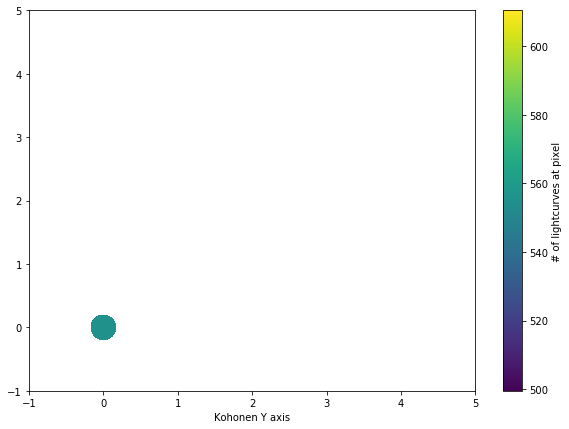

In [23]:
x_pos = mapped[:,0]
y_pos = mapped[:,1]
count_list = [counts[item] for item in mapped_tuples]
plt.figure(figsize=(10,7))
plt.xlim([-1,kshape[0]])
plt.ylim([-1,kshape[1]])
plt.xlabel('Kohonen X axis')
plt.xlabel('Kohonen Y axis')
plt.scatter(x_pos,y_pos,c=count_list,s=count_list)
plt.colorbar(label='# of lightcurves at pixel')
#plt.savefig('kohonen_layers.png')
plt.show()

### Plot average lightcurve in each pixel

In [24]:
def quick_K_pixel_plot_revisited(som,x_pixel,y_pixel,bins=np.arange(241),save=False):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(bins, som[x_pixel,y_pixel],c='g')
#    ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel,y_pixel))
    #plt.ylim([0,1])
    #plt.xlim([-2,66])
    #plt.text(0,0.92,'[{},{}]'.format(x_pixel,y_pixel))

In [25]:
array = trained_data.K

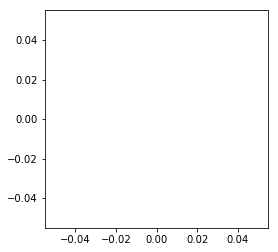

In [26]:
quick_K_pixel_plot_revisited(array,0,1)

In [27]:
def plot_all_arrays(som, bins=np.arange(241), save=True,save_path='kohonen_pixels.png'):
    """
    
    save_path = please remember to add the suffix (eg: .png)
    """
    fig, axes = plt.subplots(kshape[0],kshape[1], figsize=(50, 50),sharey=True)
    #fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height spacing between subplots

    for x_pixel in range(kshape[0]):
        for y_pixel in range(kshape[1]):
            ax = axes[x_pixel, y_pixel]
            ax.scatter(bins, som[x_pixel, y_pixel], c='g',s=3)
            ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel, y_pixel))
            #ax.text(0, 0.92, '[{},{}]'.format(x_pixel, y_pixel))
    
    if save:
        plt.savefig('{}'.format(save_path),dpi=200)  # Save the figure if save is True
    
    plt.show()

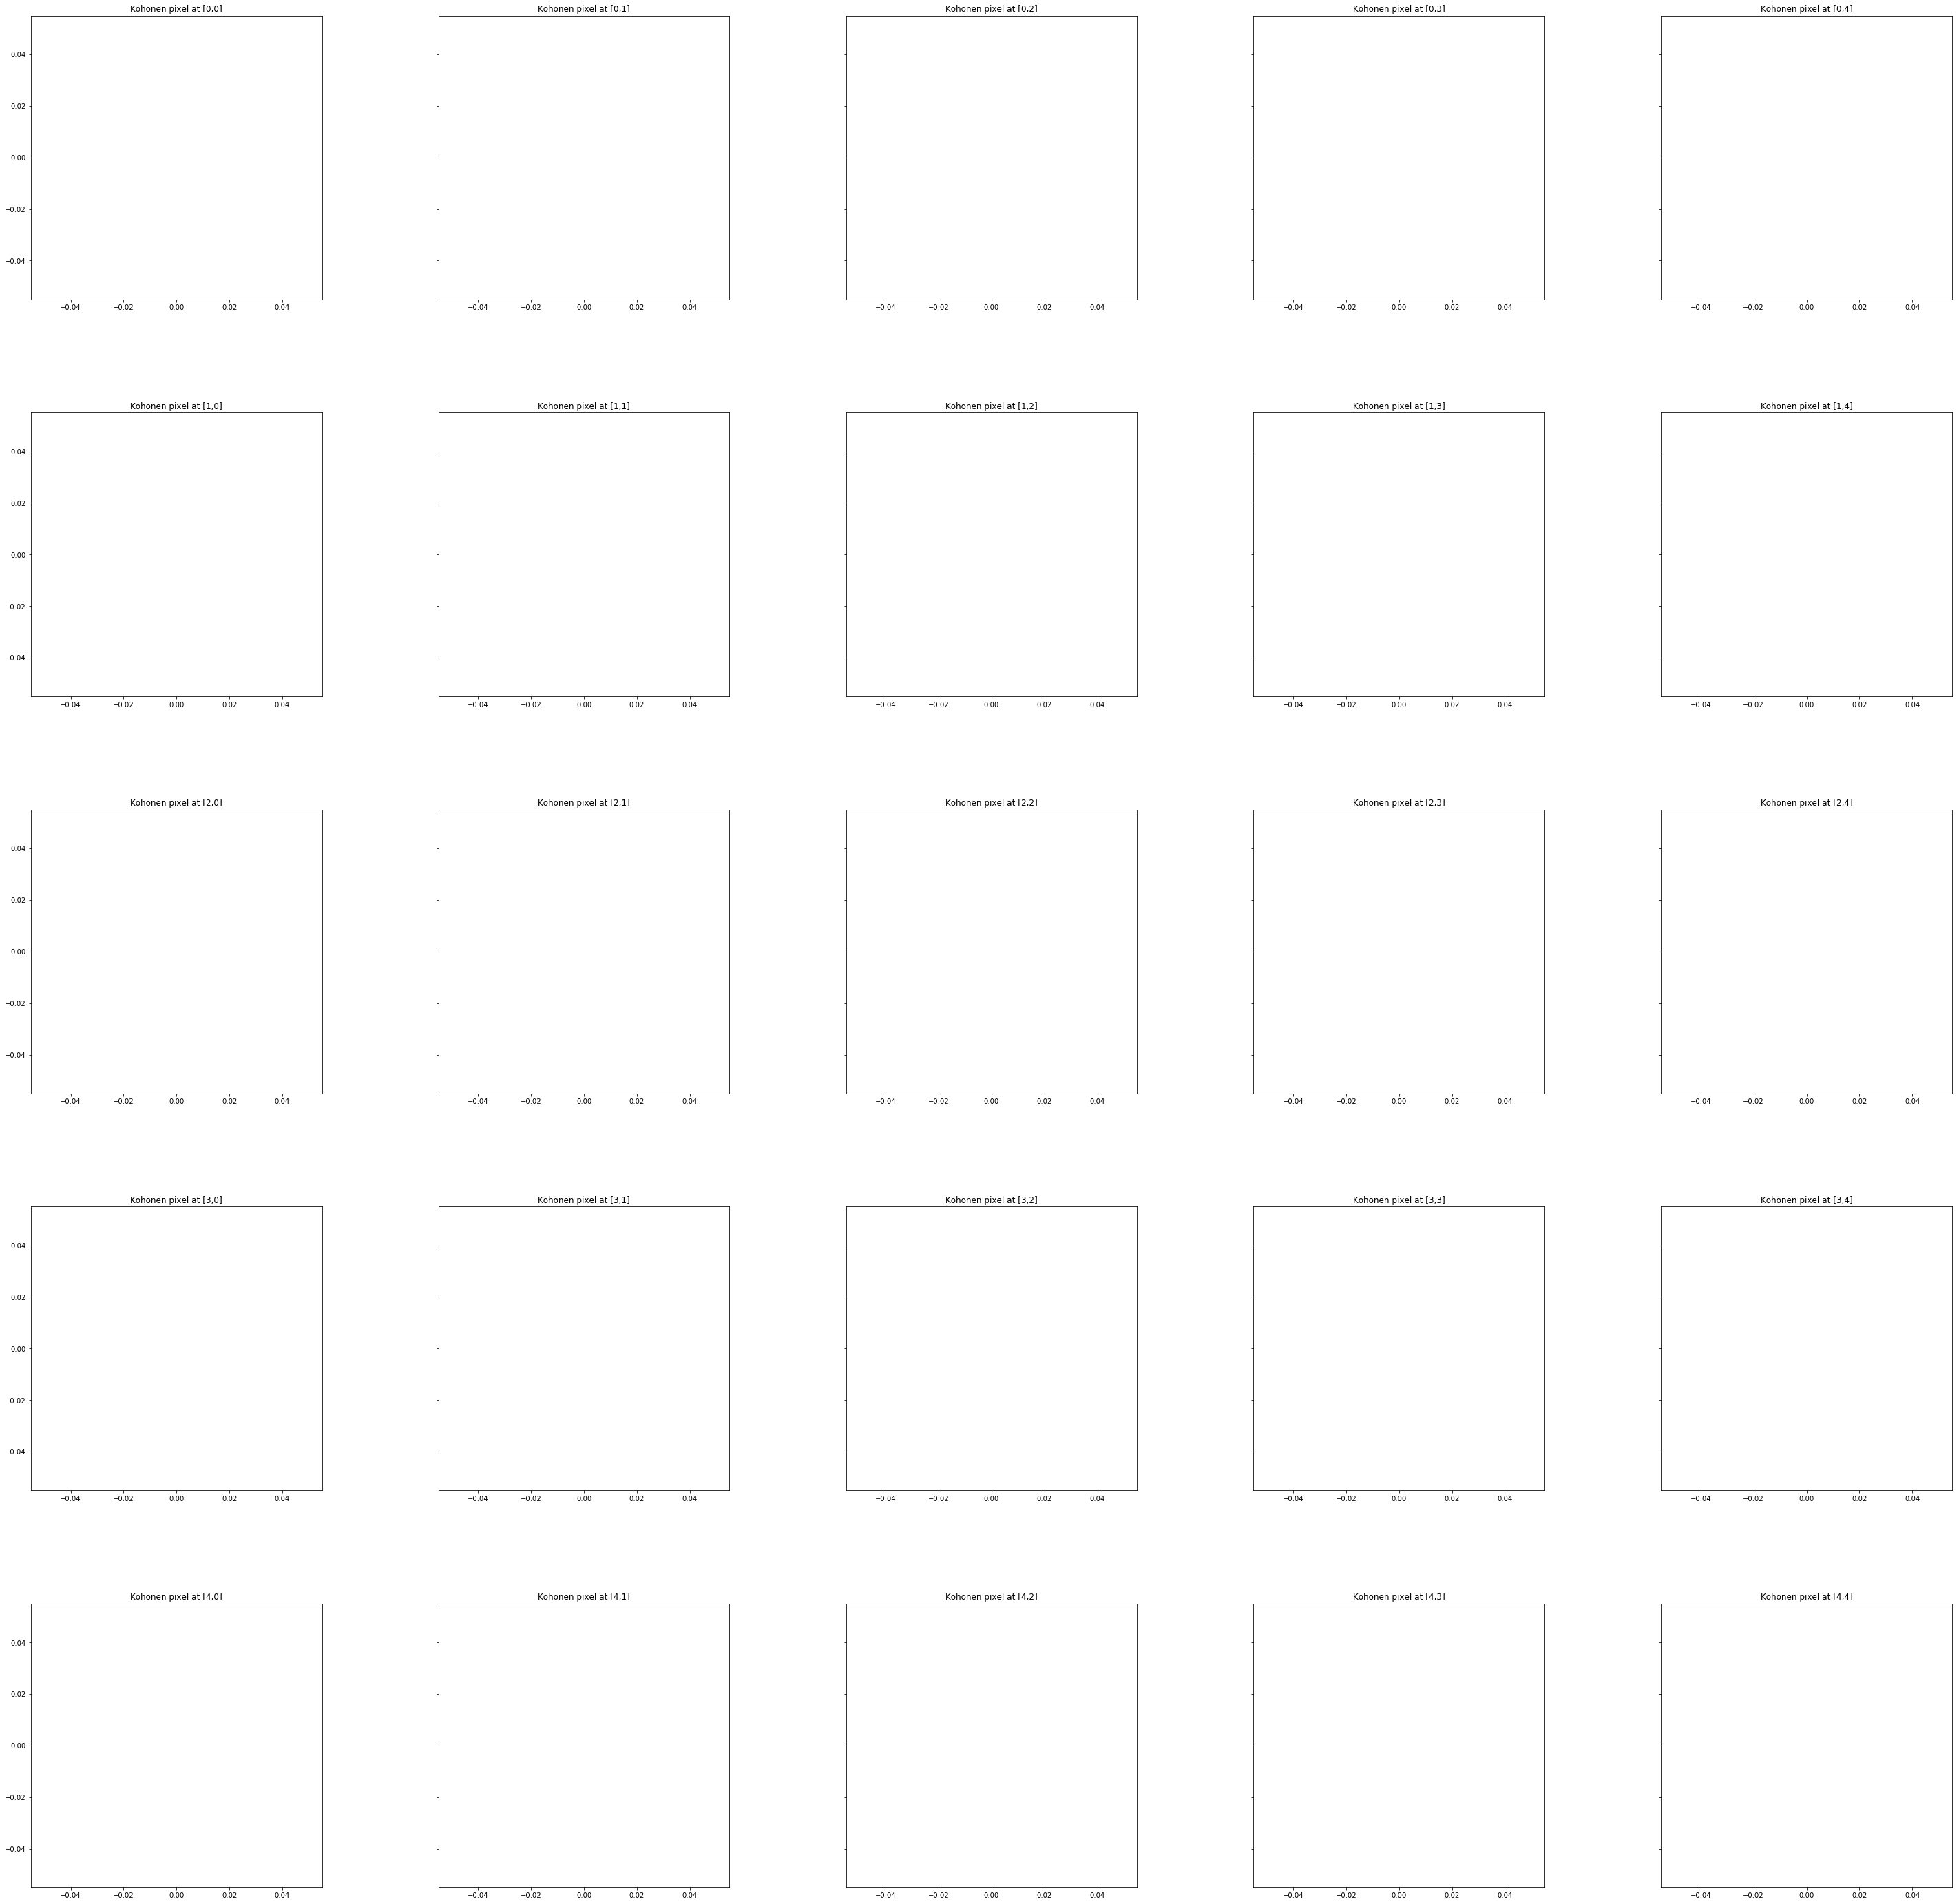

In [28]:
plot_all_arrays(array)

Transpose this

---
### What lightcurve ID's are underneath each pixel?

---

In [14]:
os.chdir('../')

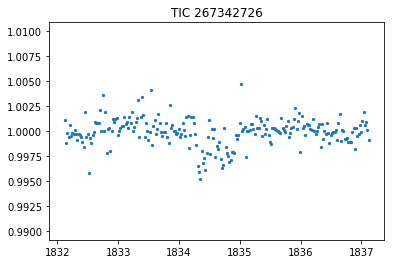

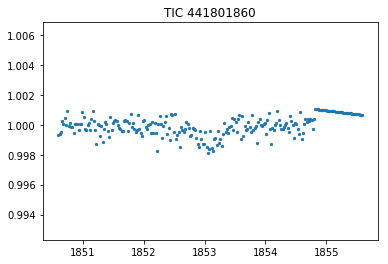

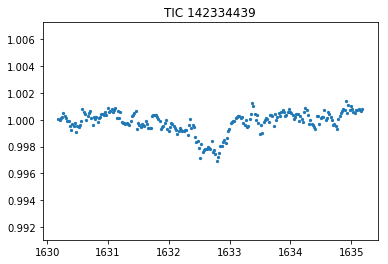

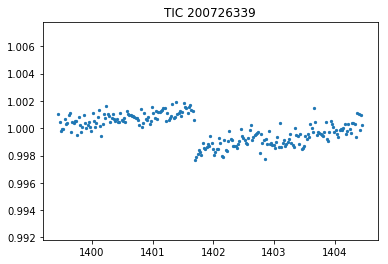

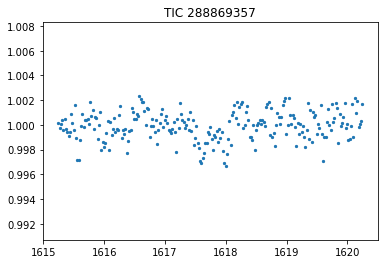

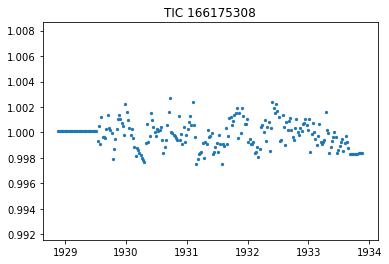

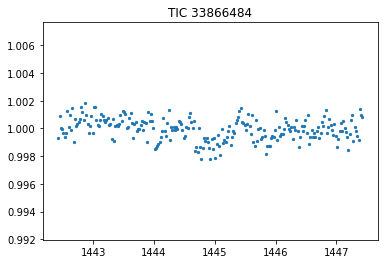

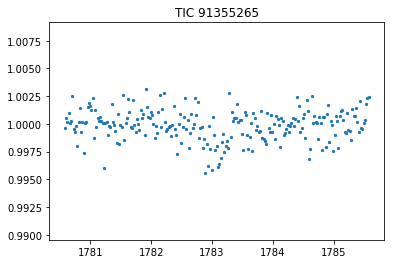

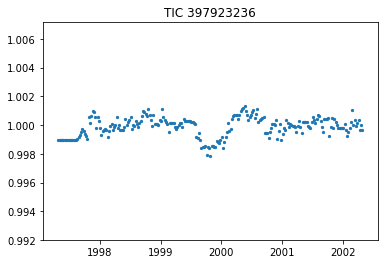

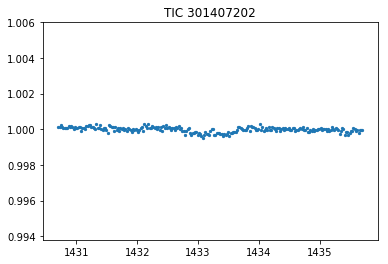

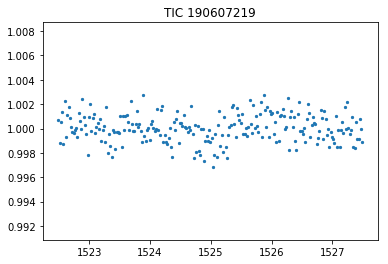

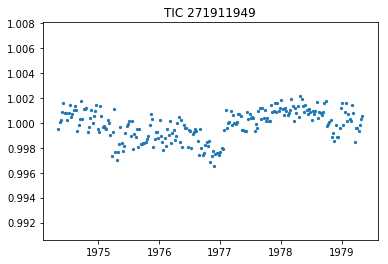

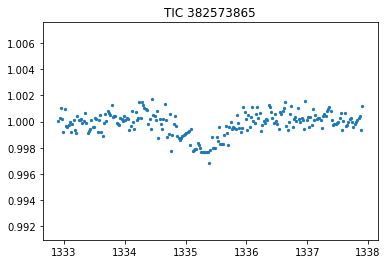

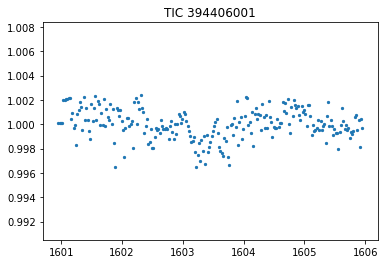

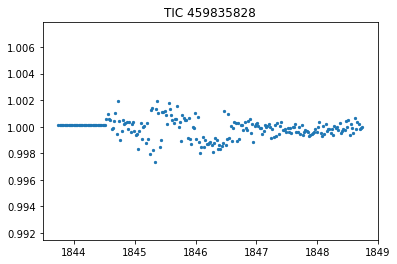

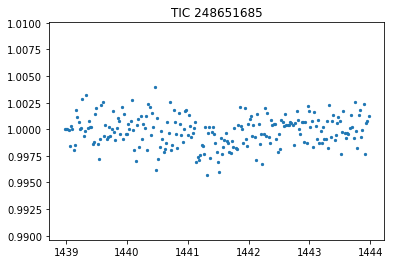

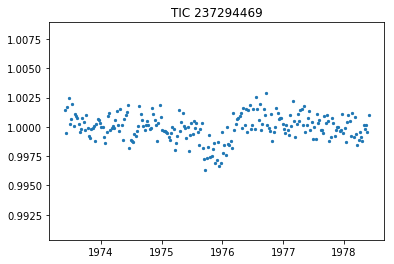

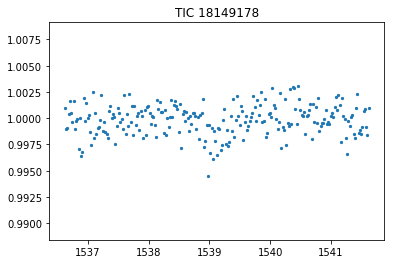

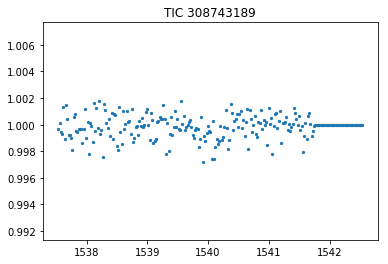

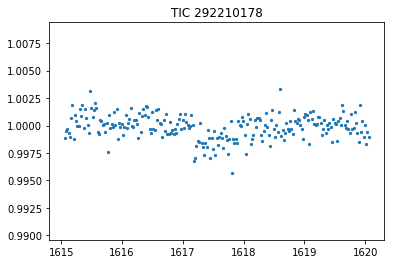

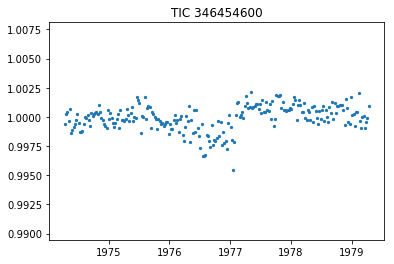

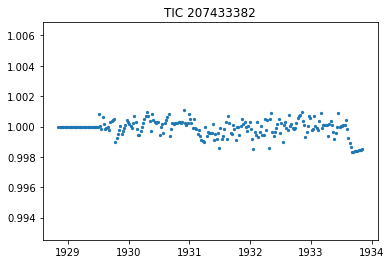

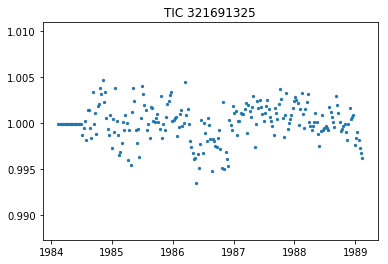

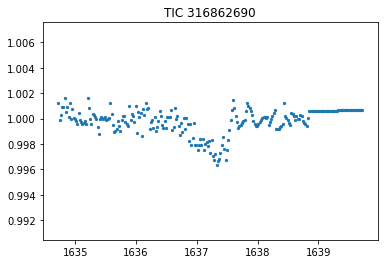

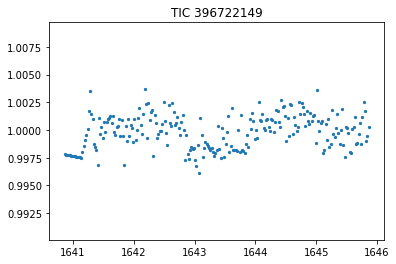

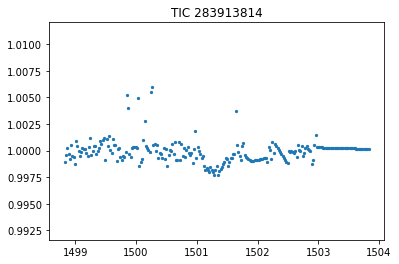

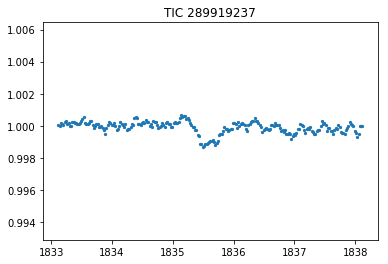

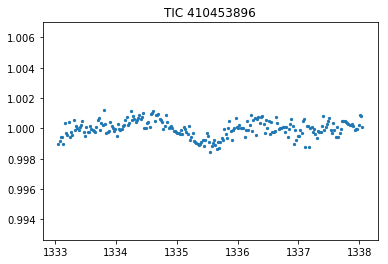

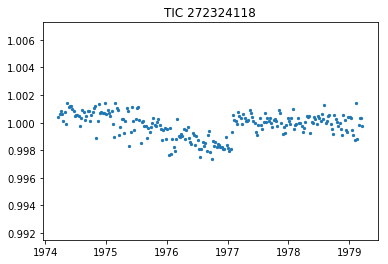

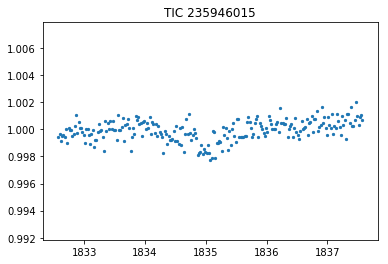

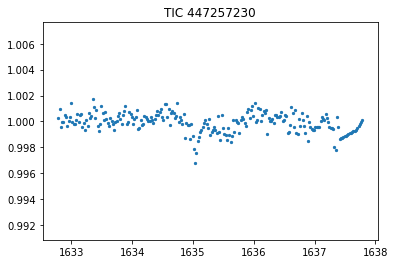

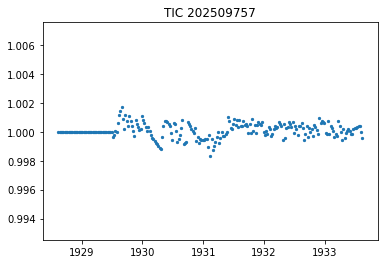

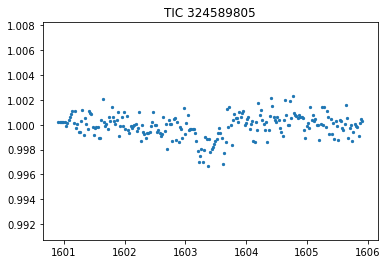

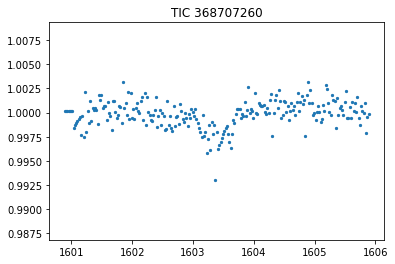

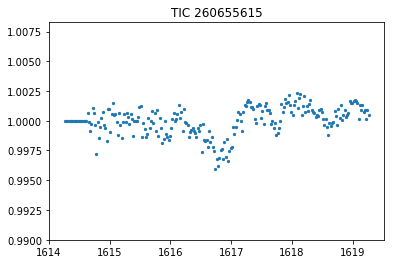

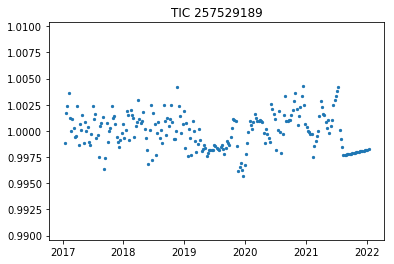

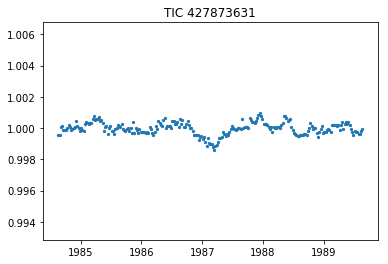

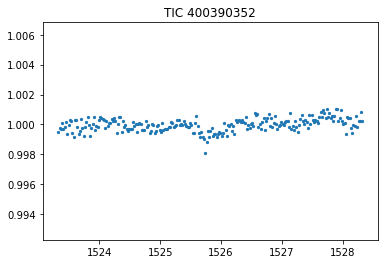

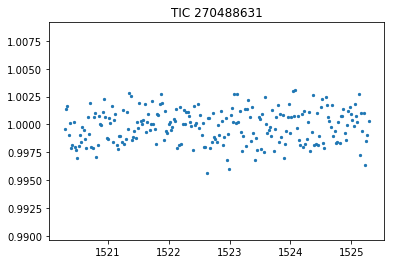

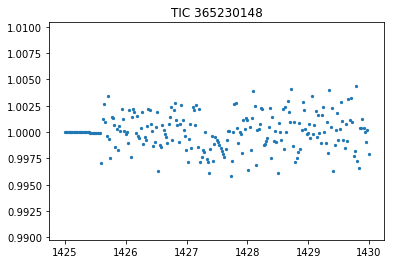

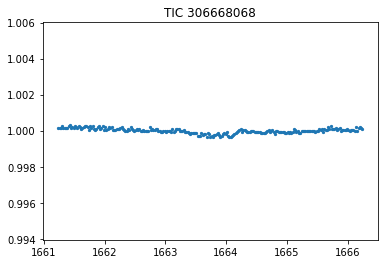

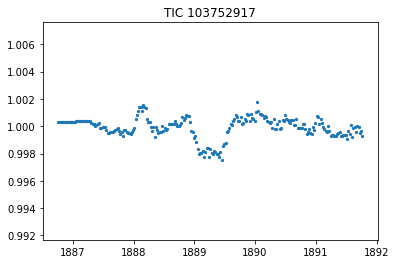

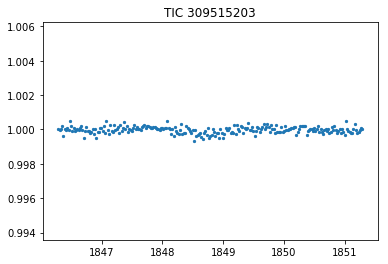

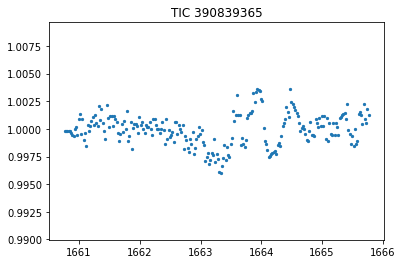

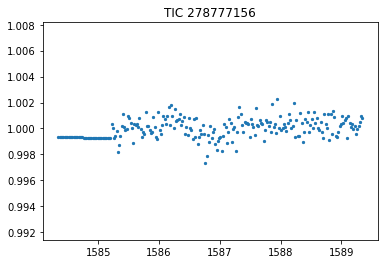

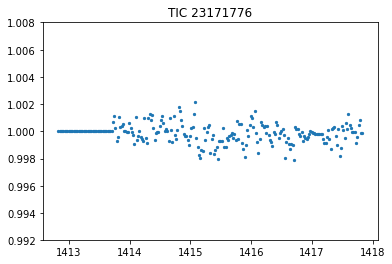

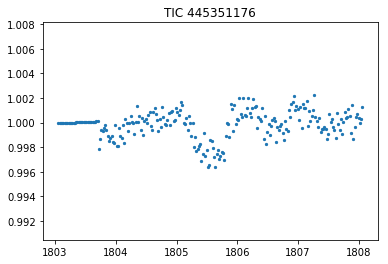

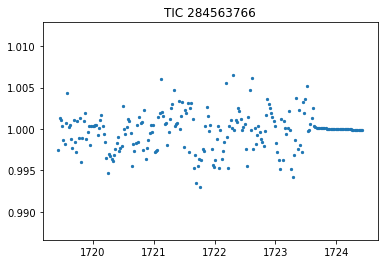

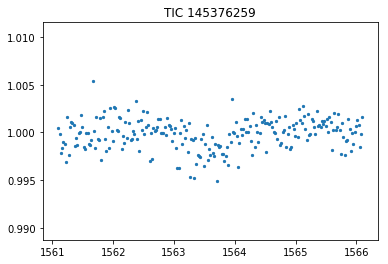

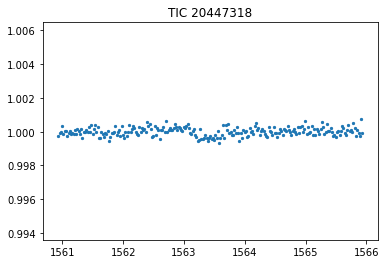

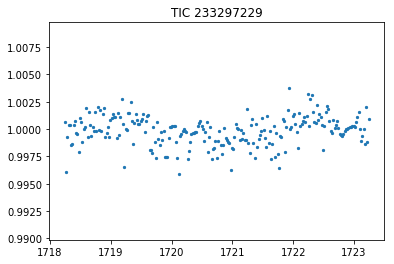

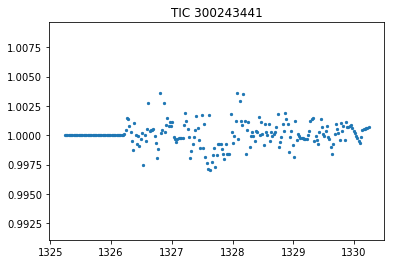

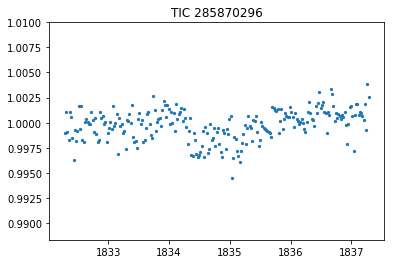

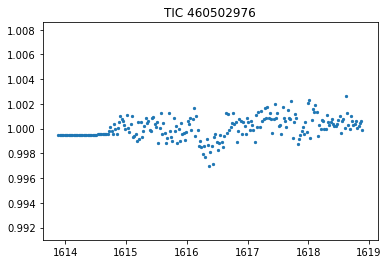

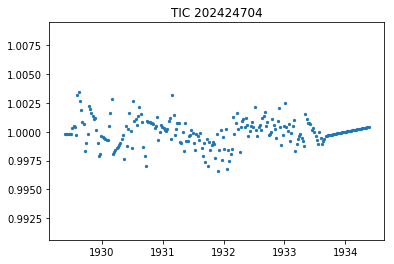

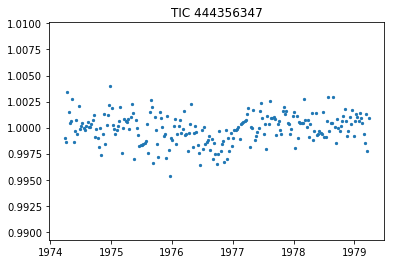

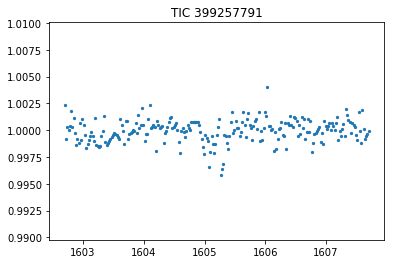

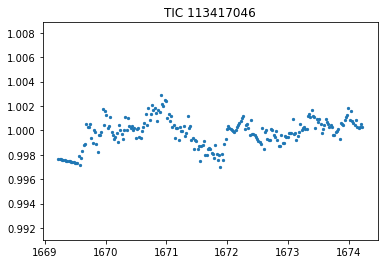

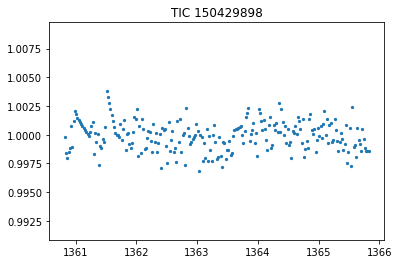

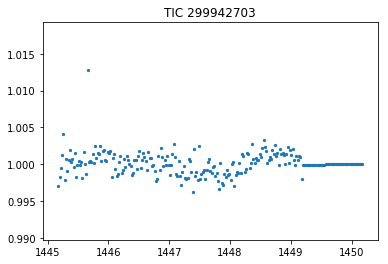

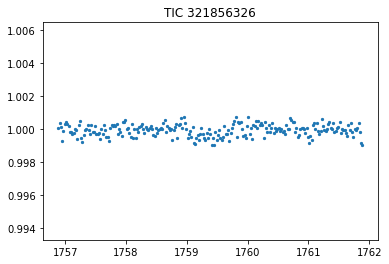

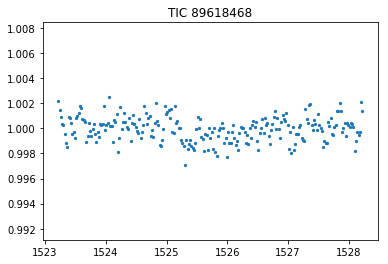

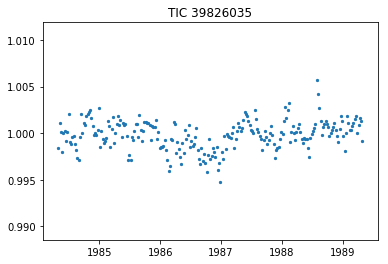

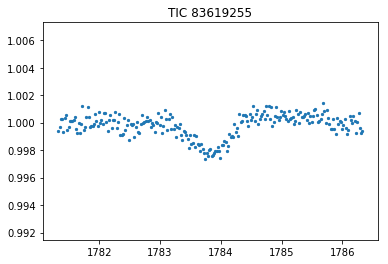

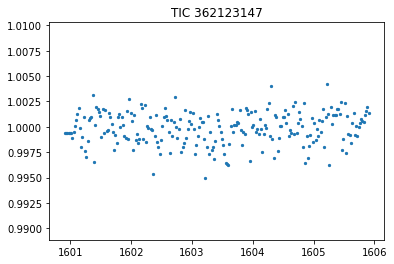

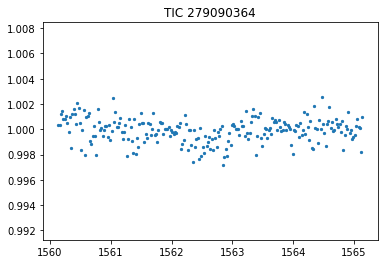

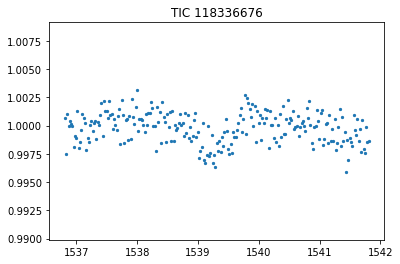

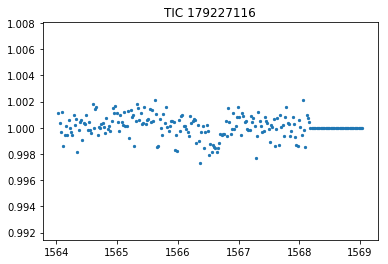

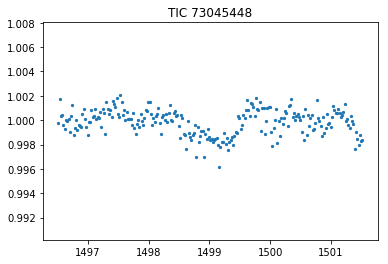

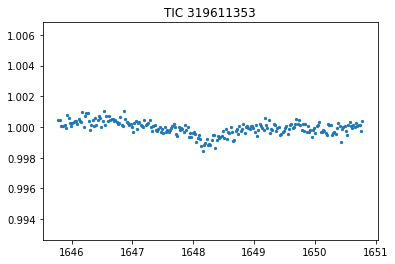

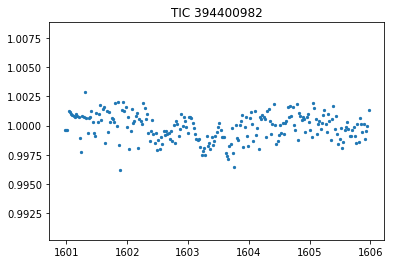

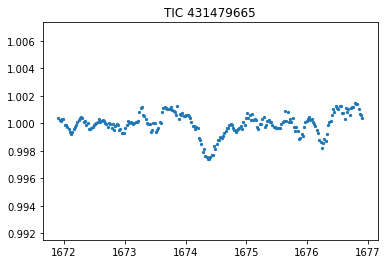

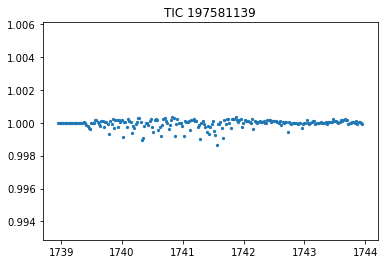

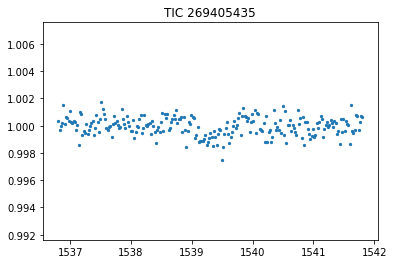

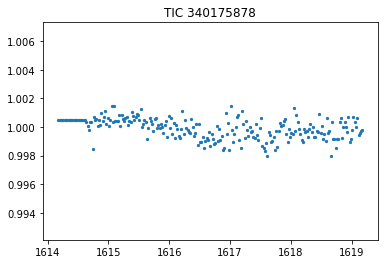

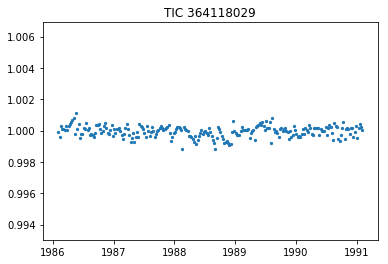

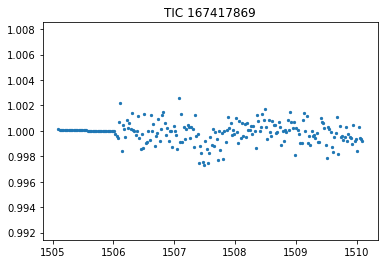

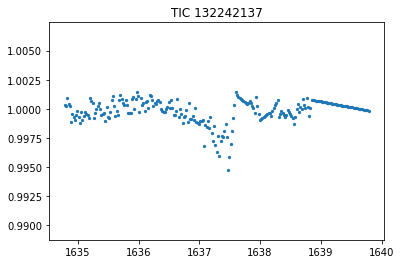

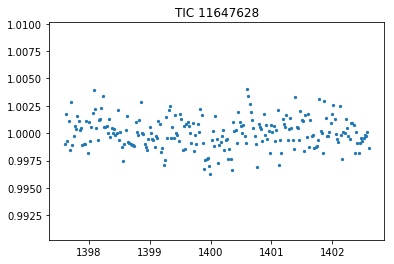

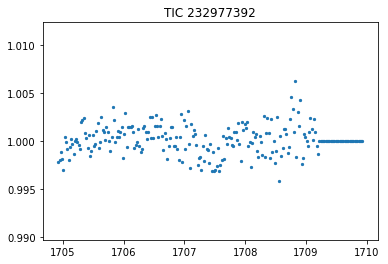

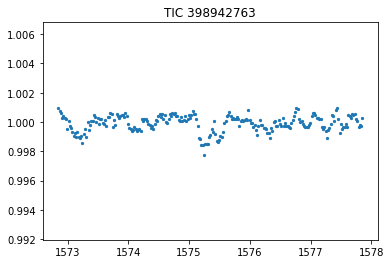

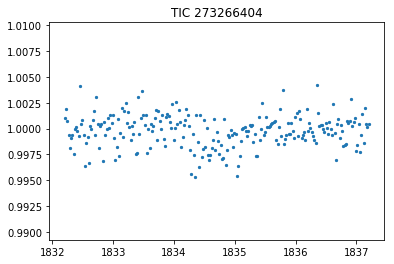

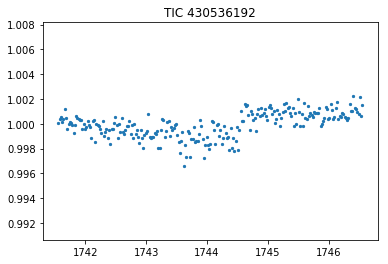

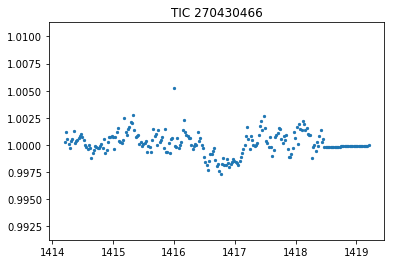

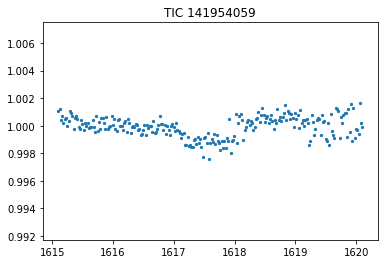

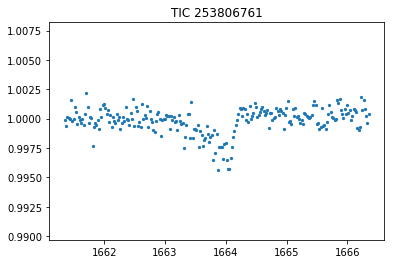

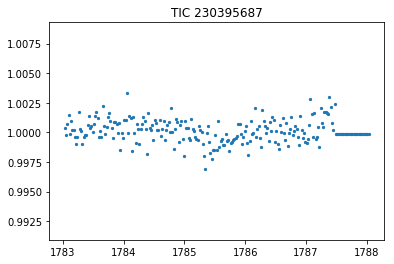

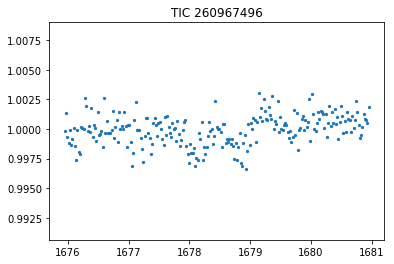

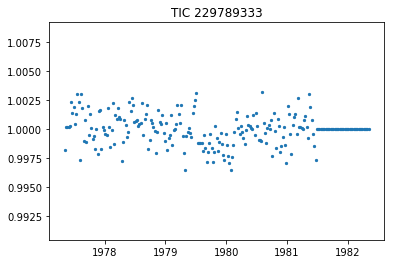

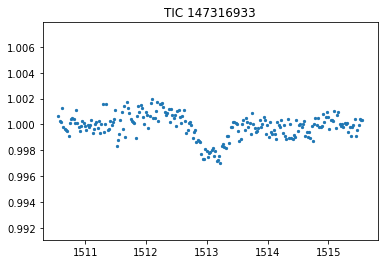

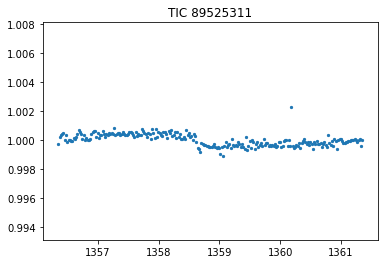

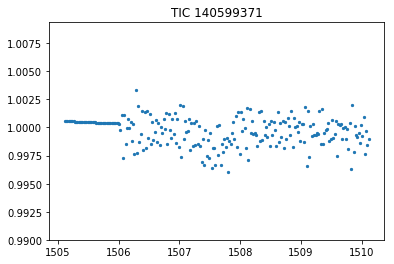

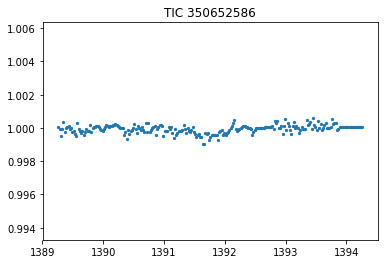

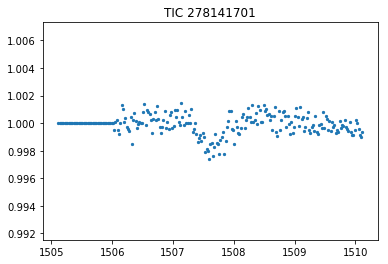

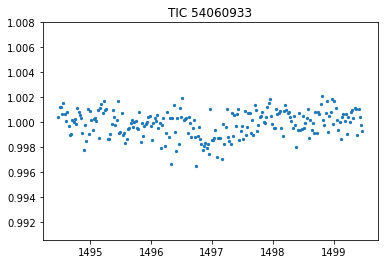

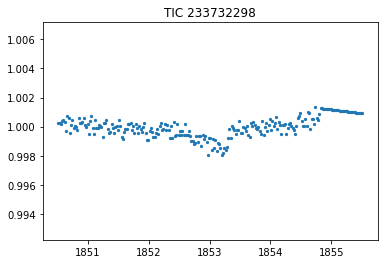

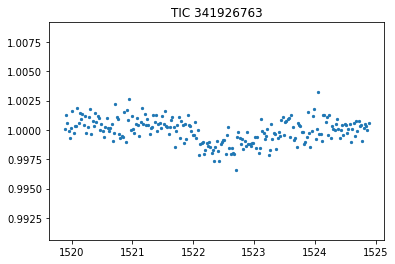

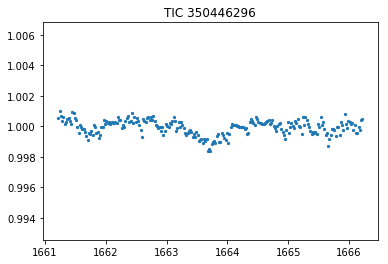

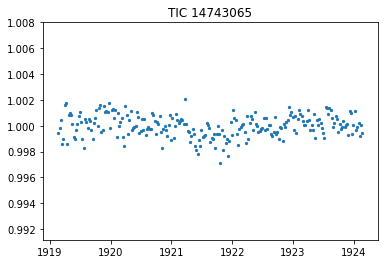

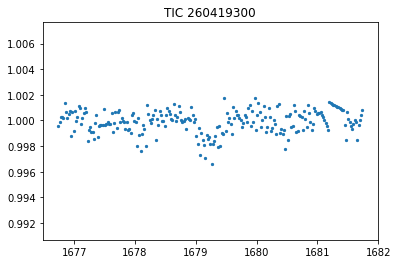

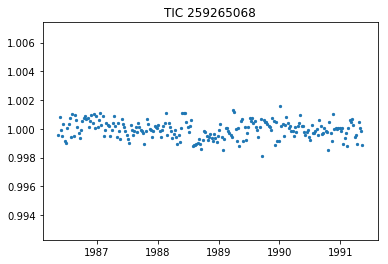

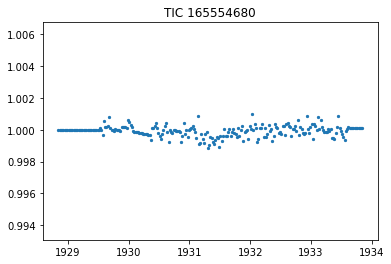

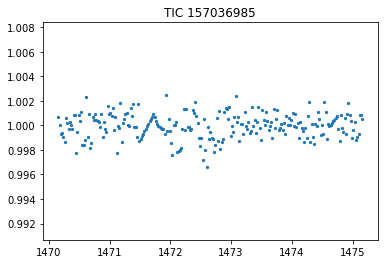

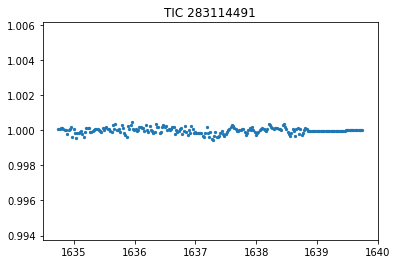

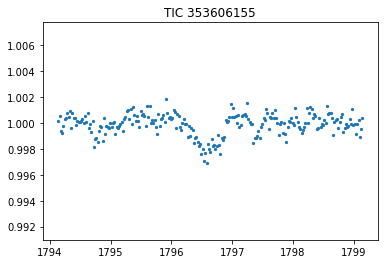

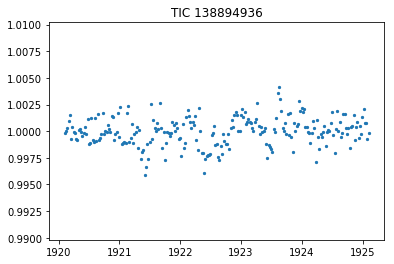

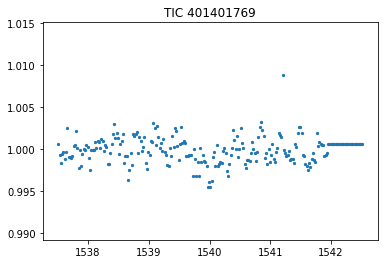

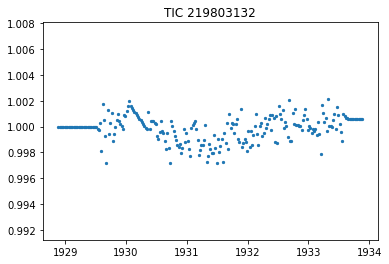

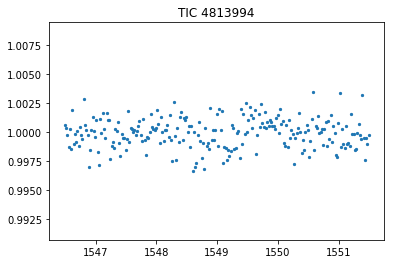

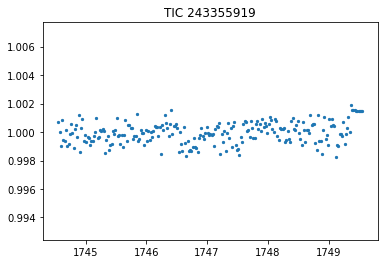

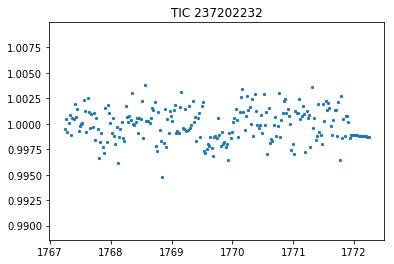

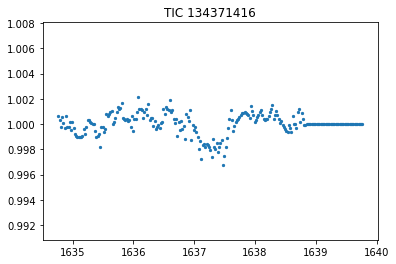

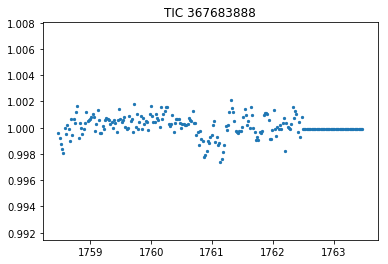

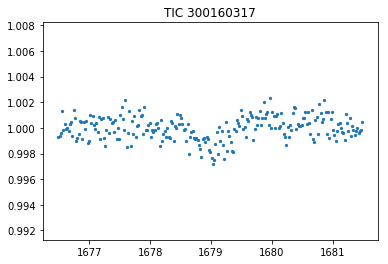

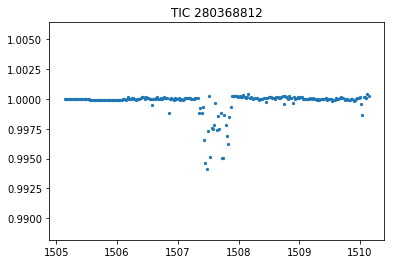

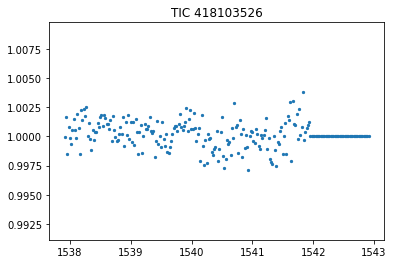

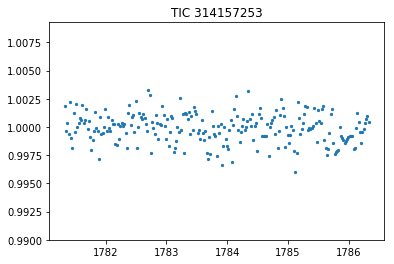

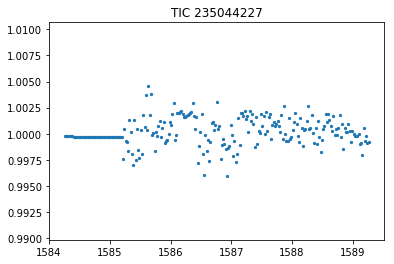

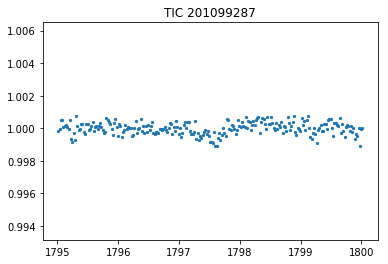

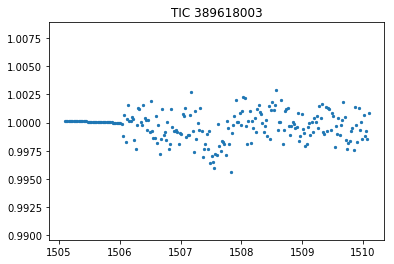

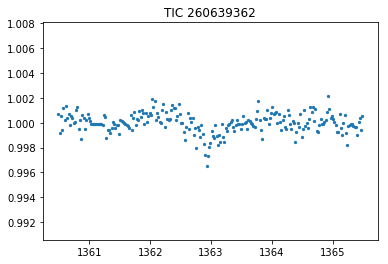

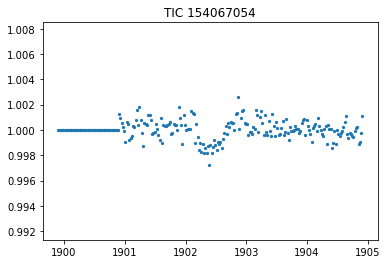

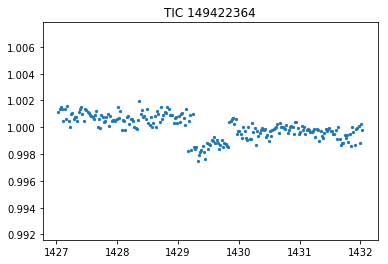

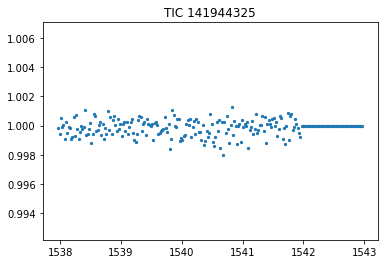

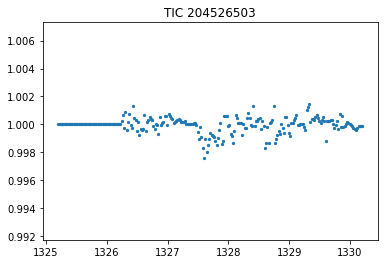

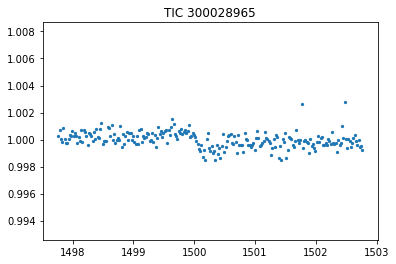

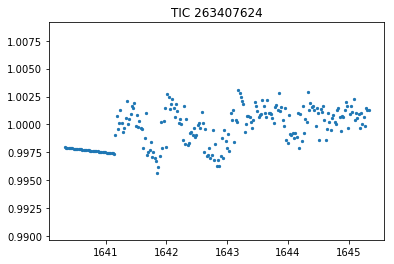

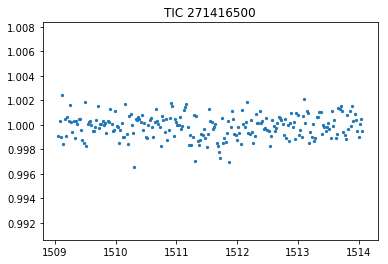

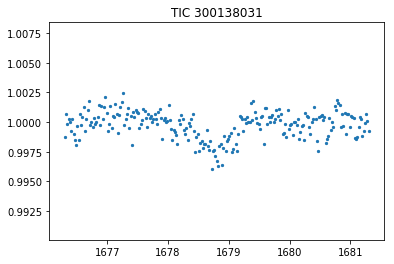

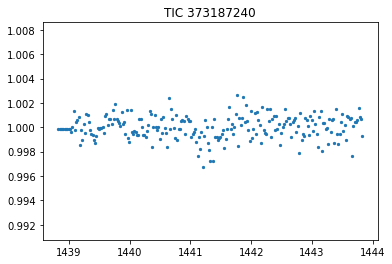

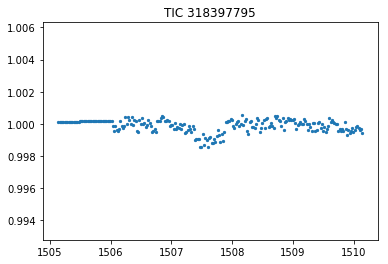

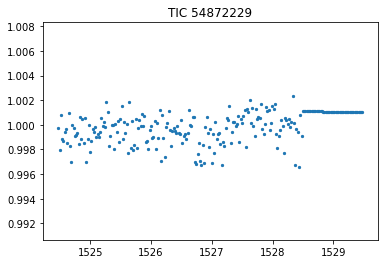

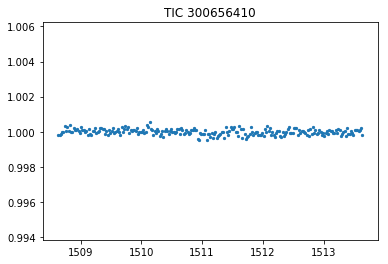

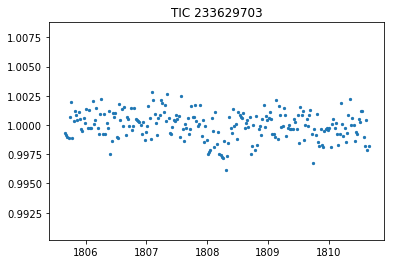

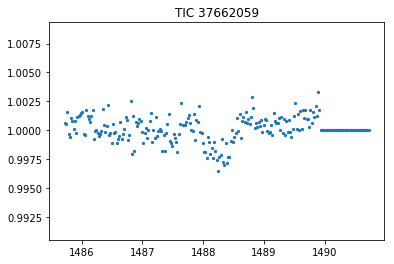

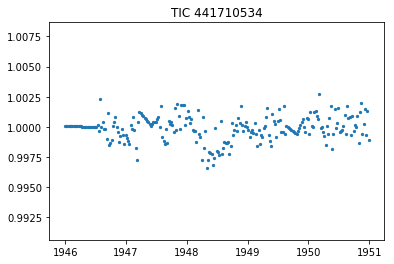

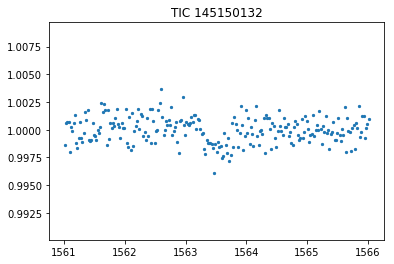

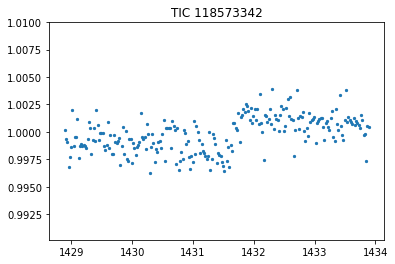

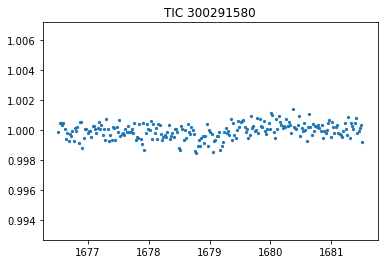

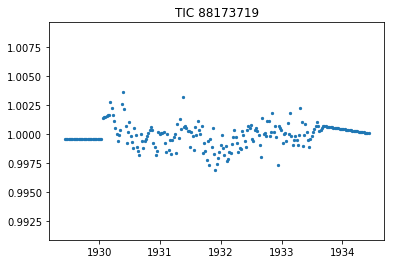

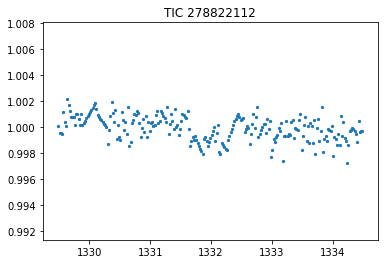

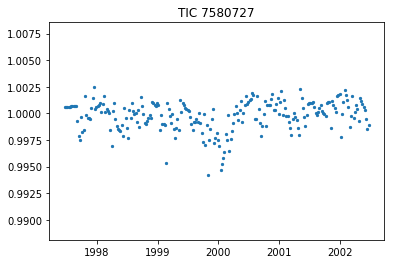

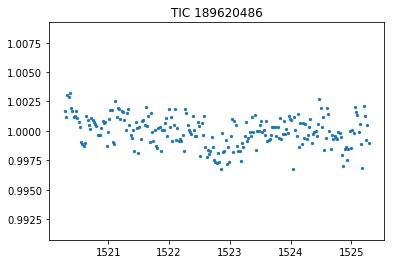

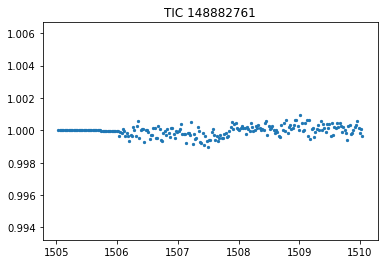

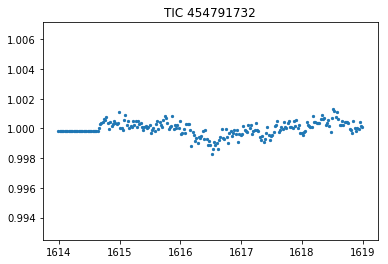

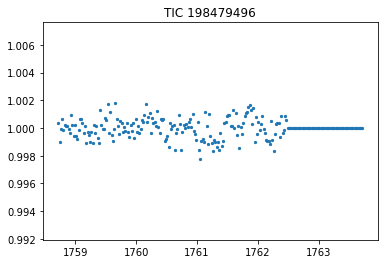

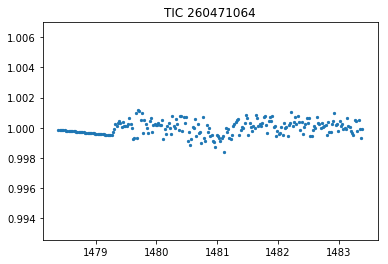

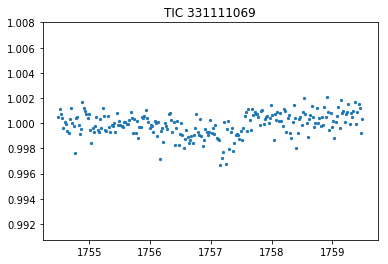

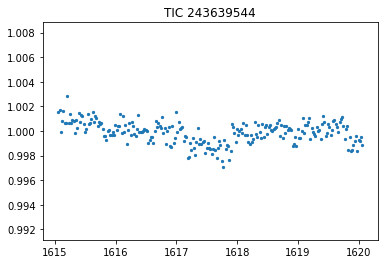

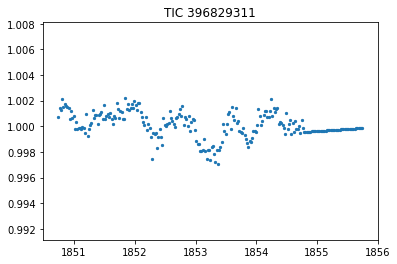

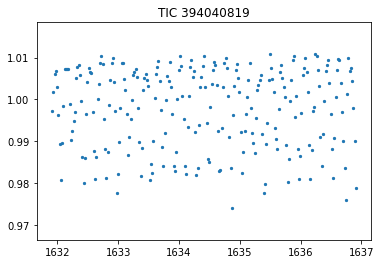

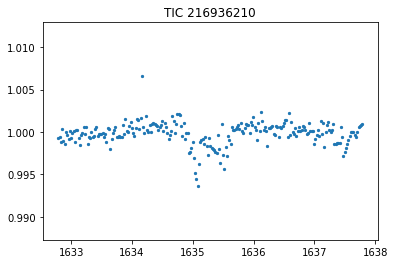

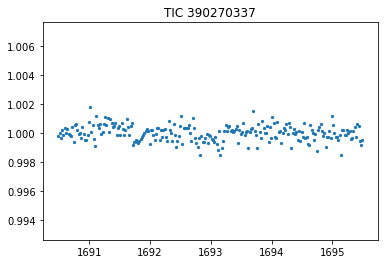

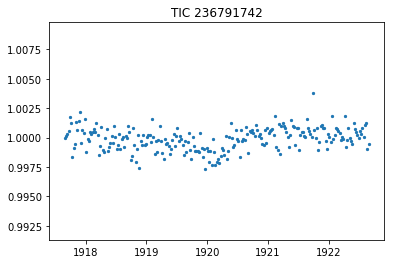

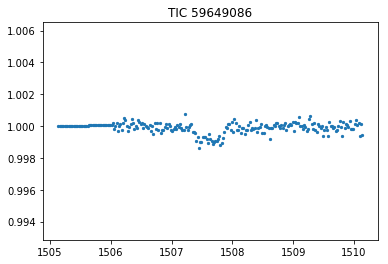

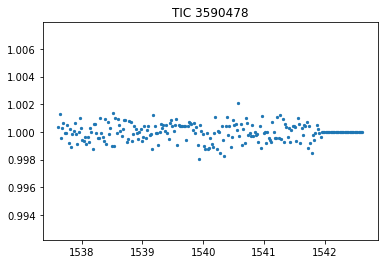

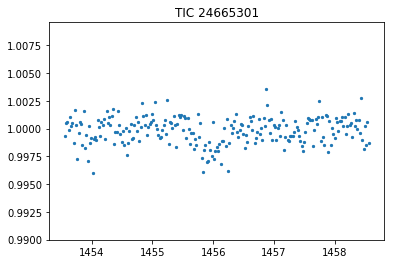

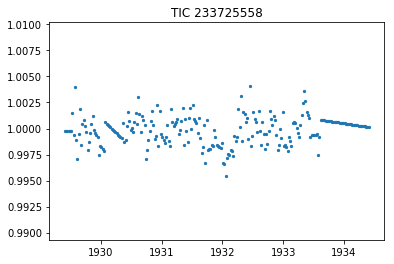

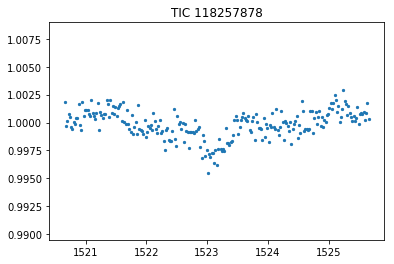

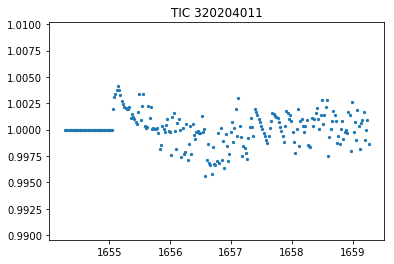

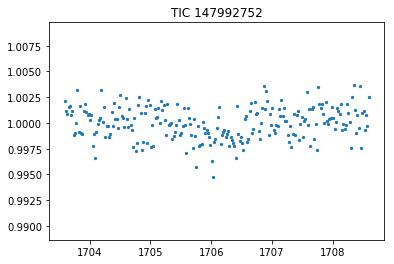

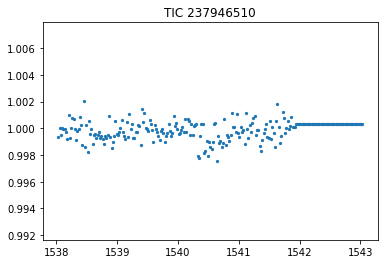

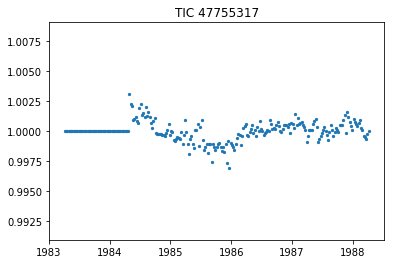

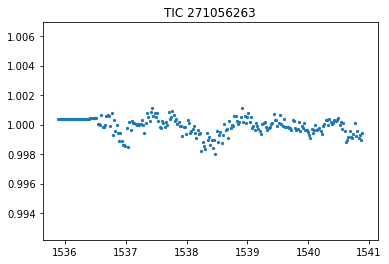

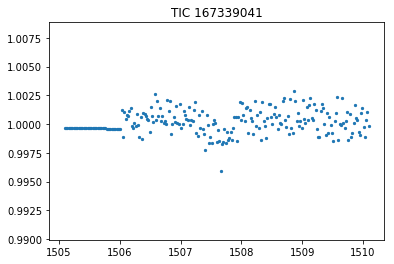

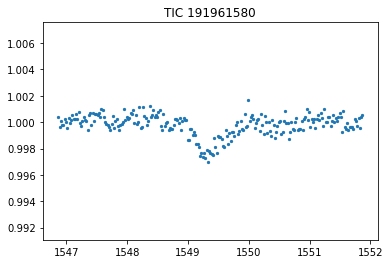

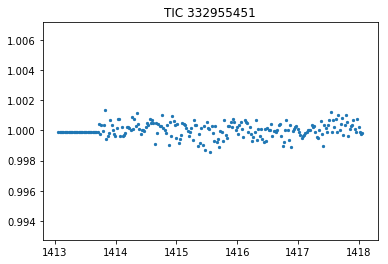

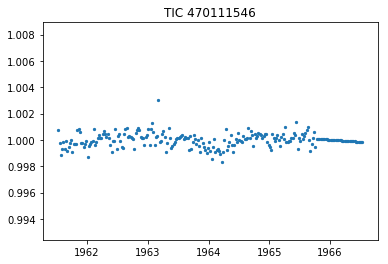

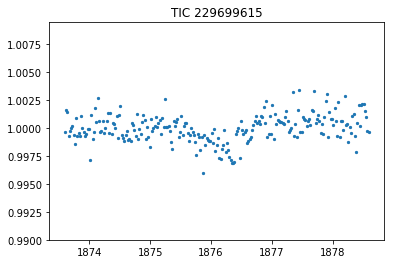

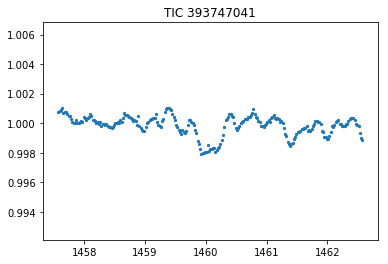

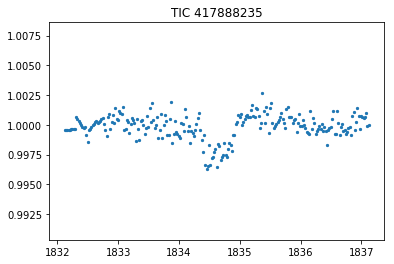

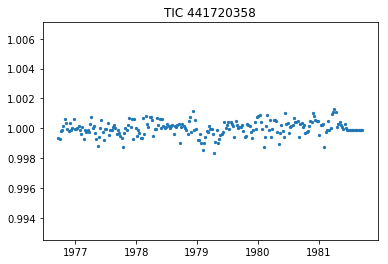

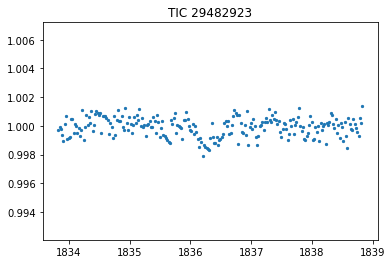

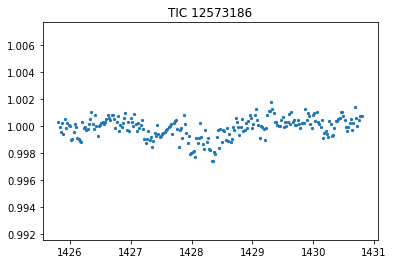

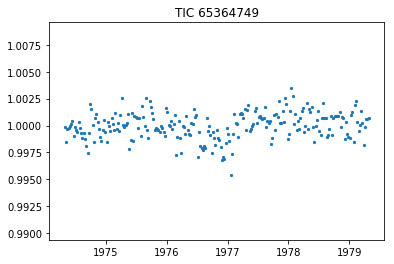

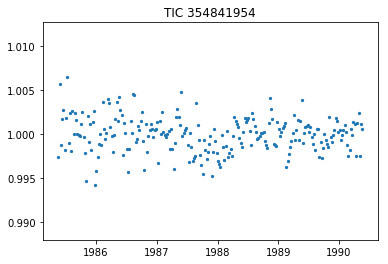

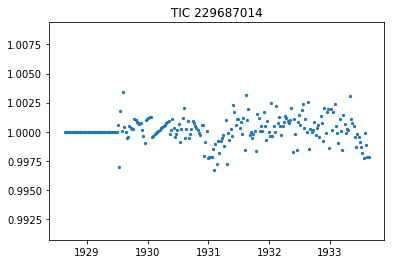

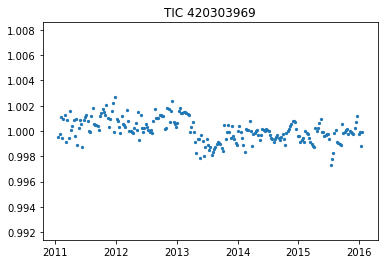

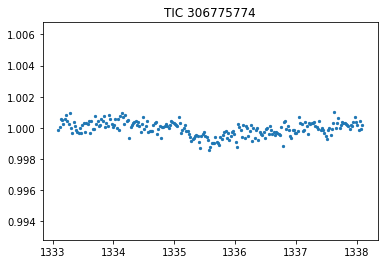

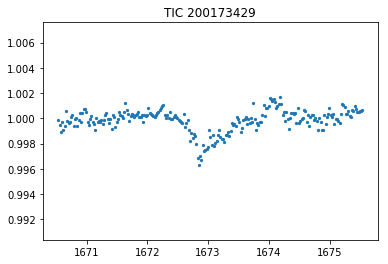

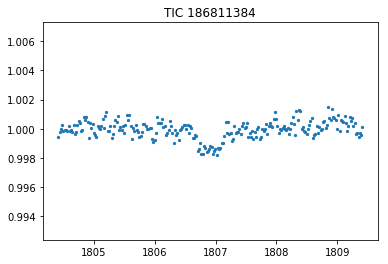

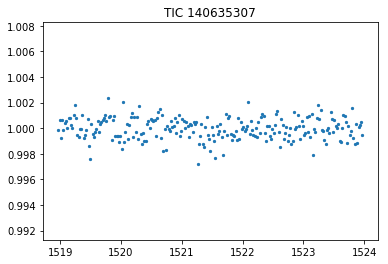

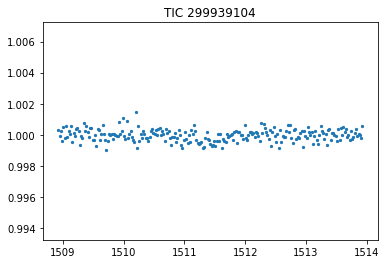

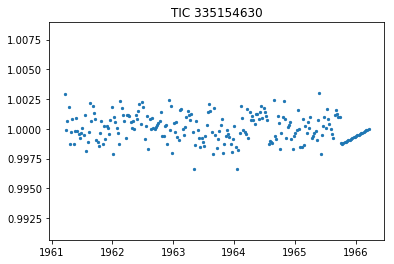

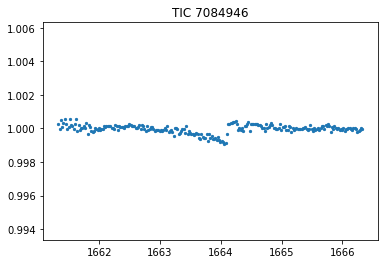

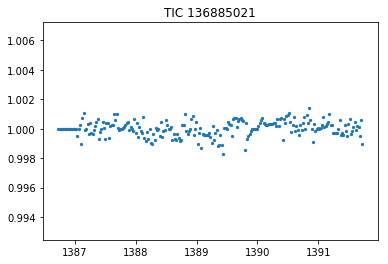

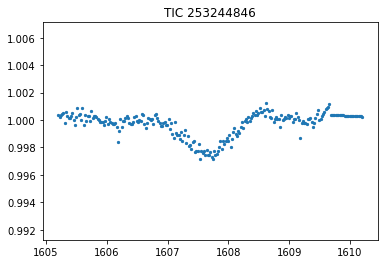

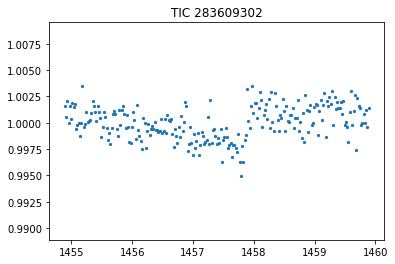

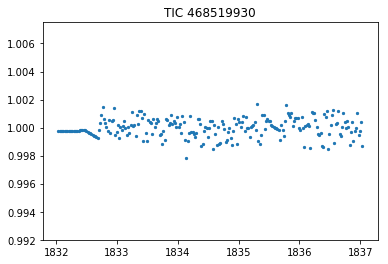

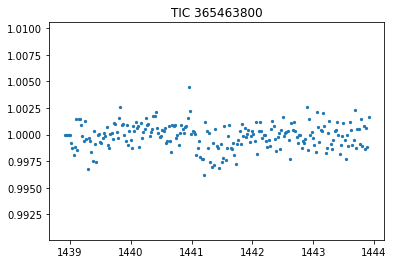

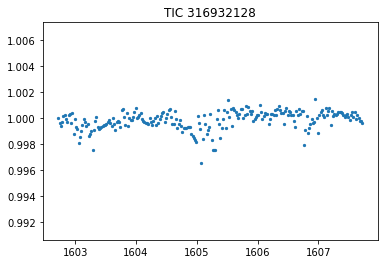

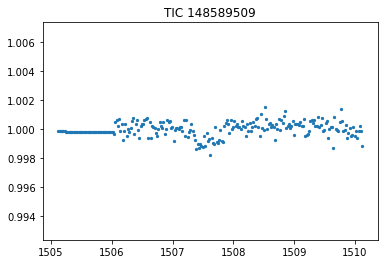

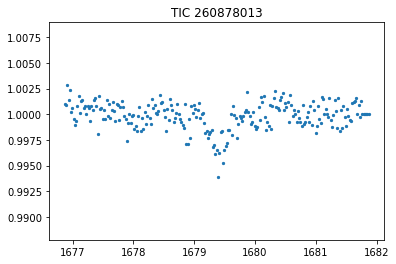

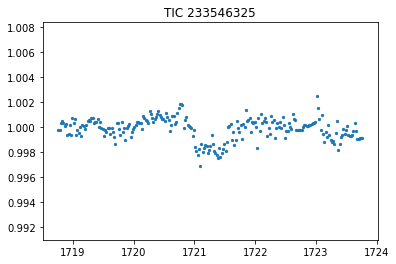

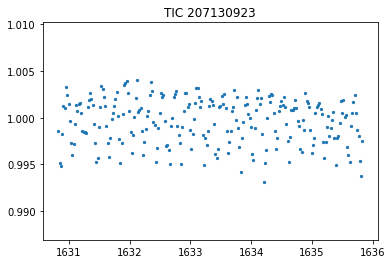

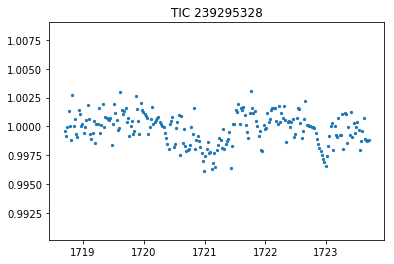

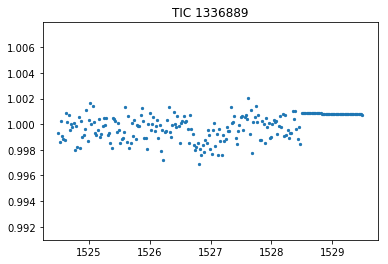

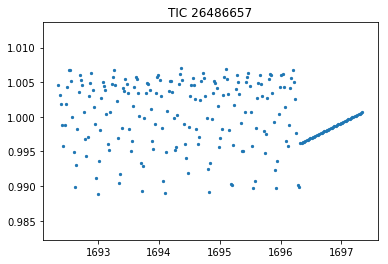

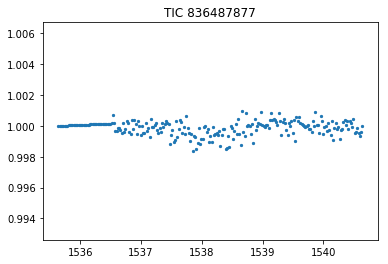

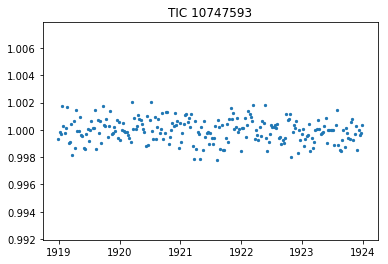

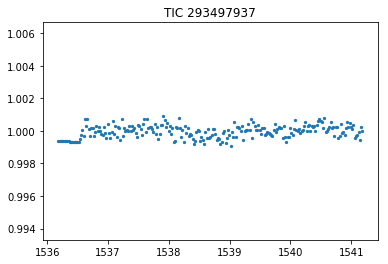

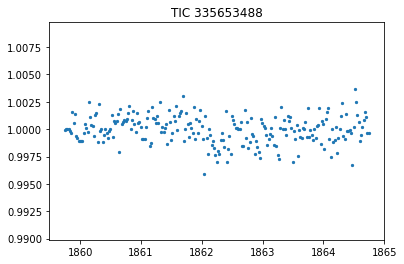

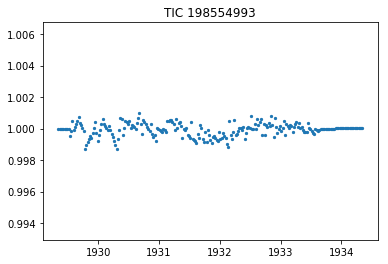

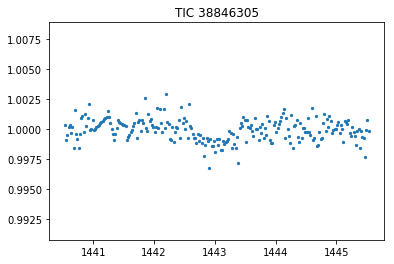

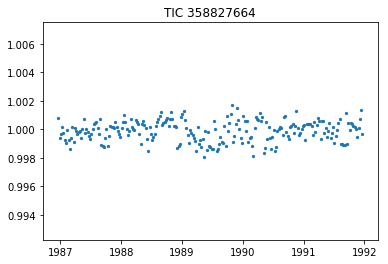

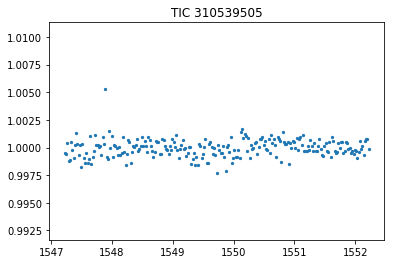

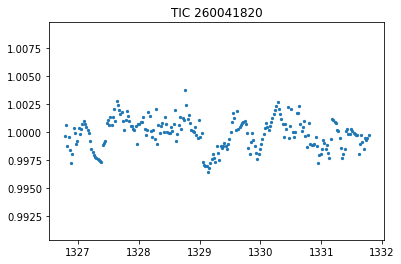

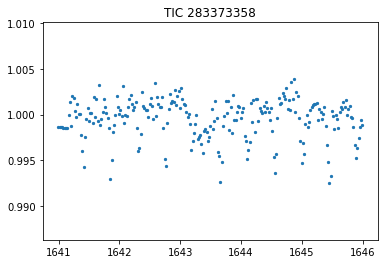

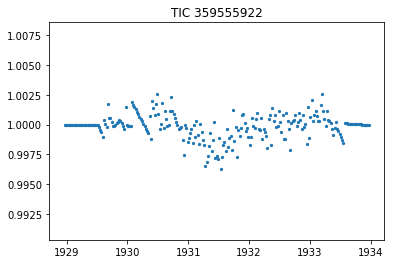

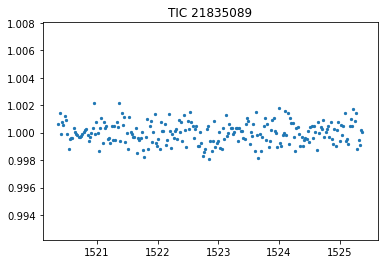

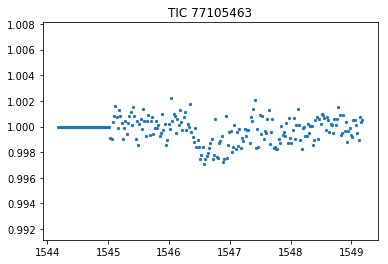

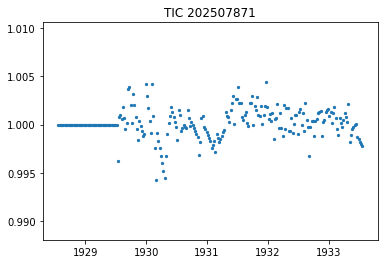

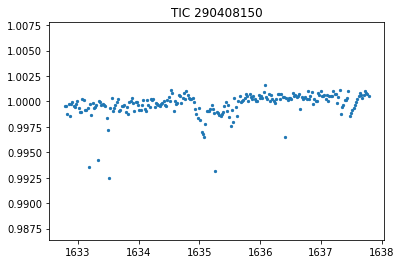

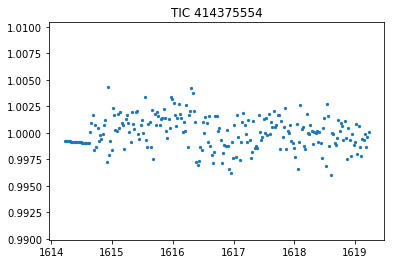

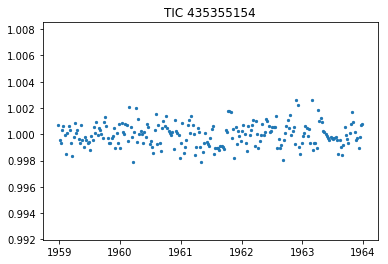

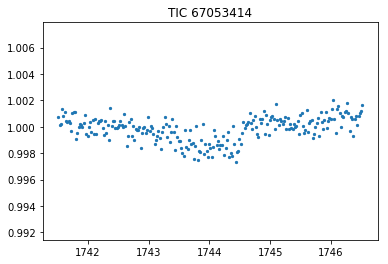

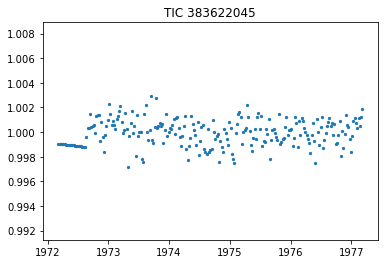

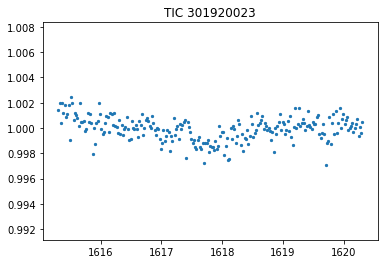

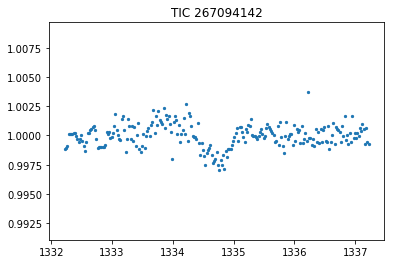

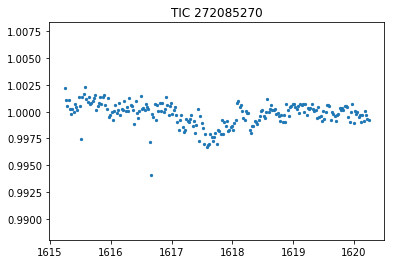

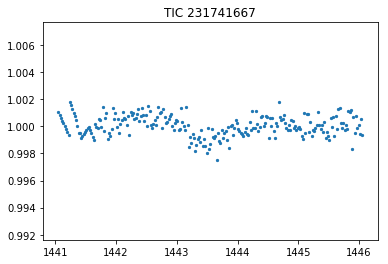

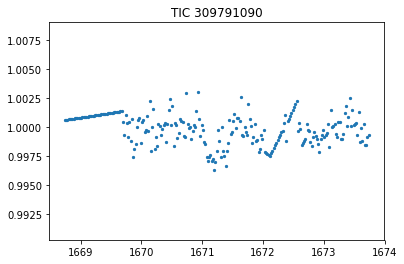

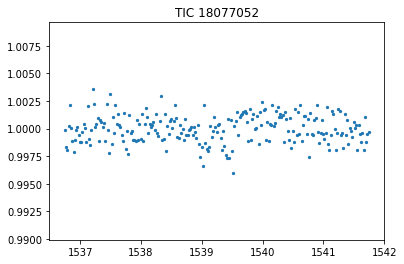

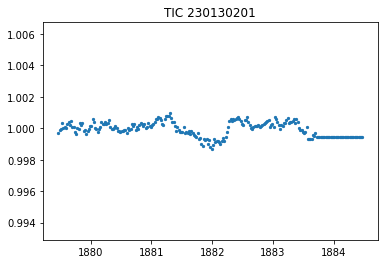

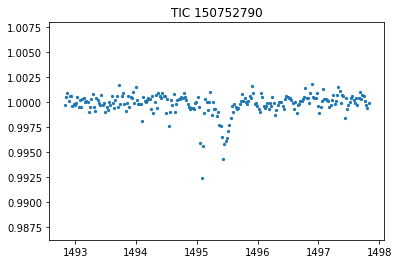

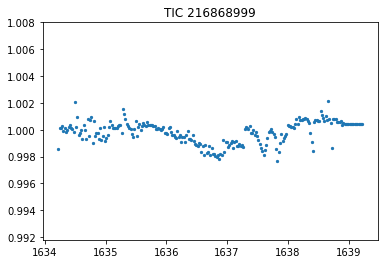

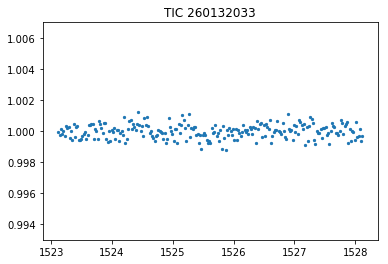

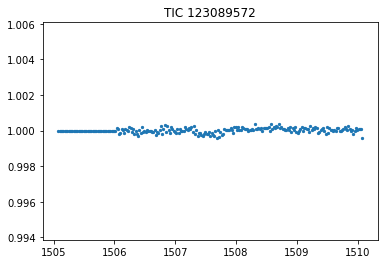

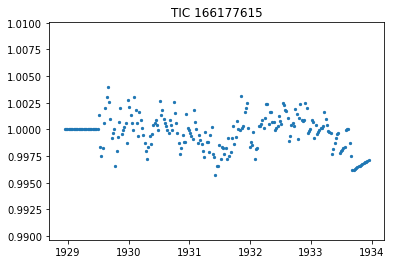

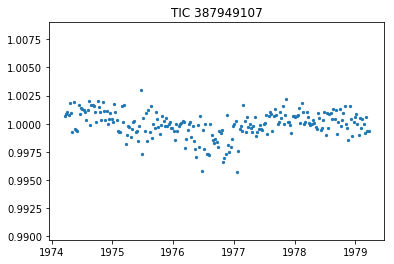

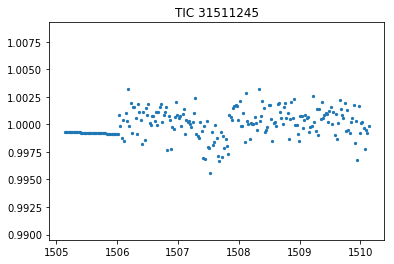

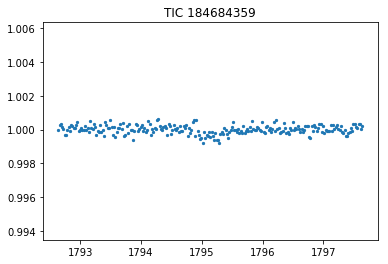

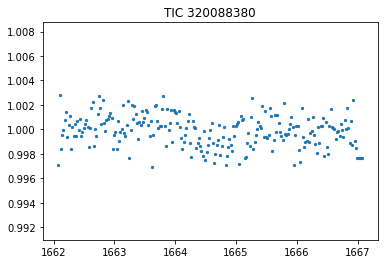

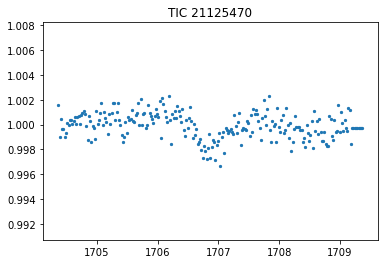

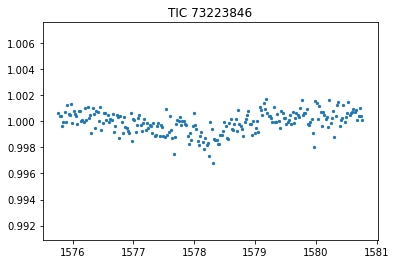

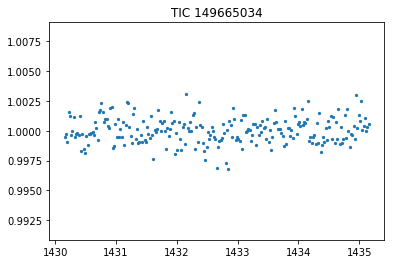

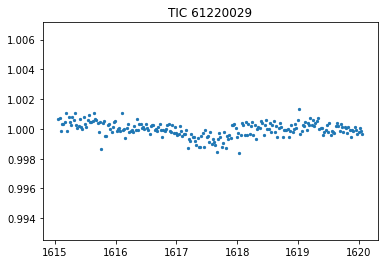

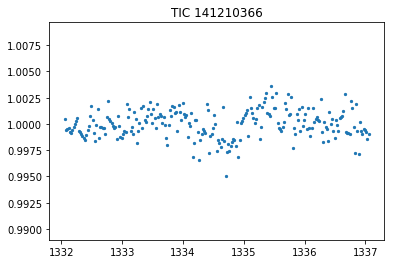

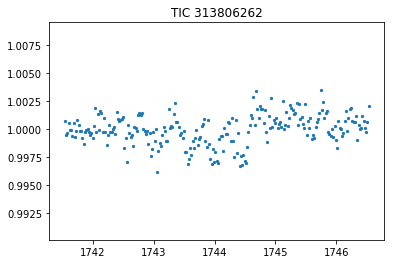

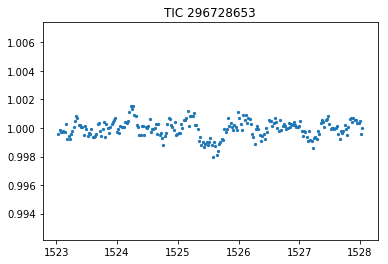

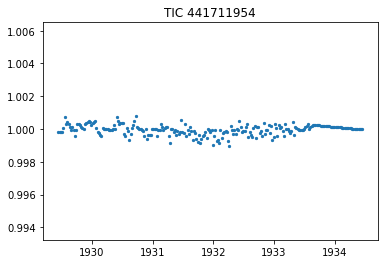

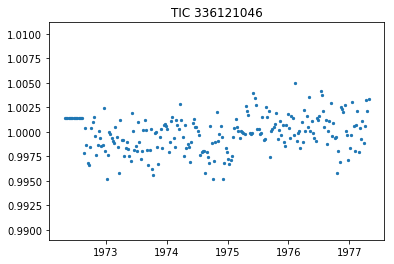

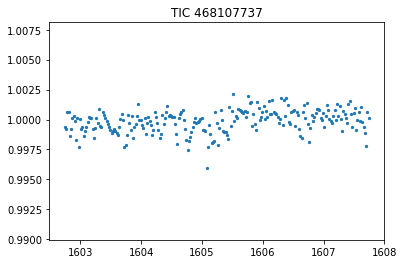

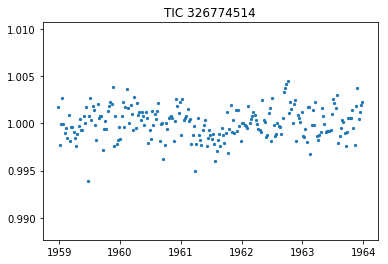

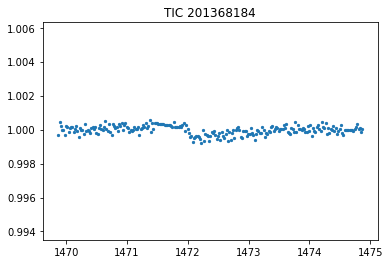

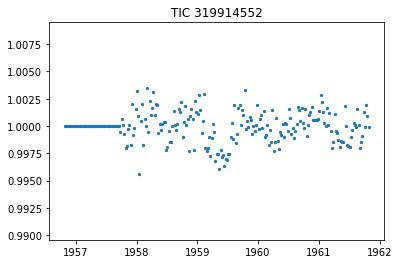

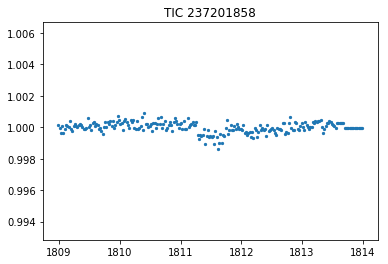

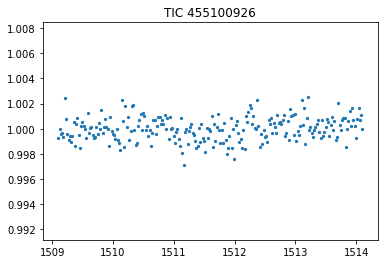

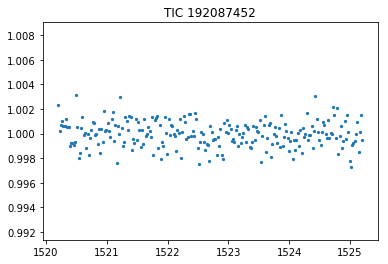

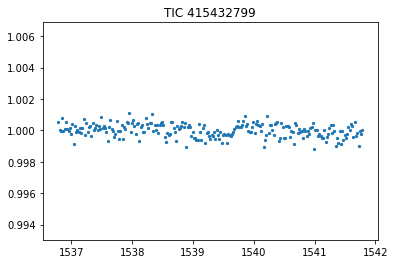

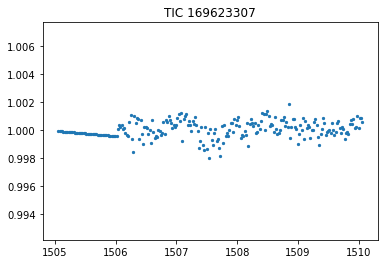

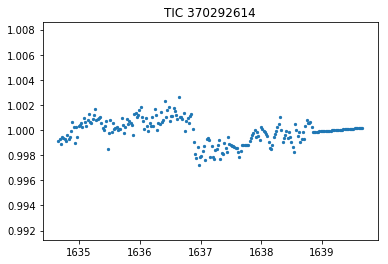

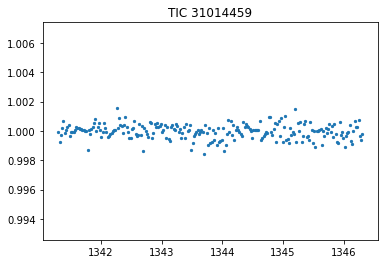

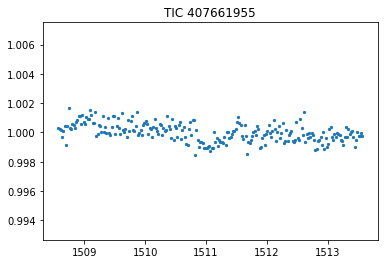

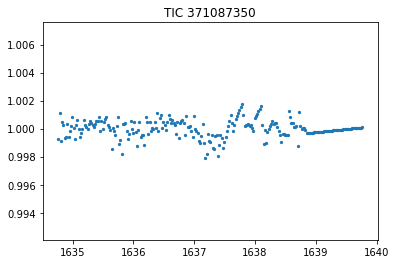

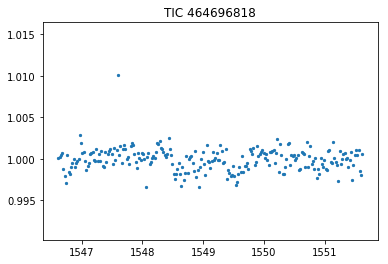

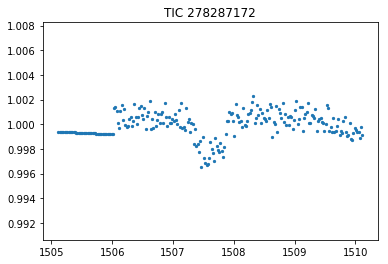

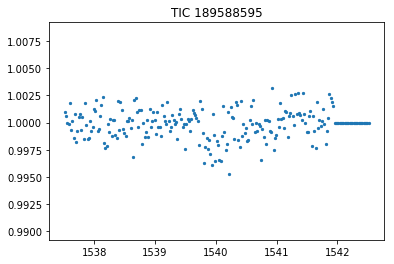

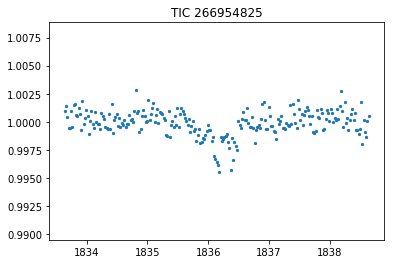

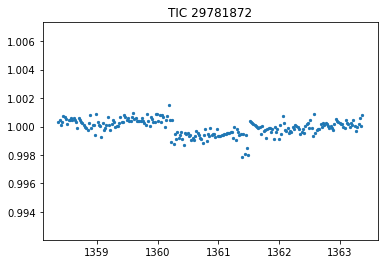

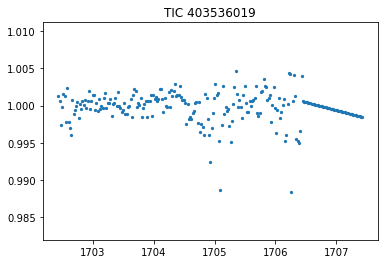

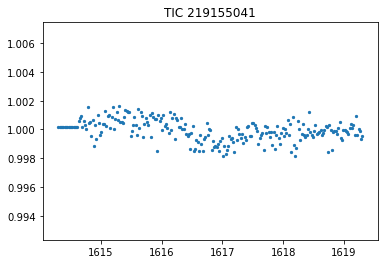

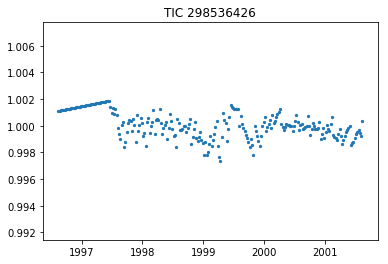

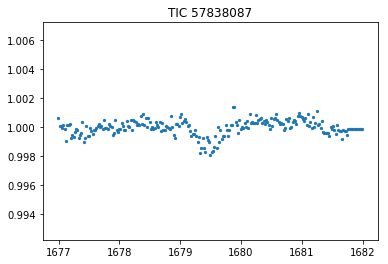

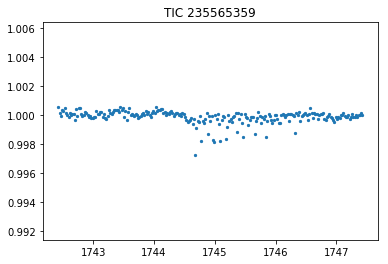

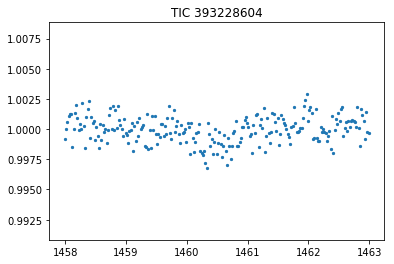

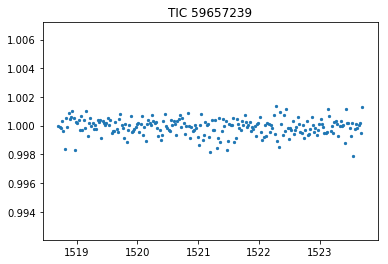

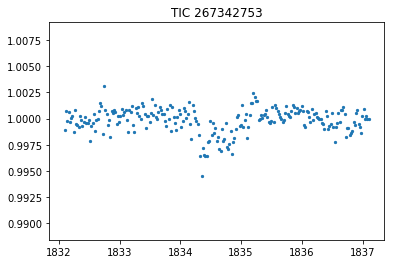

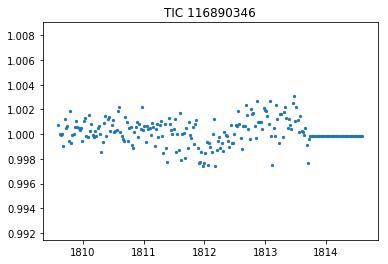

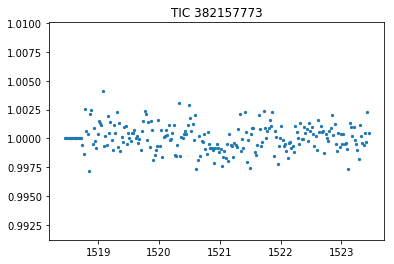

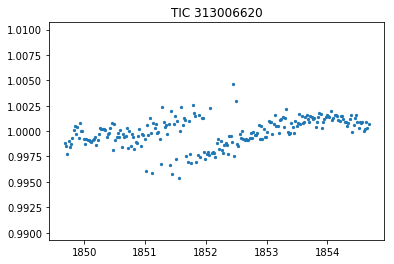

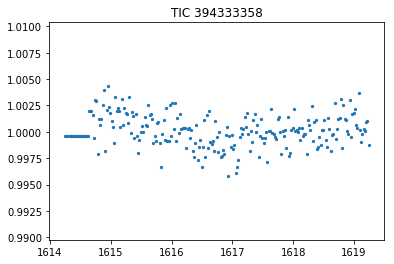

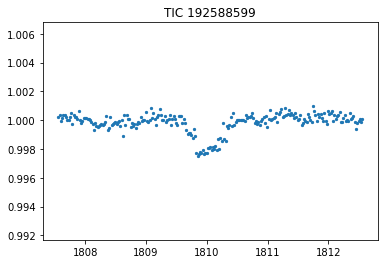

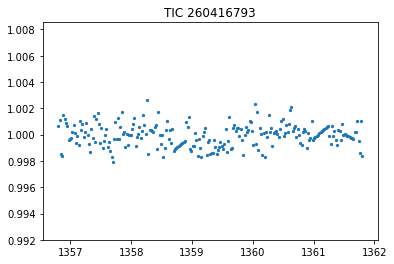

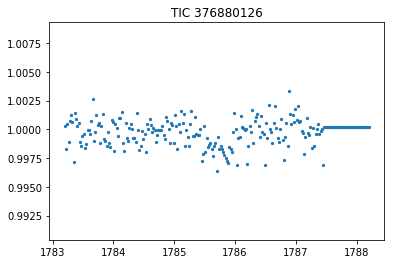

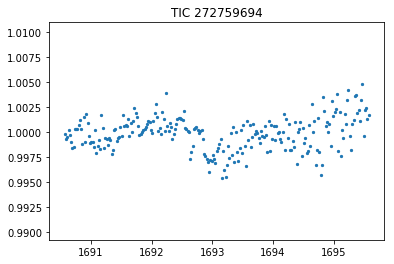

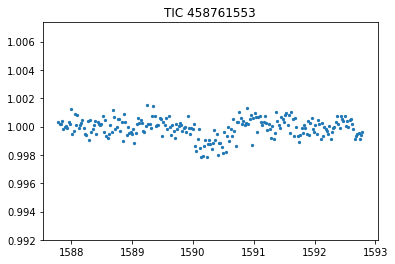

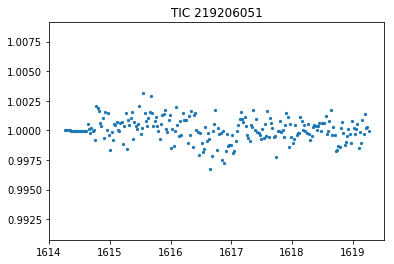

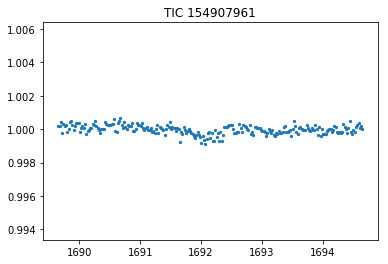

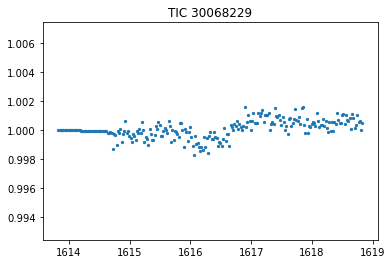

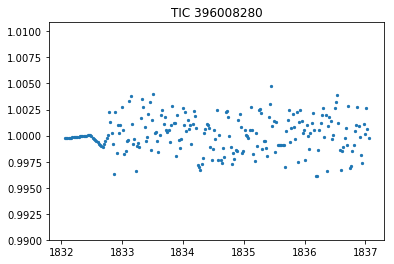

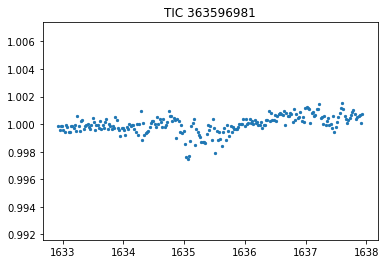

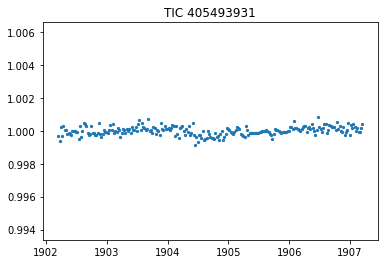

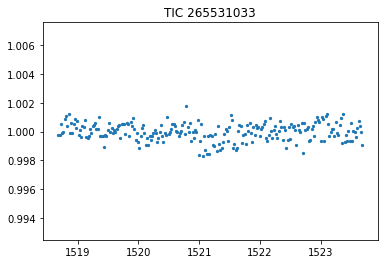

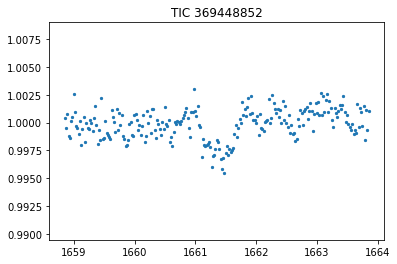

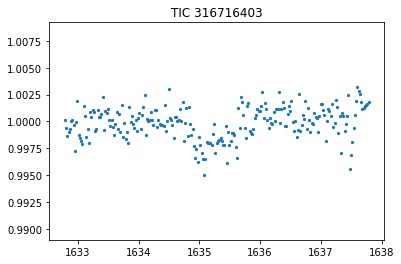

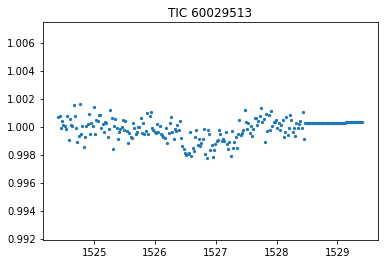

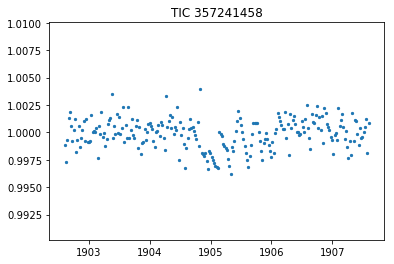

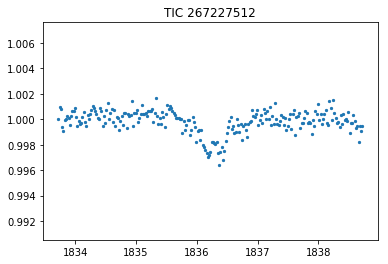

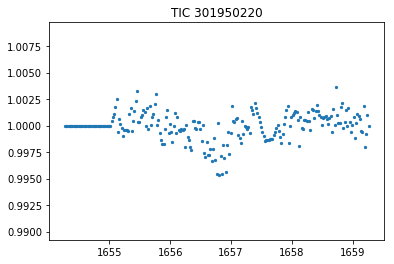

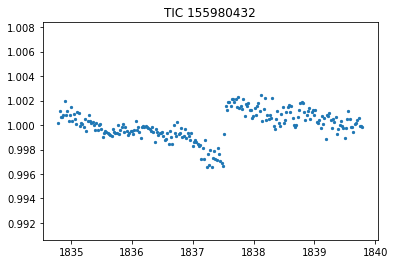

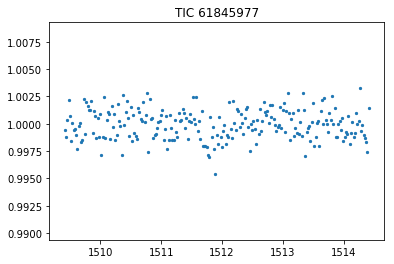

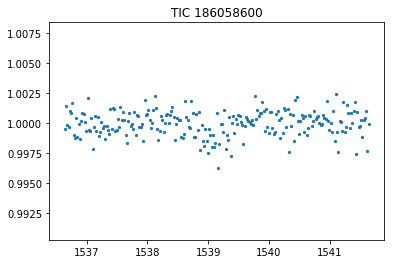

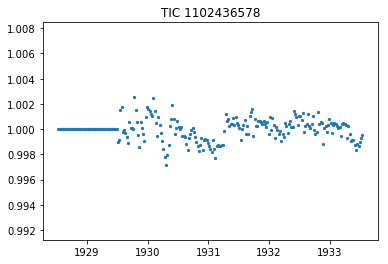

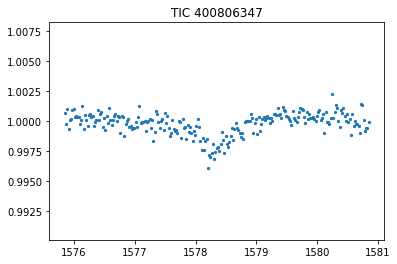

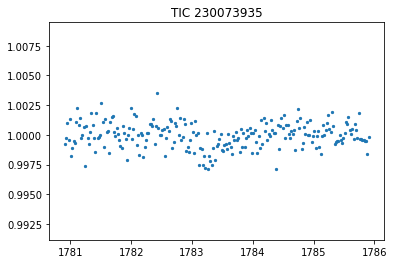

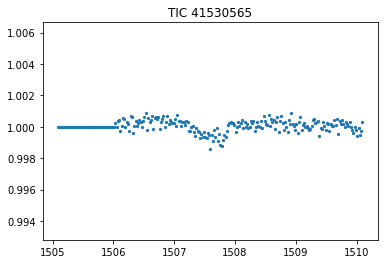

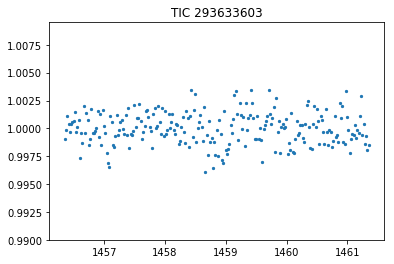

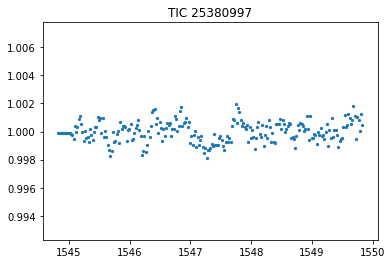

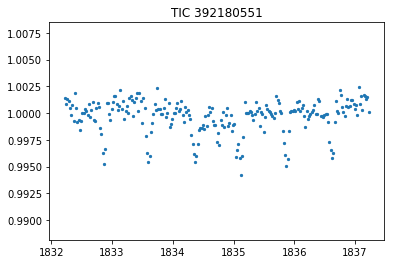

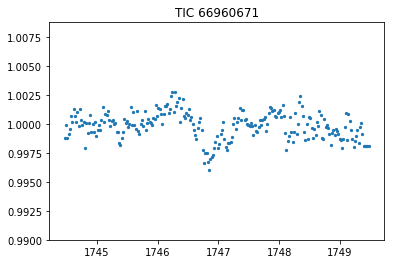

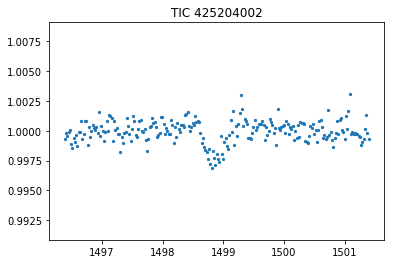

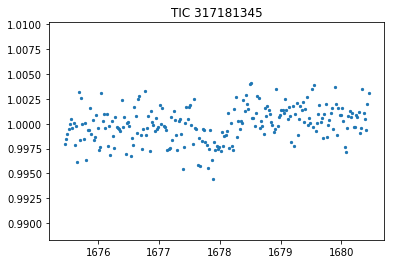

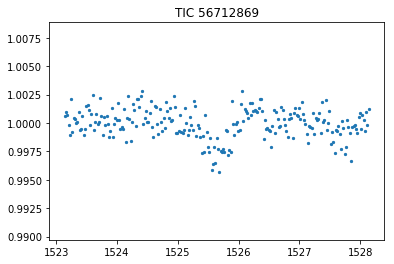

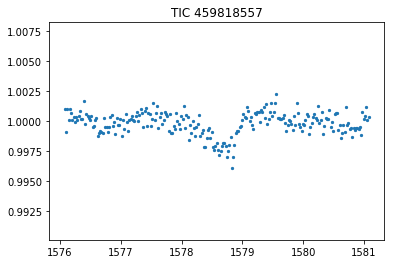

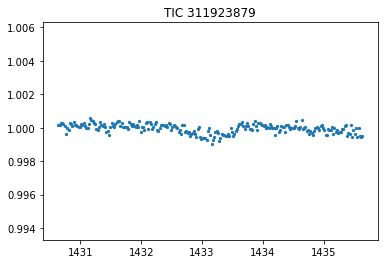

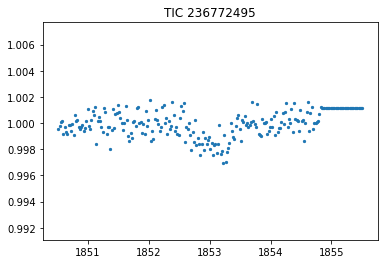

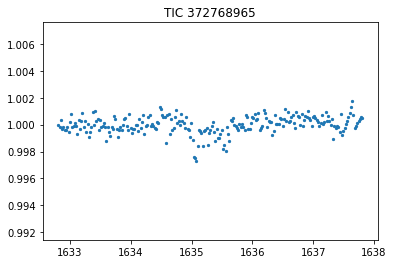

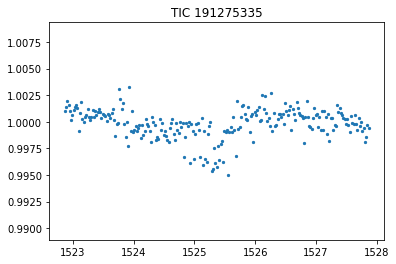

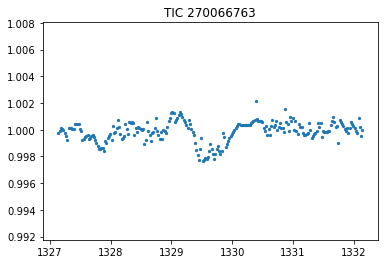

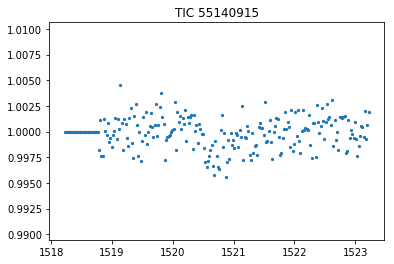

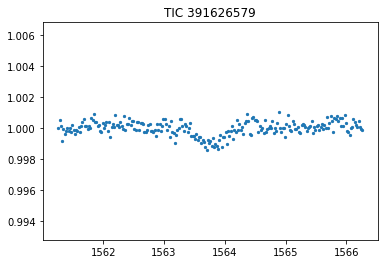

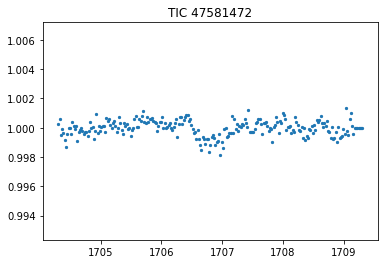

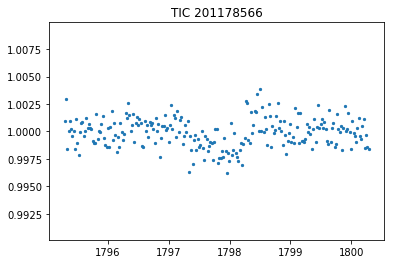

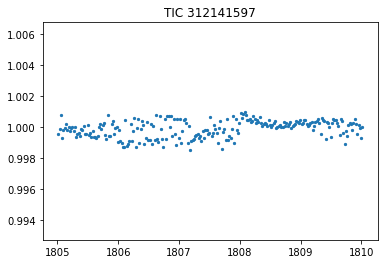

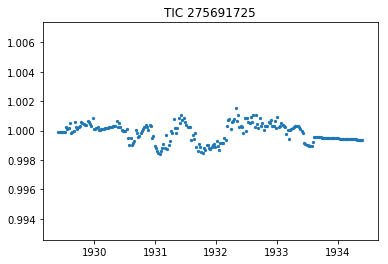

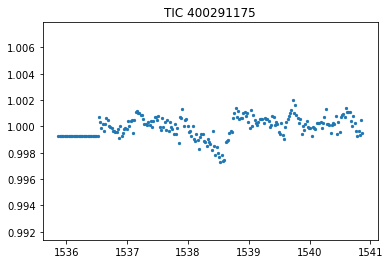

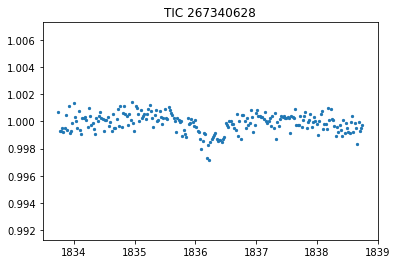

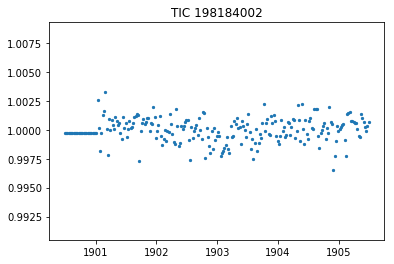

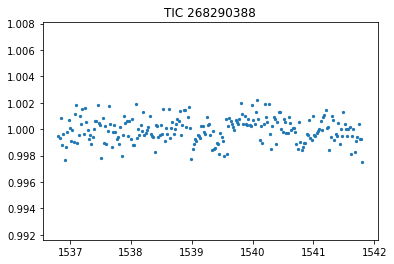

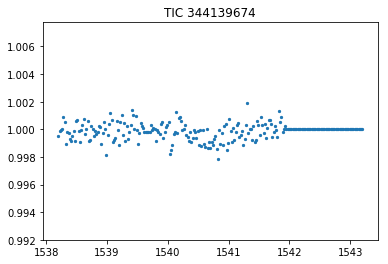

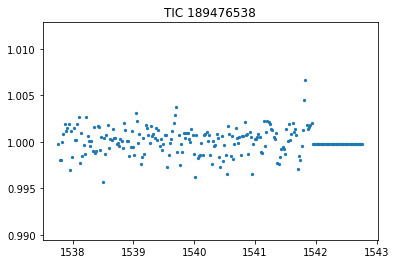

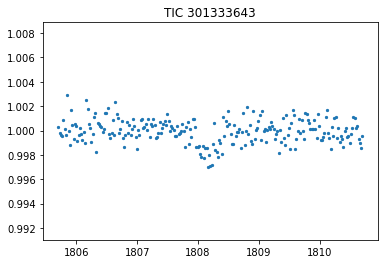

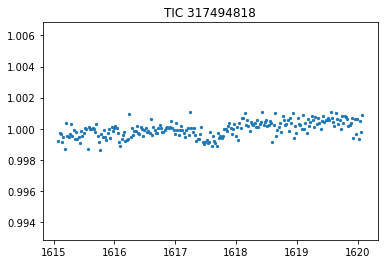

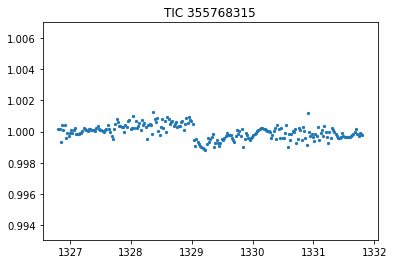

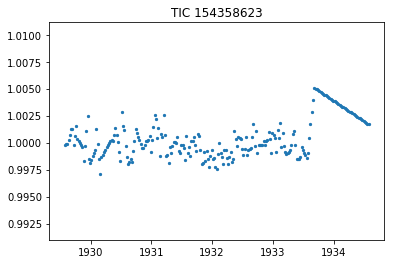

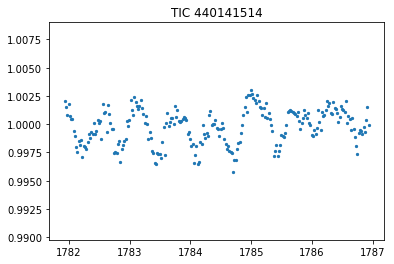

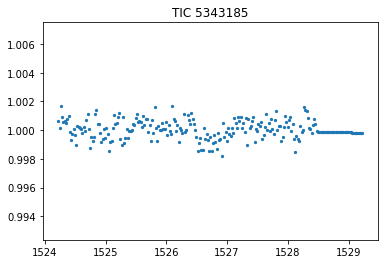

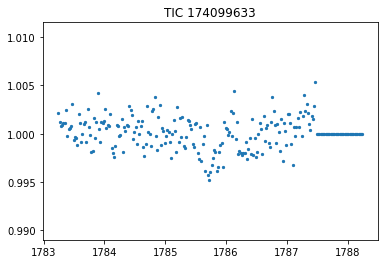

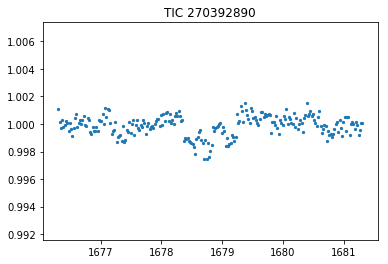

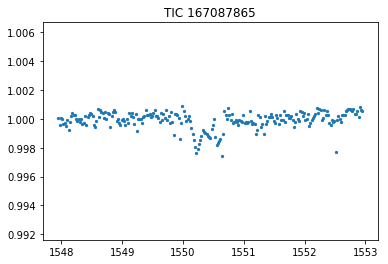

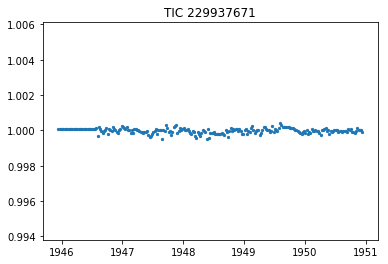

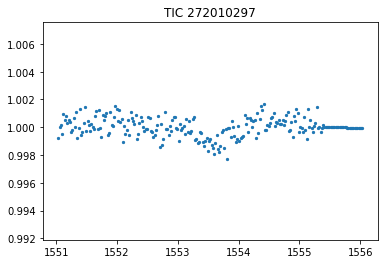

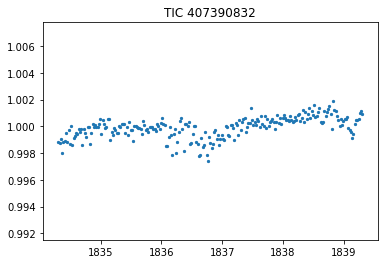

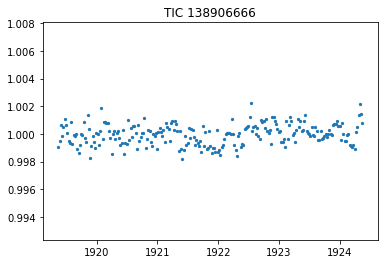

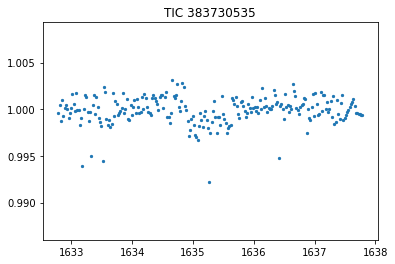

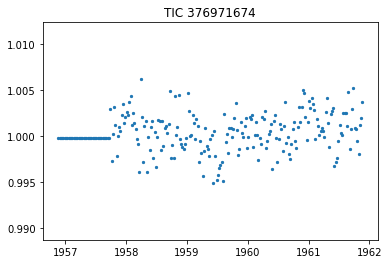

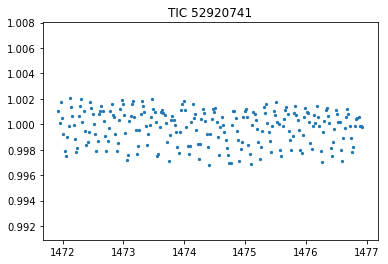

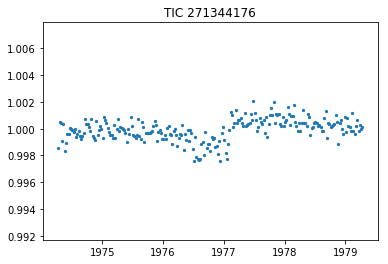

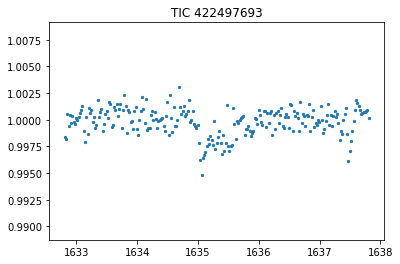

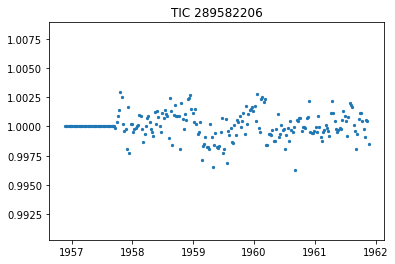

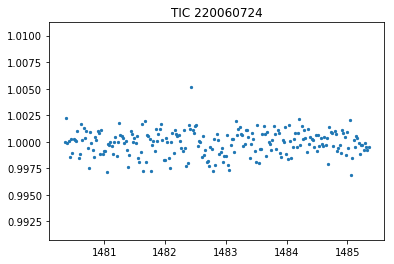

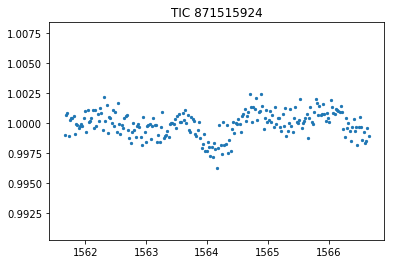

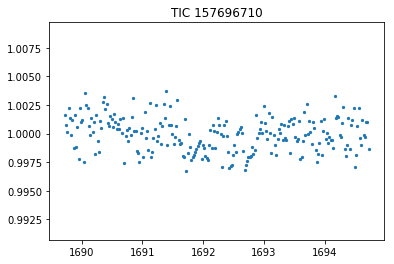

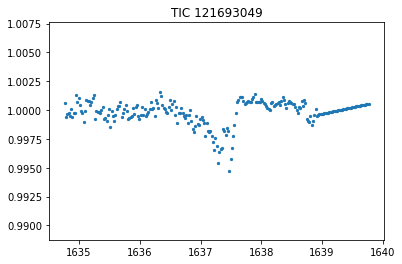

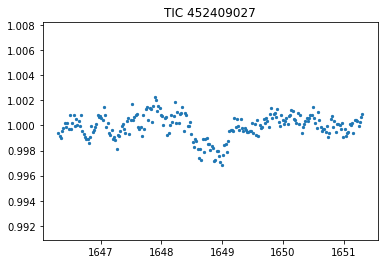

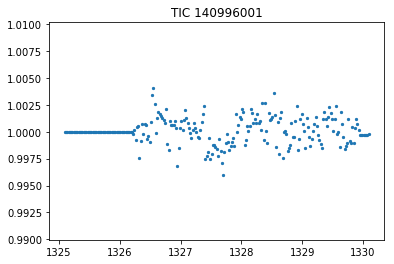

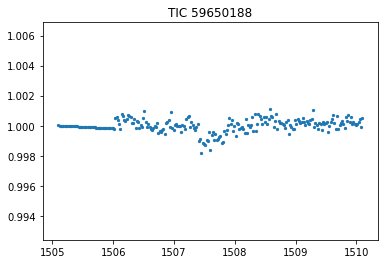

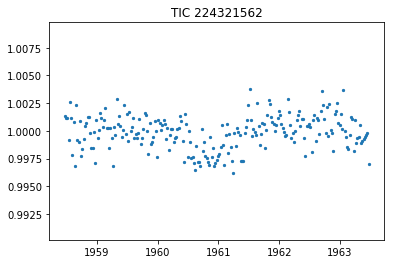

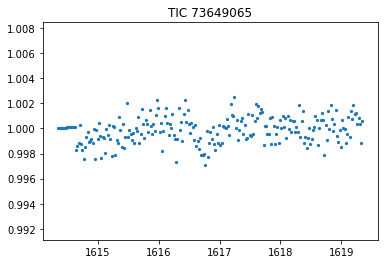

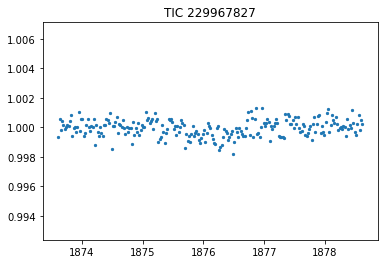

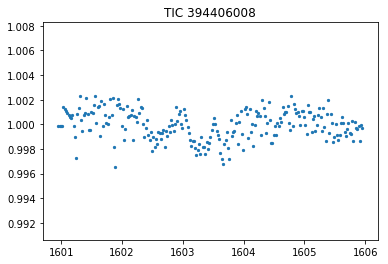

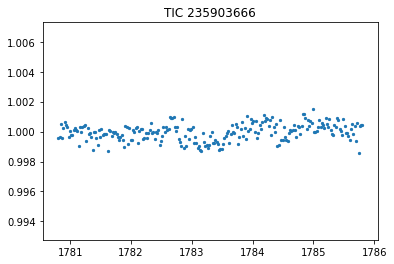

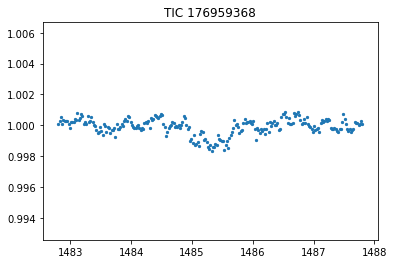

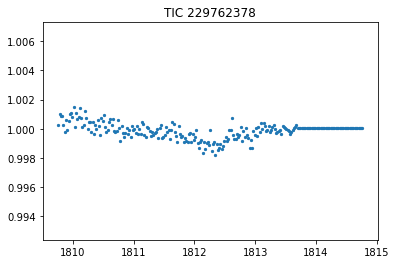

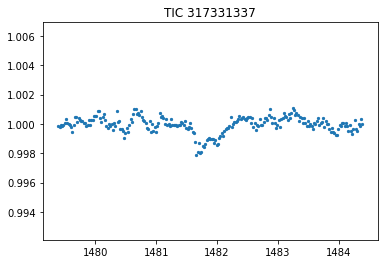

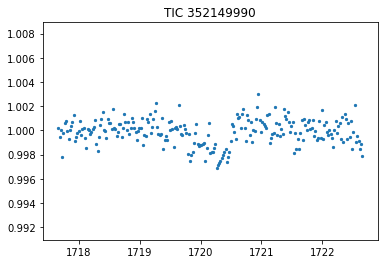

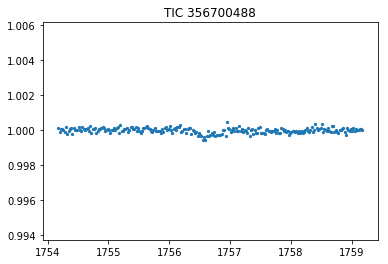

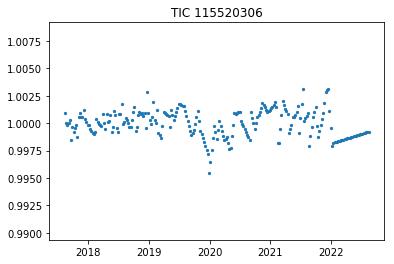

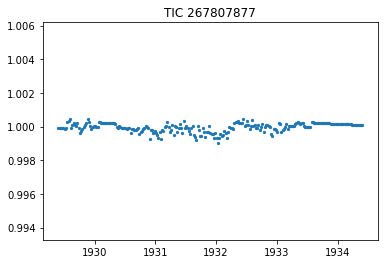

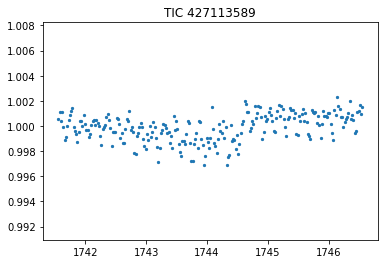

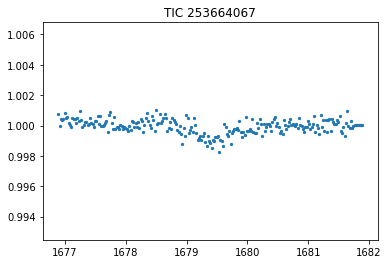

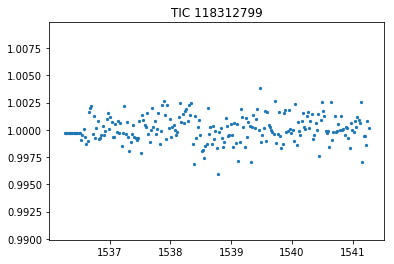

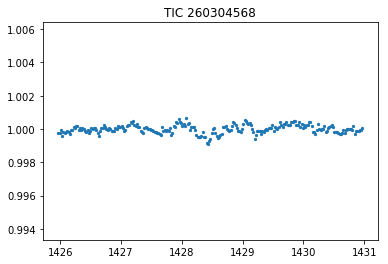

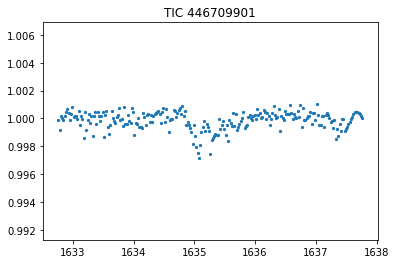

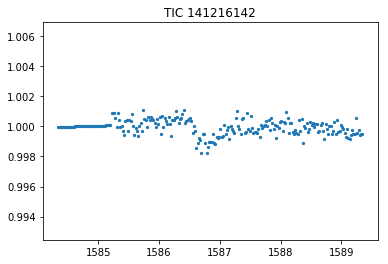

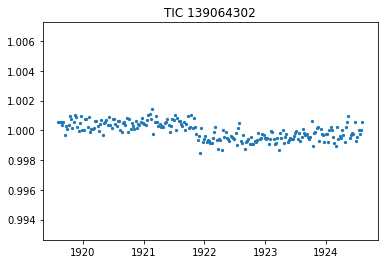

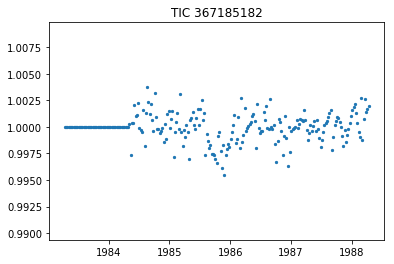

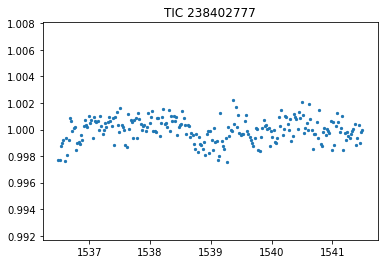

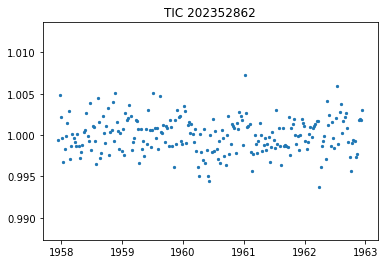

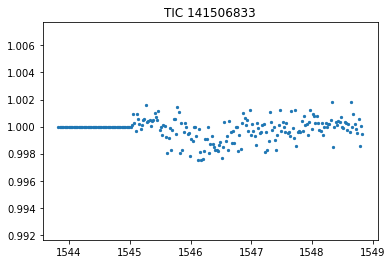

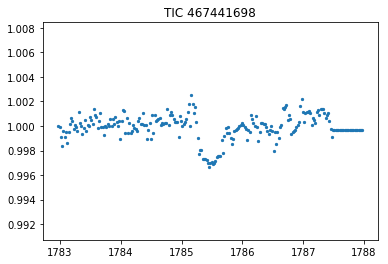

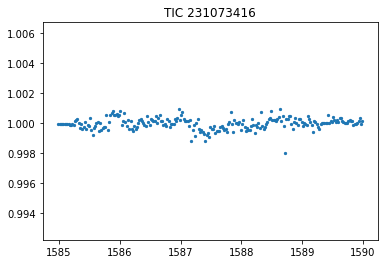

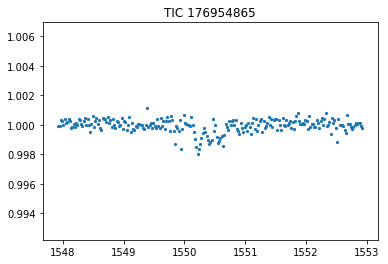

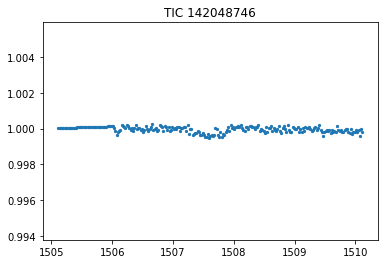

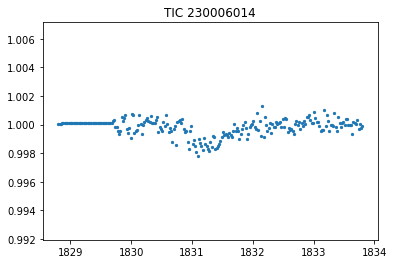

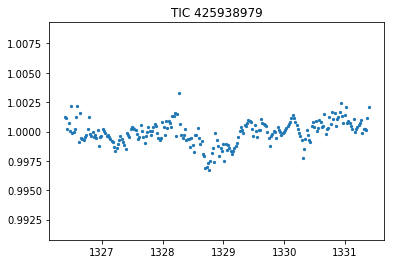

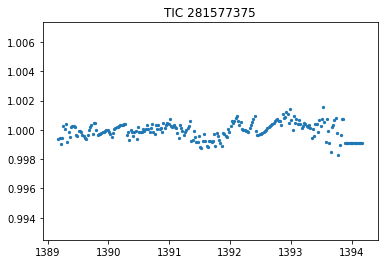

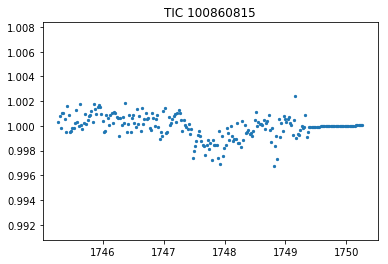

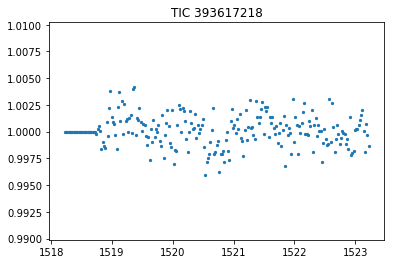

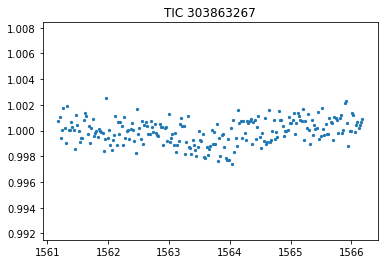

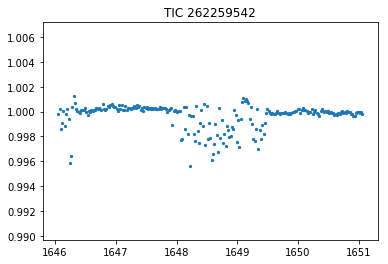

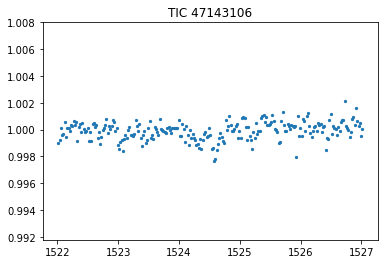

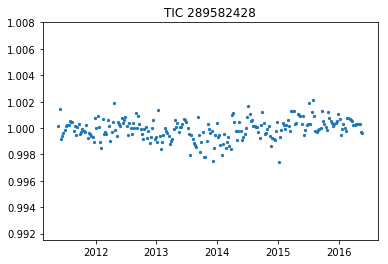

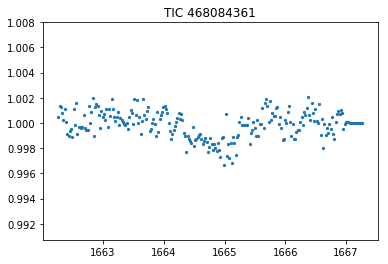

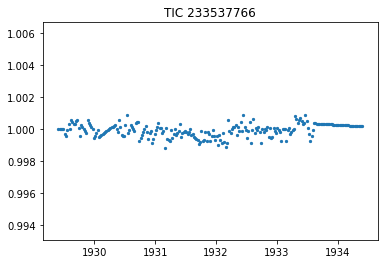

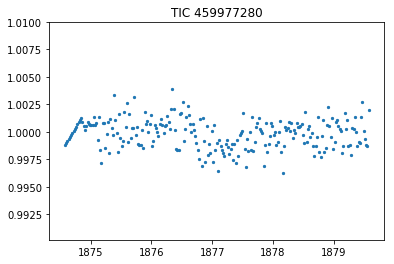

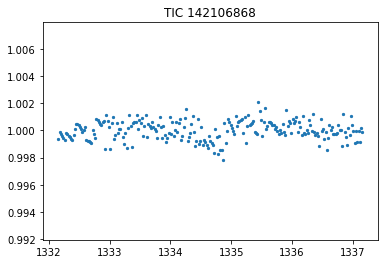

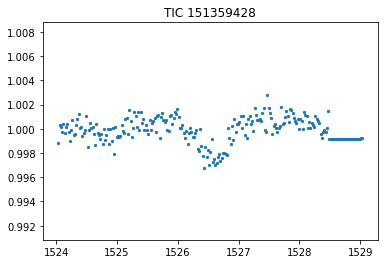

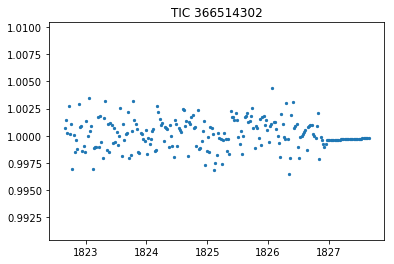

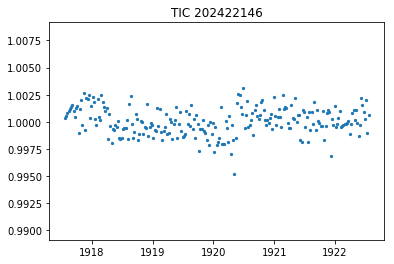

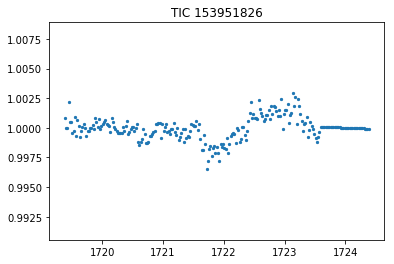

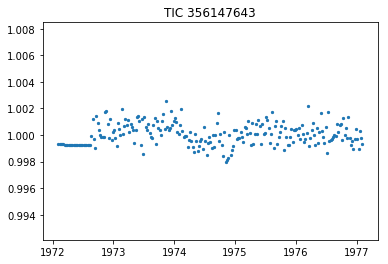

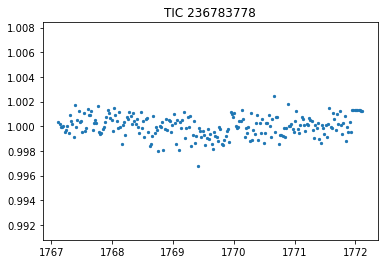

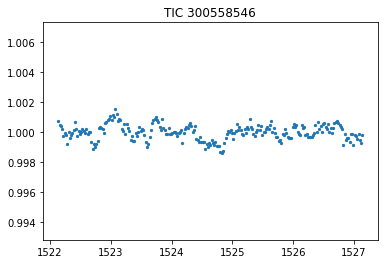

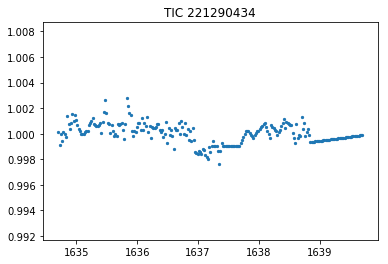

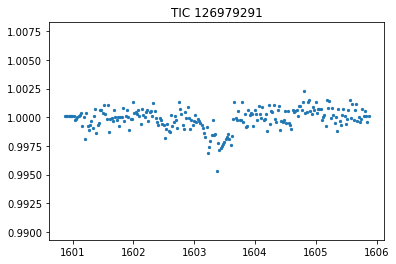

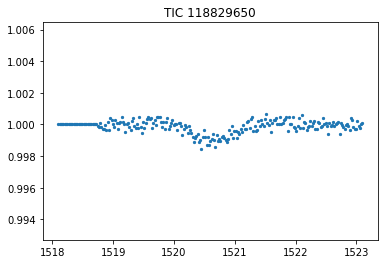

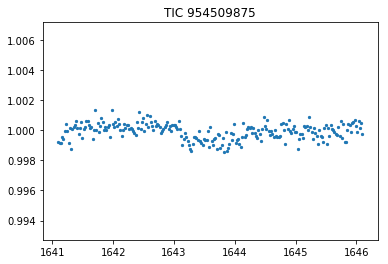

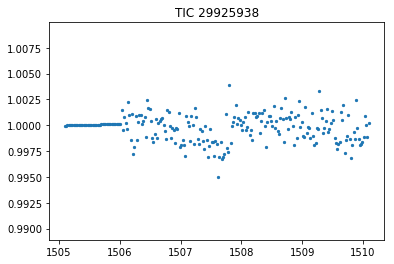

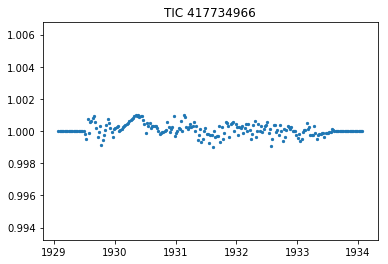

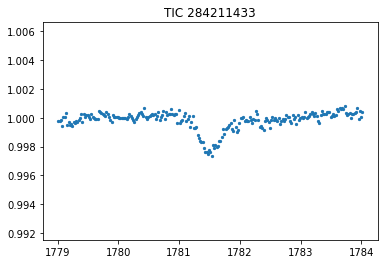

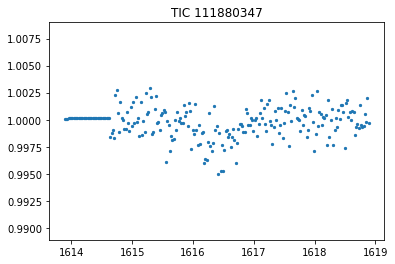

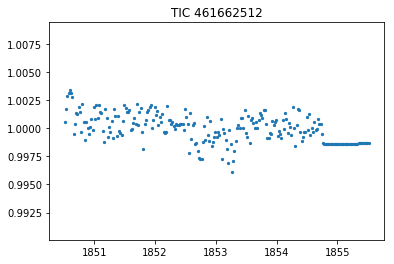

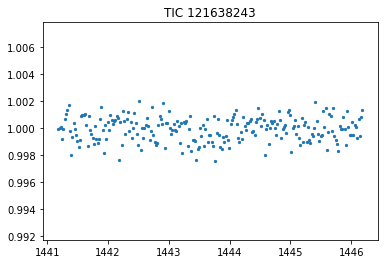

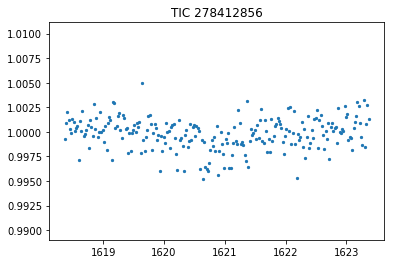

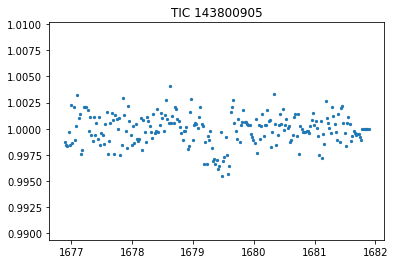

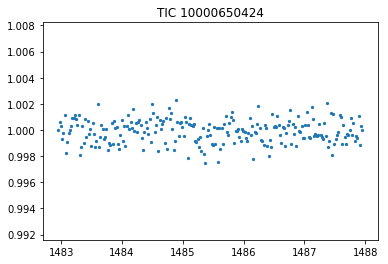

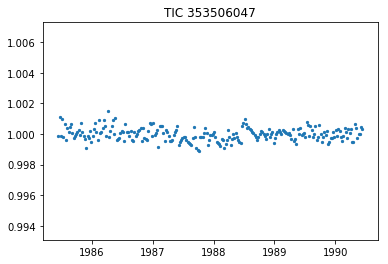

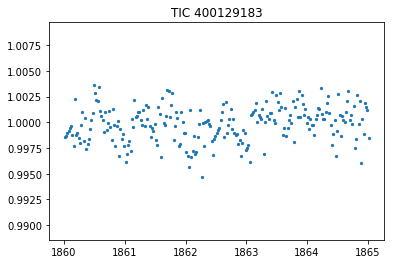

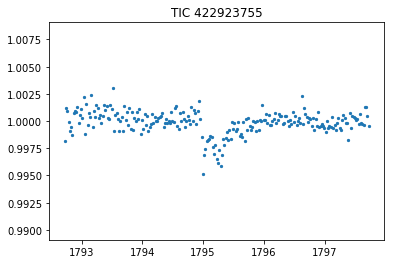

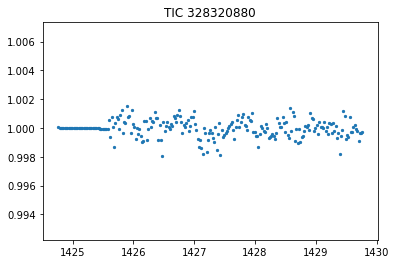

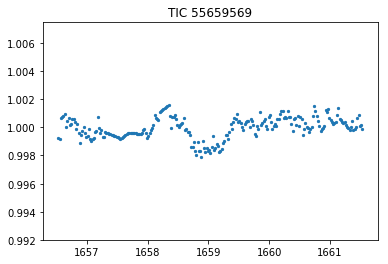

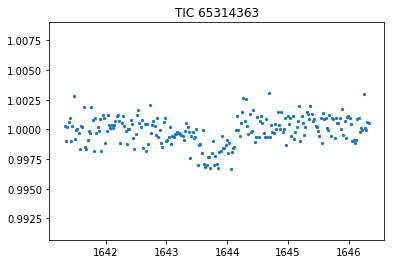

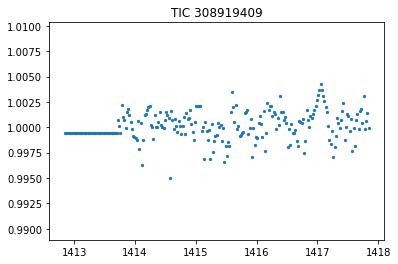

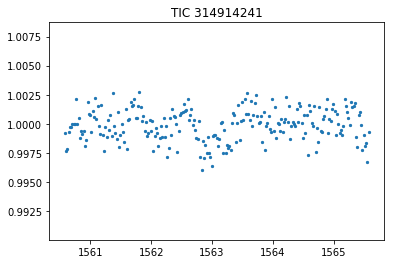

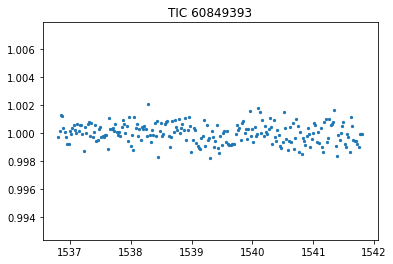

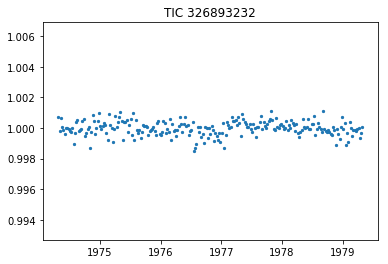

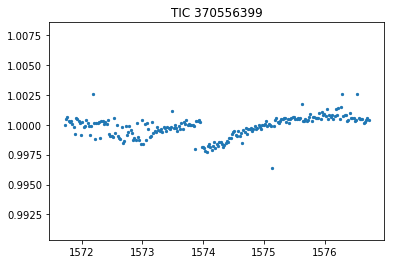

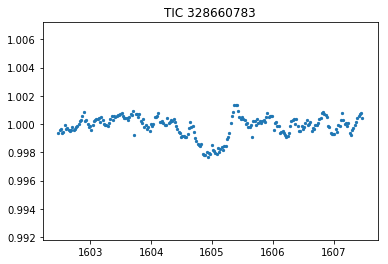

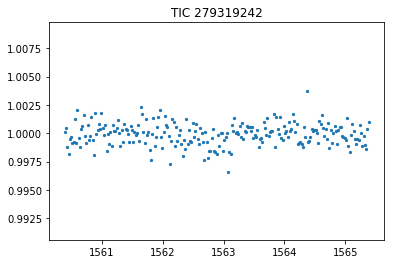

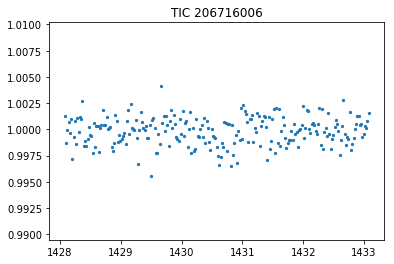

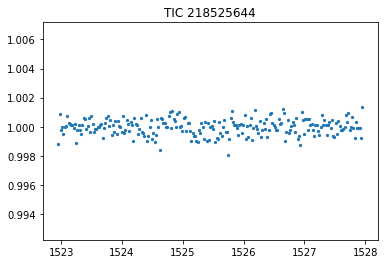

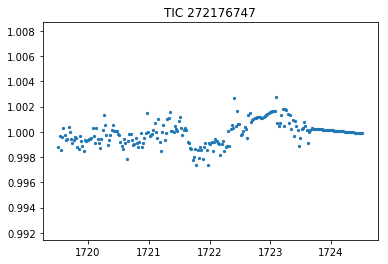

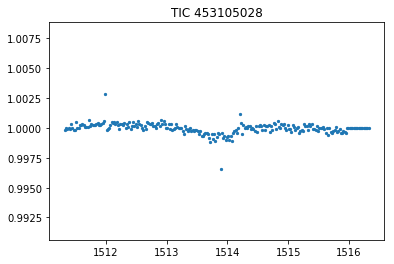

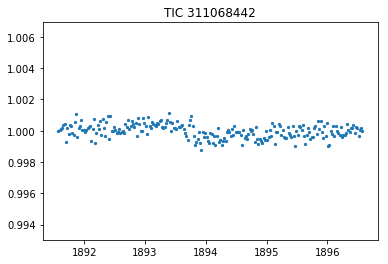

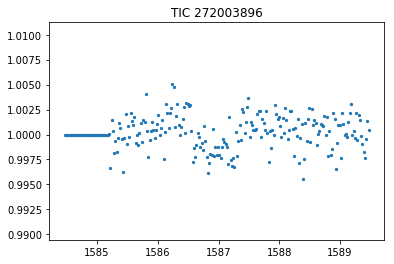

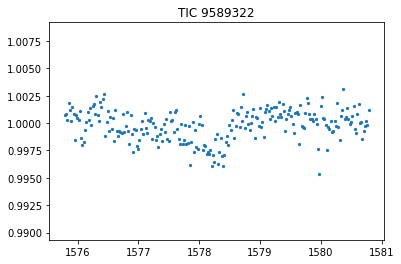

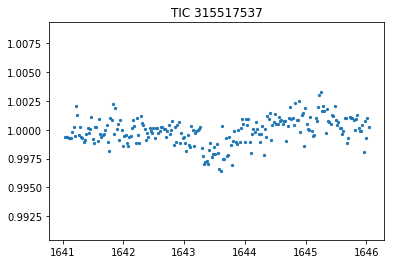

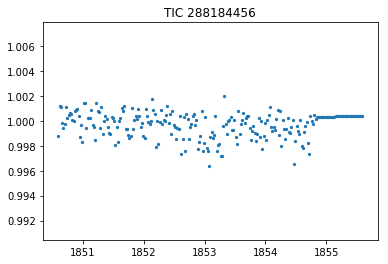

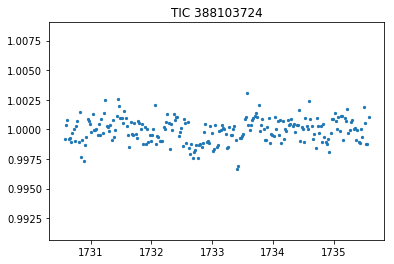

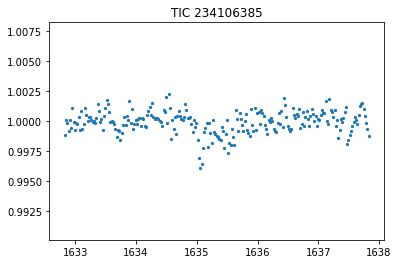

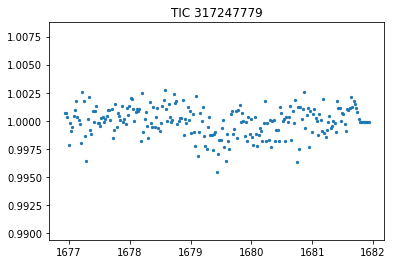

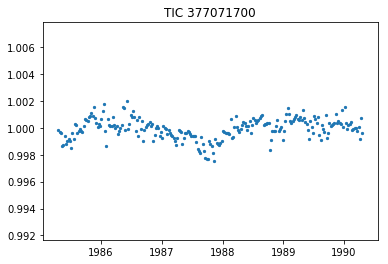

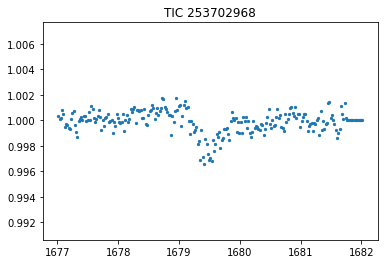

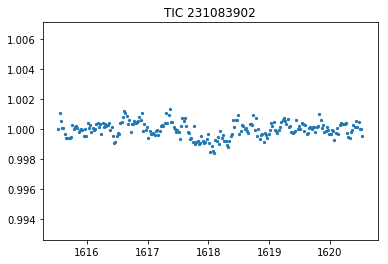

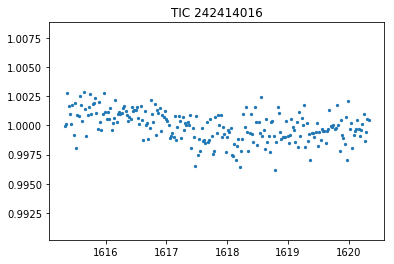

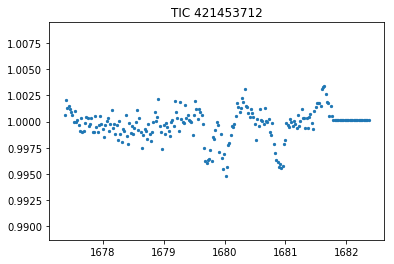

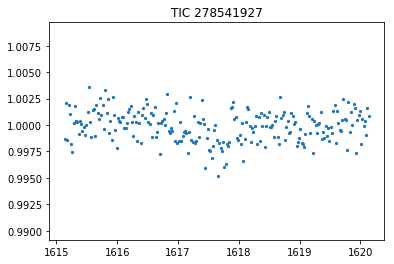

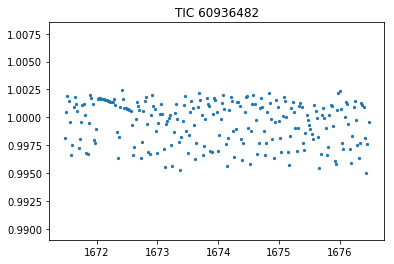

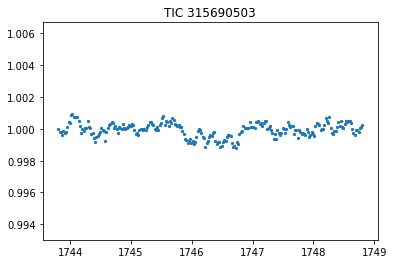

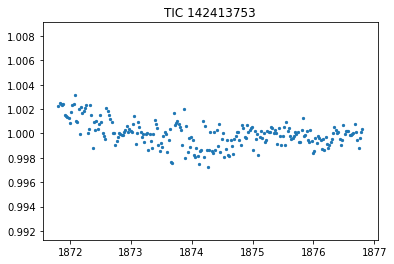

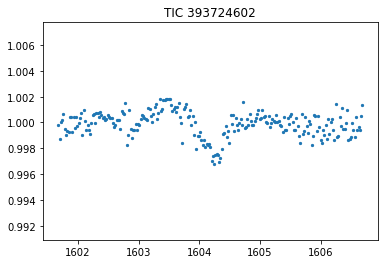

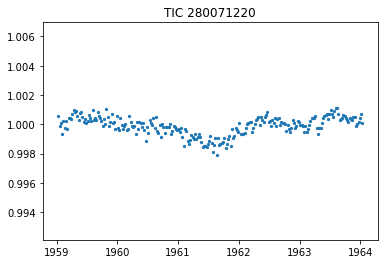

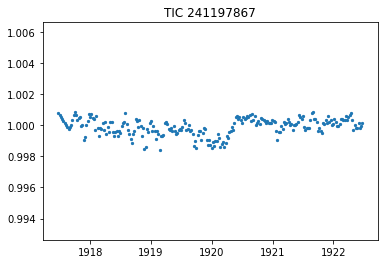

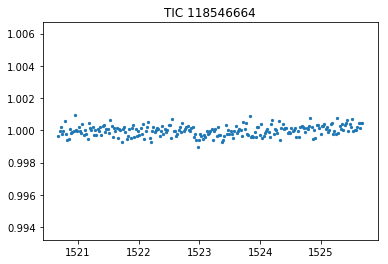

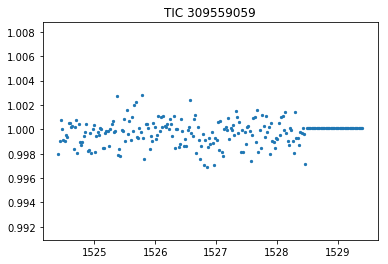

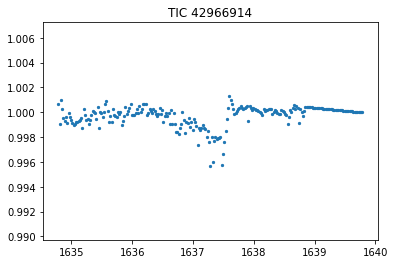

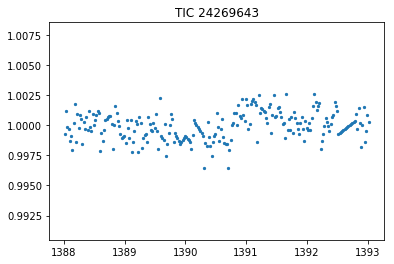

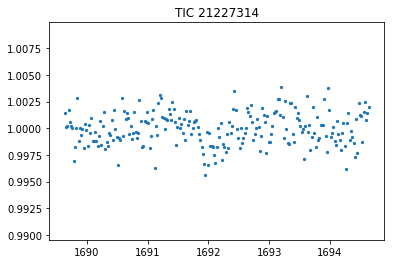

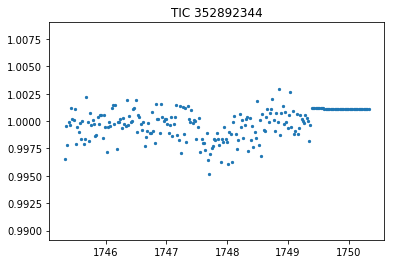

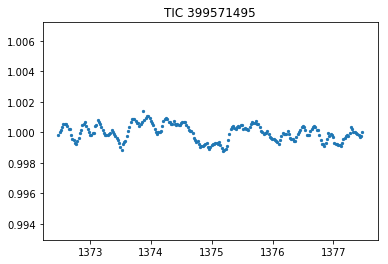

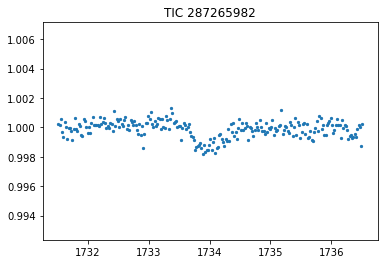

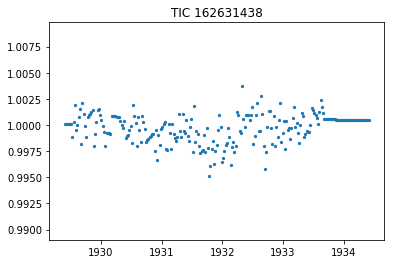

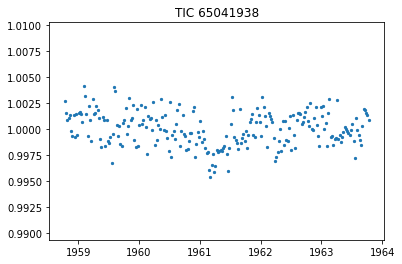

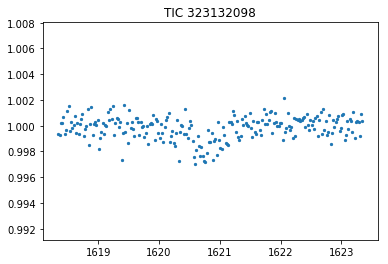

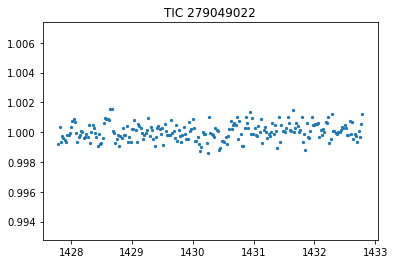

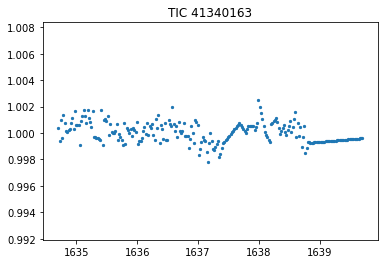

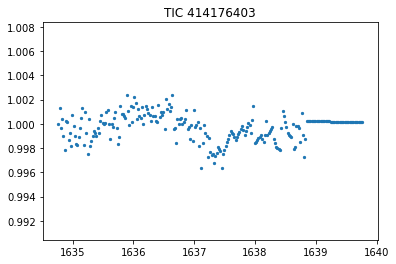

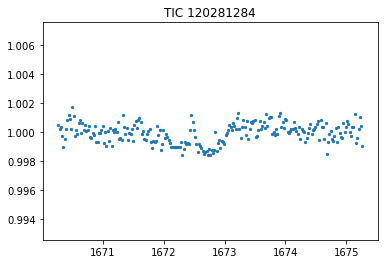

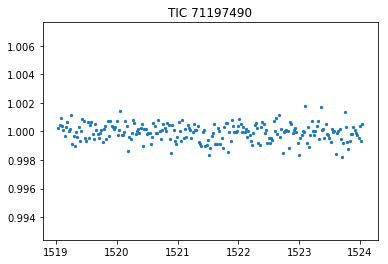

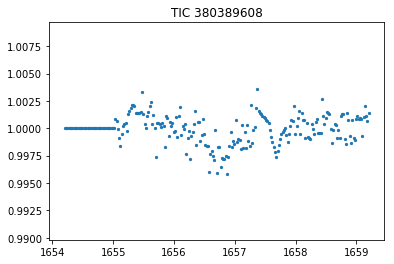

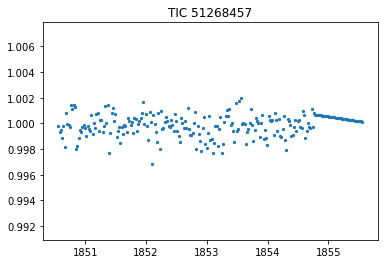

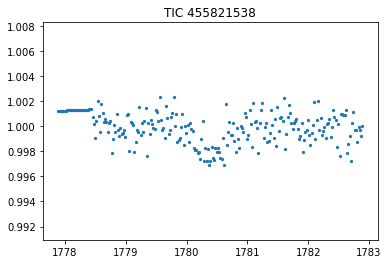

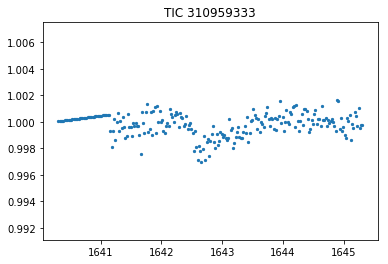

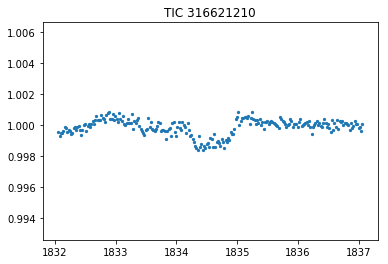

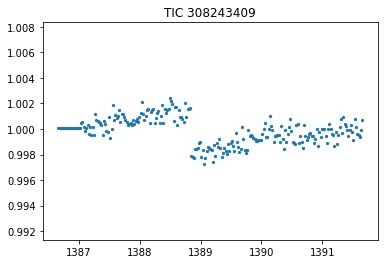

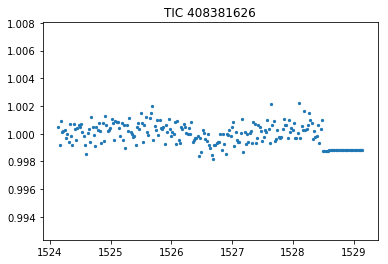

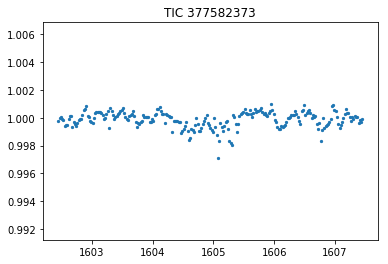

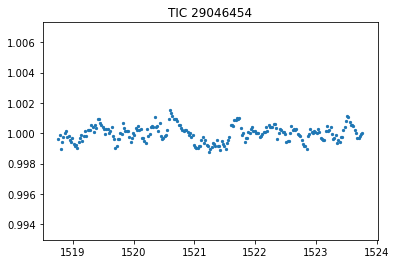

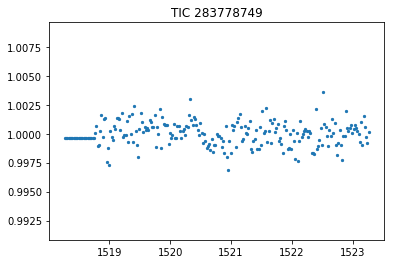

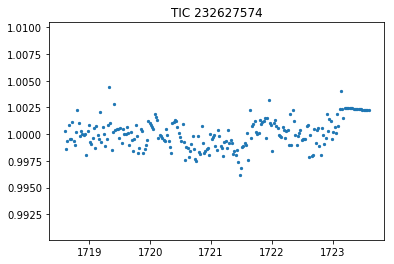

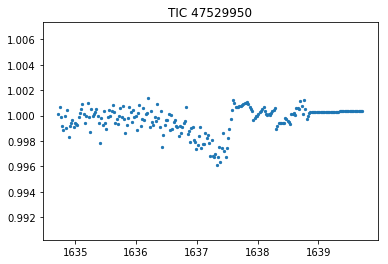

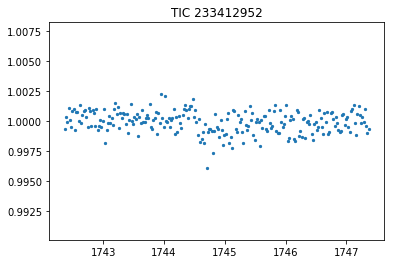

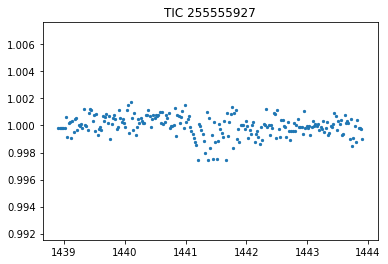

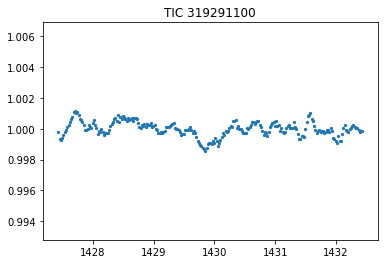

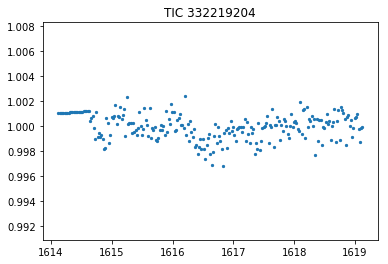

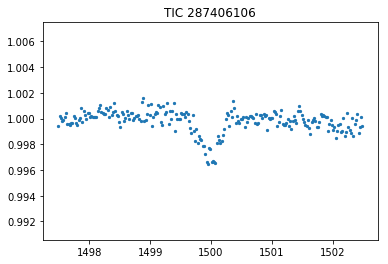

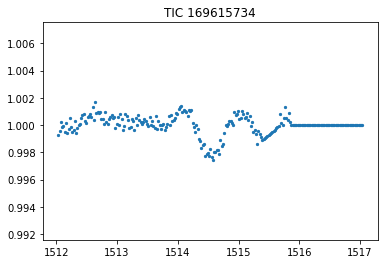

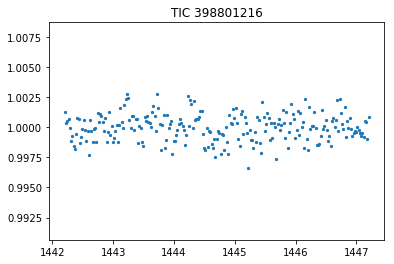

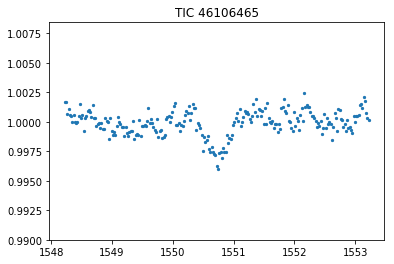

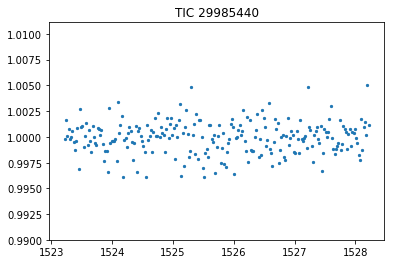

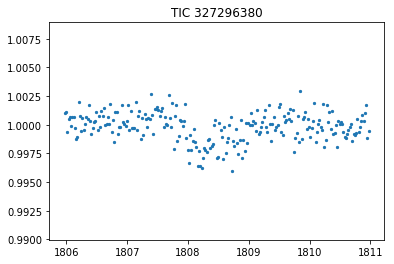

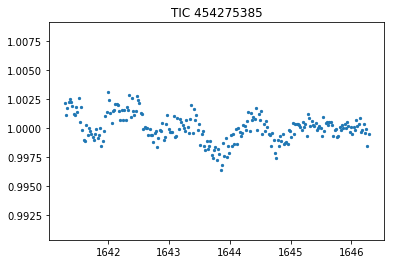

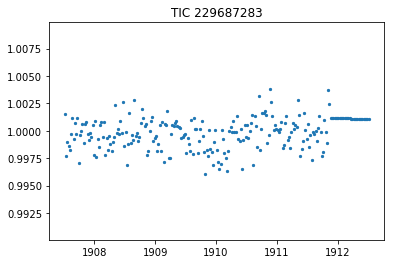

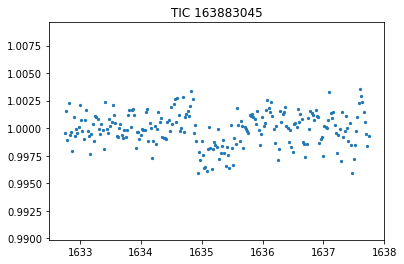

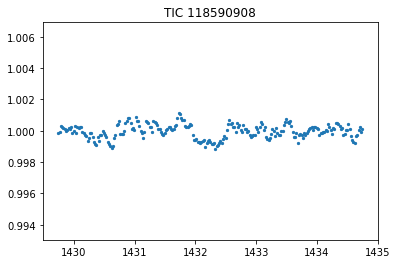

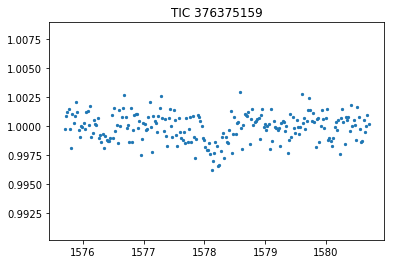

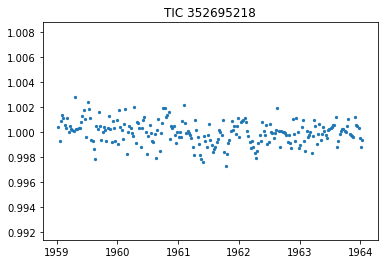

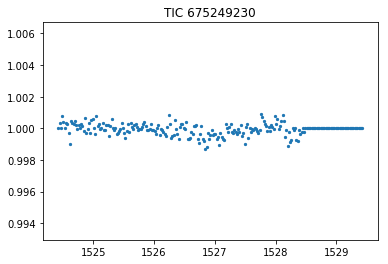

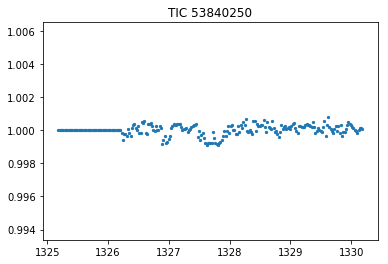

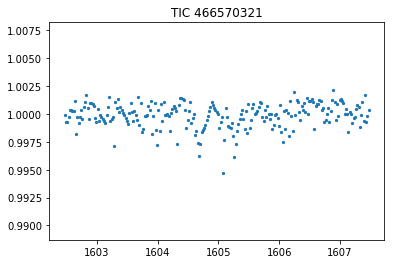

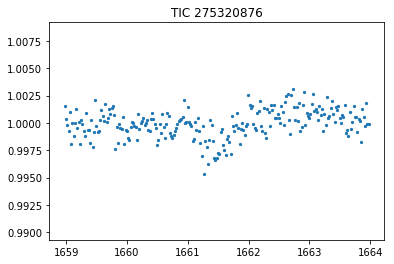

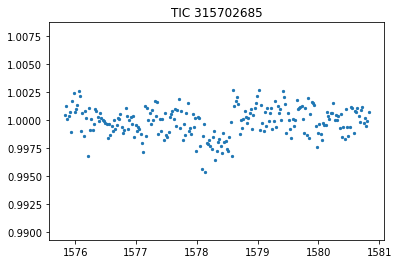

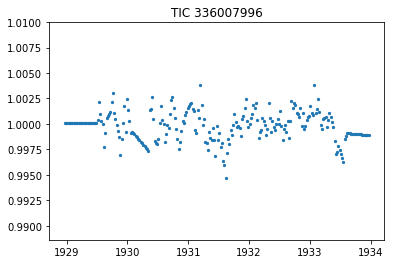

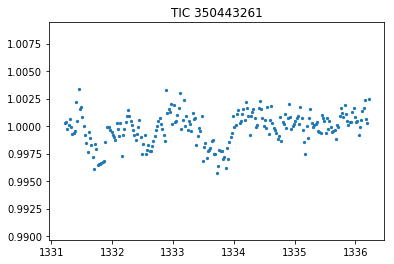

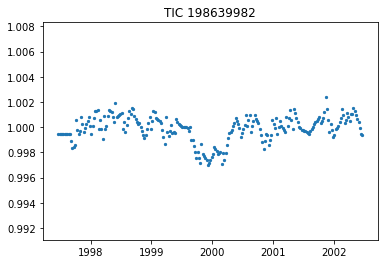

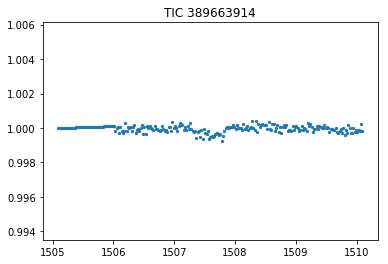

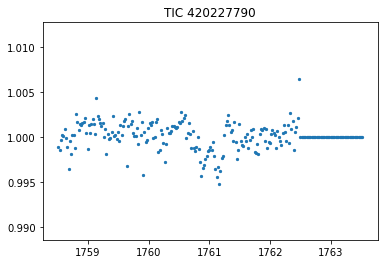

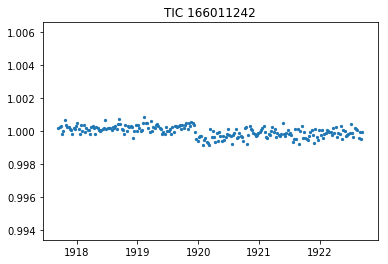

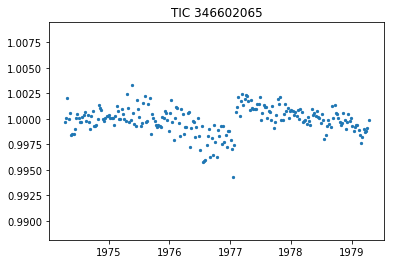

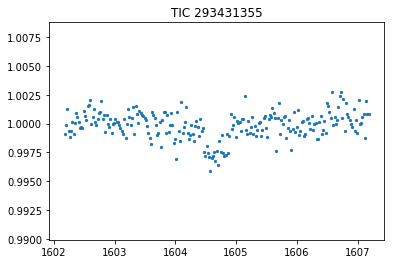

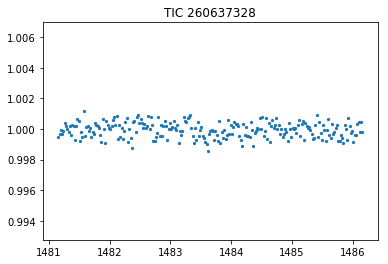

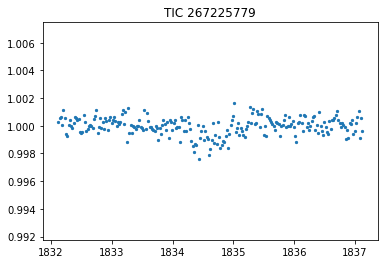

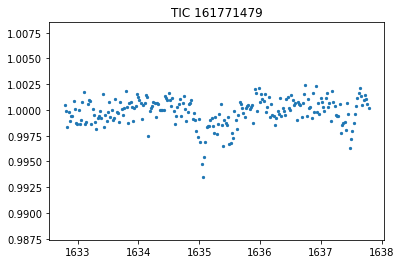

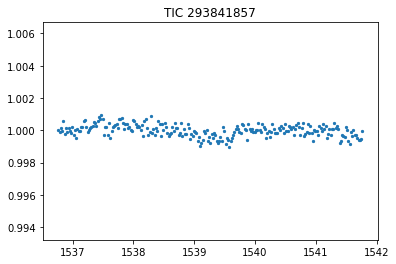

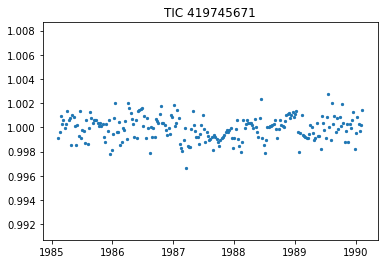

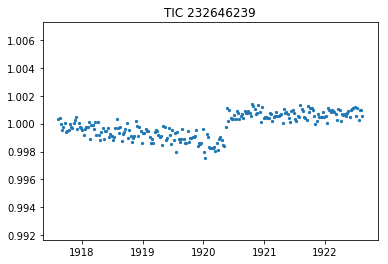

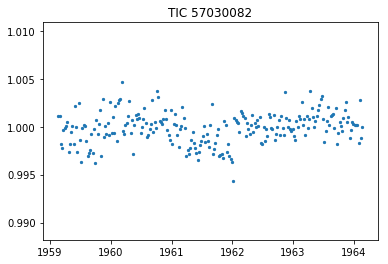

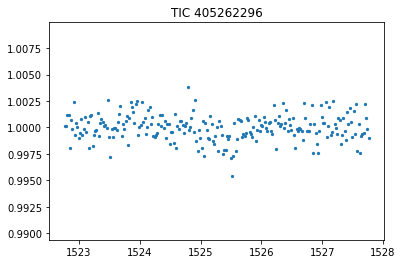

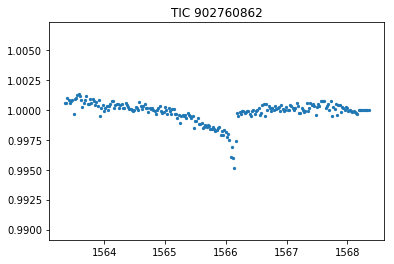

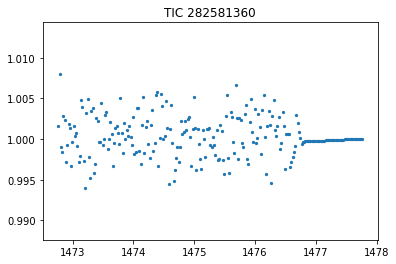

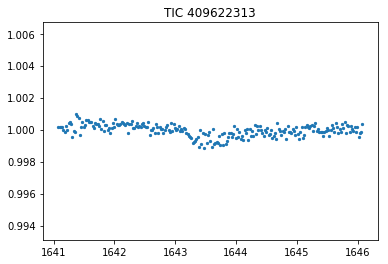

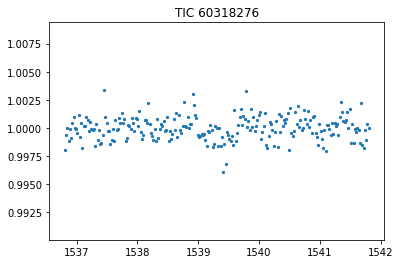

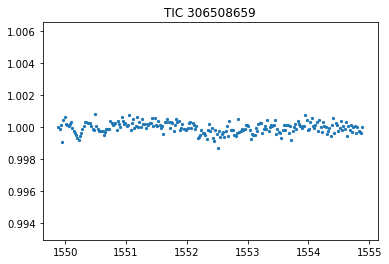

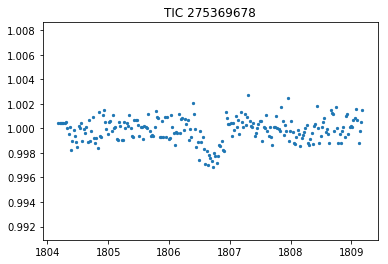

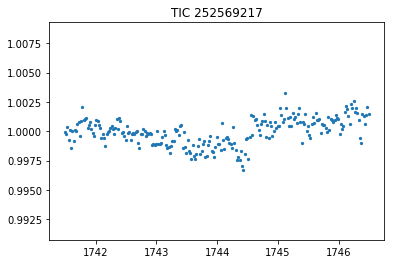

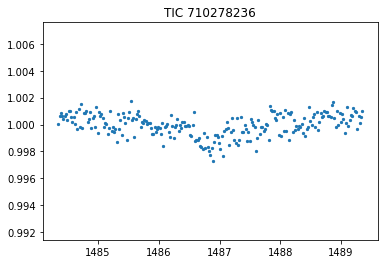

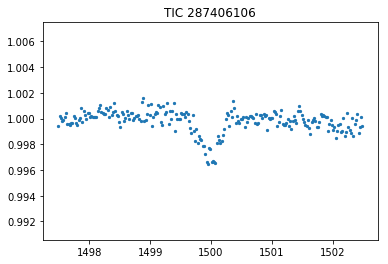

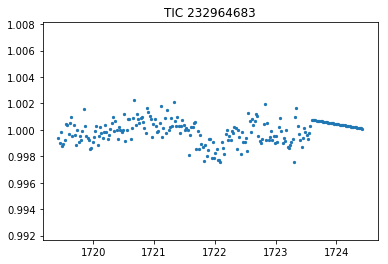

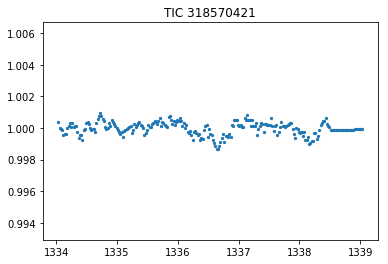

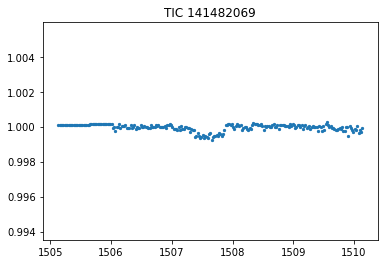

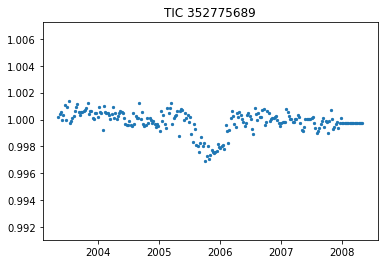

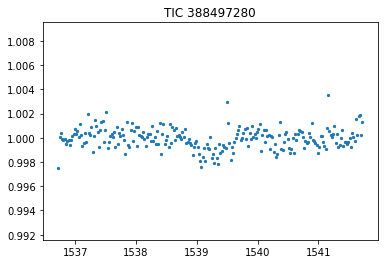

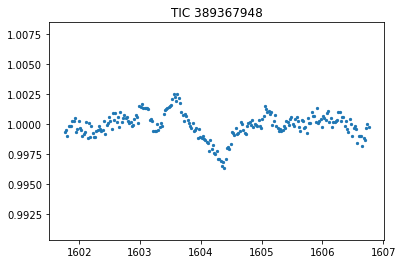

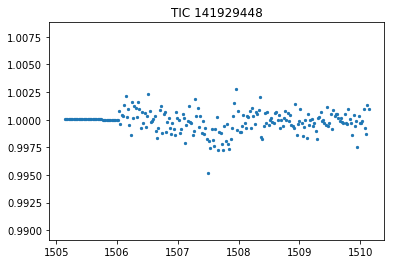

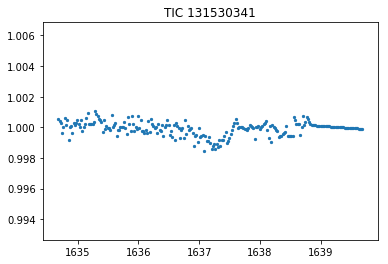

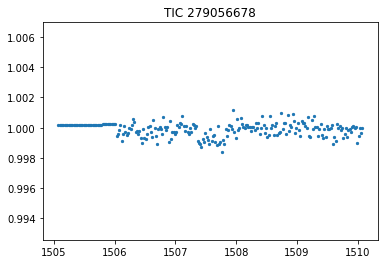

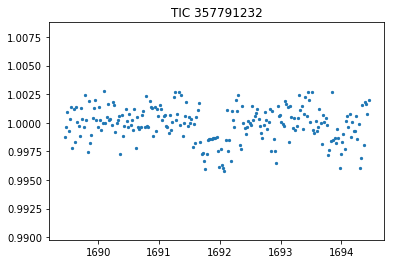

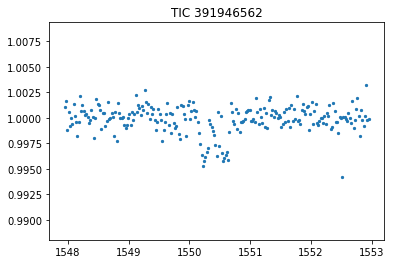

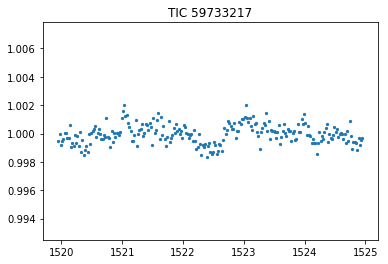

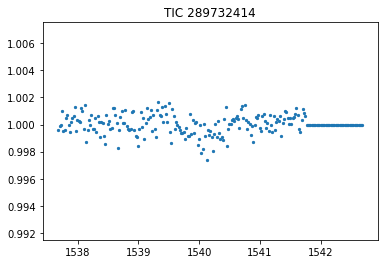

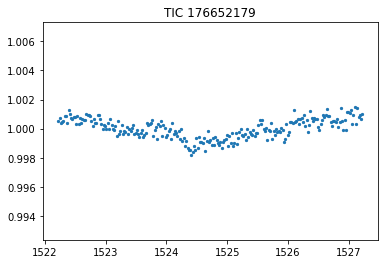

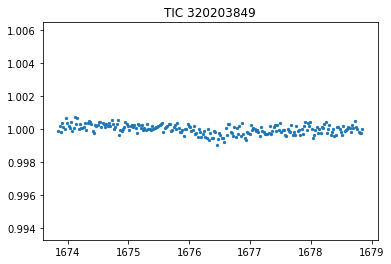

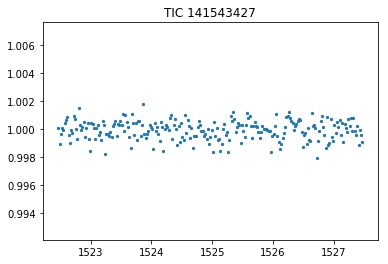

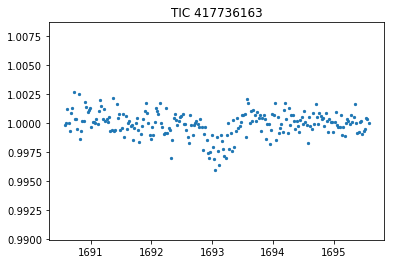

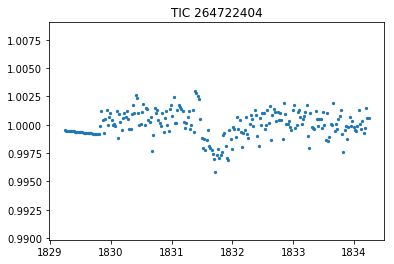

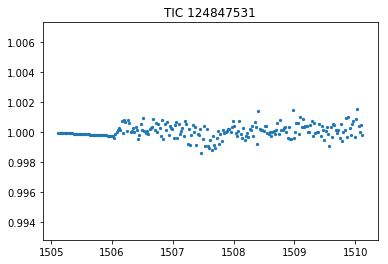

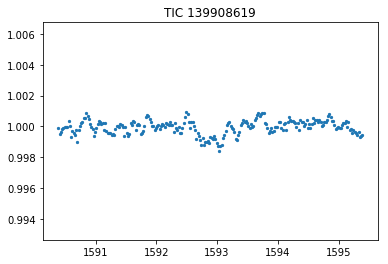

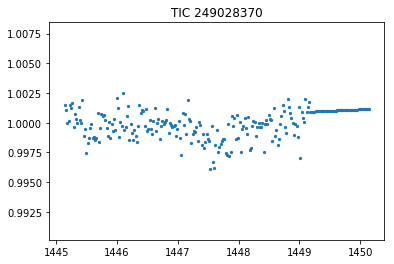

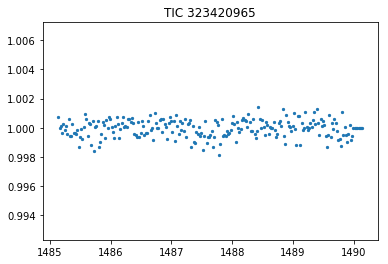

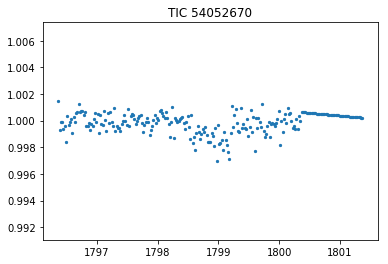

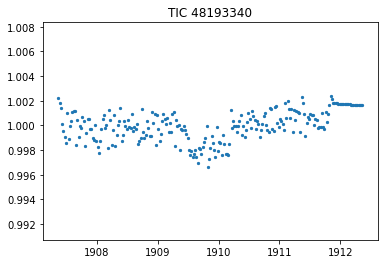

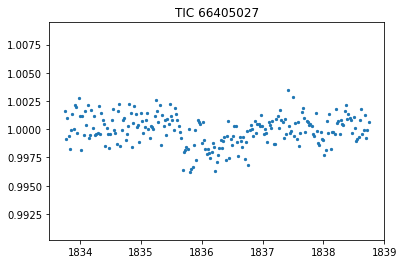

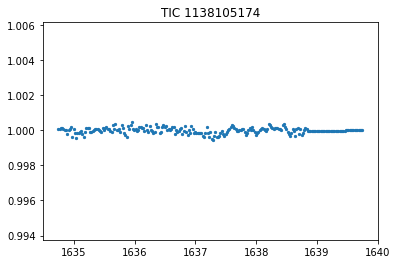

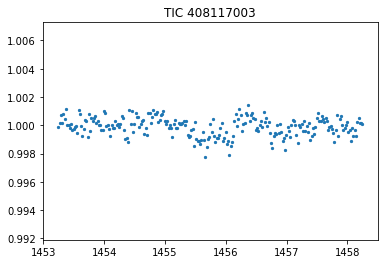

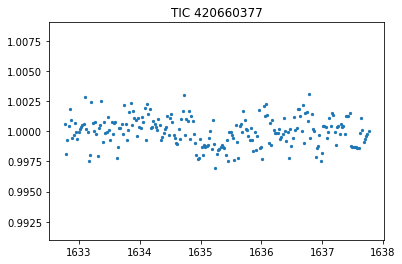

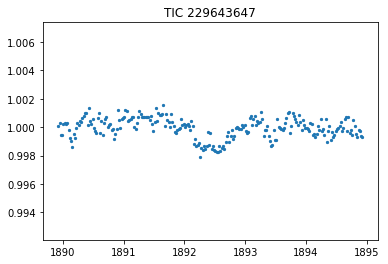

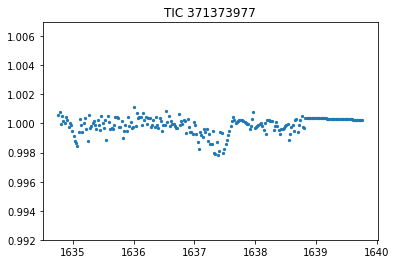

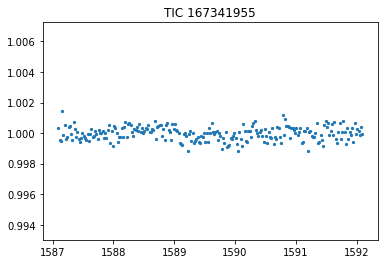

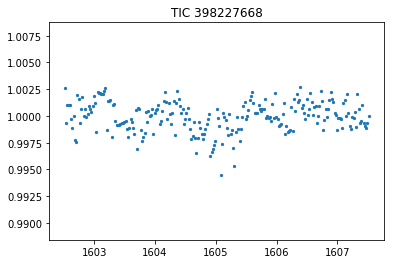

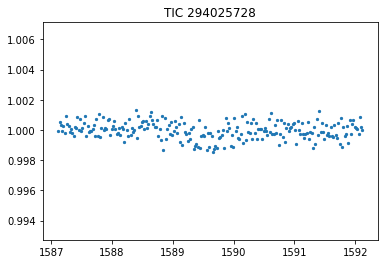

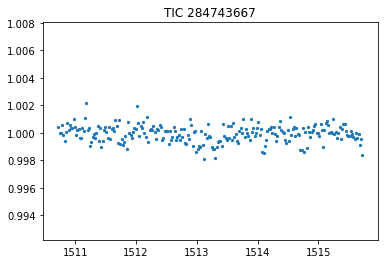

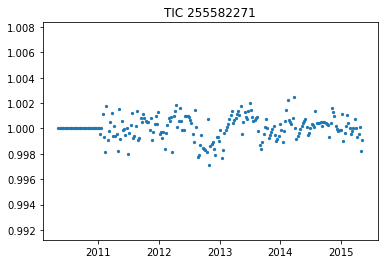

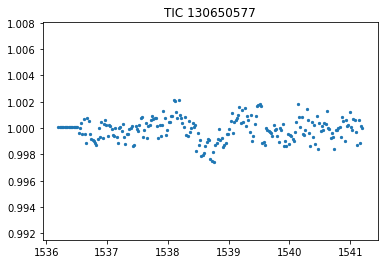

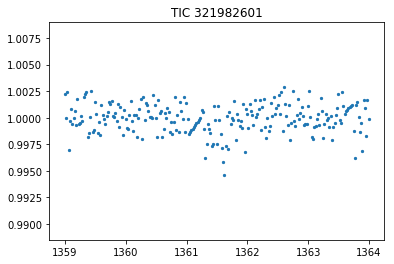

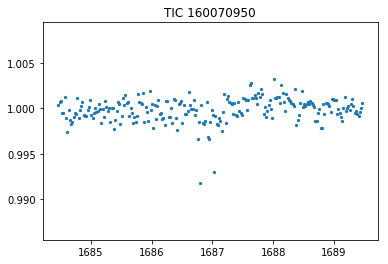

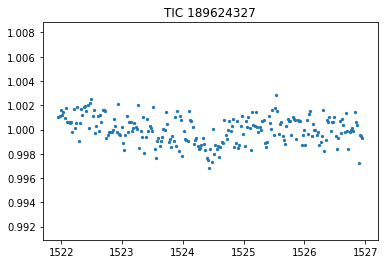

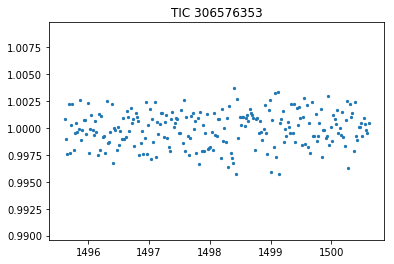

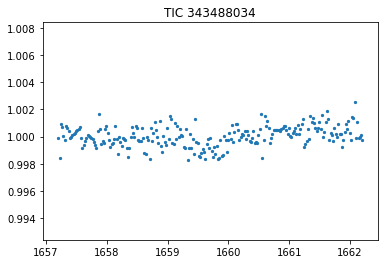

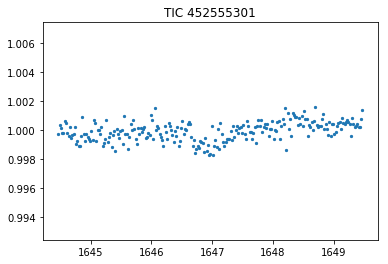

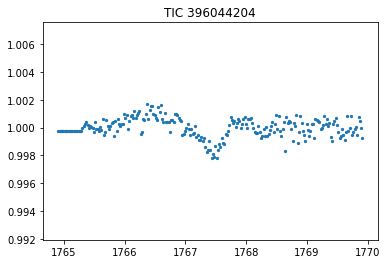

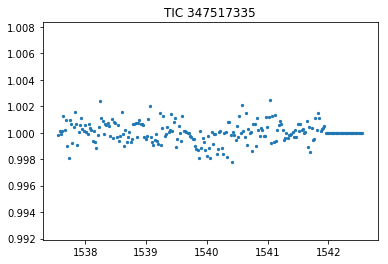

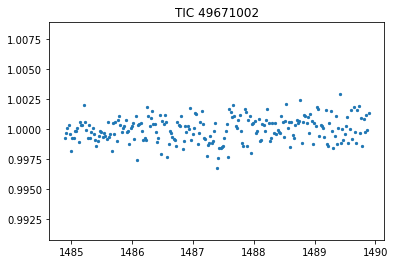

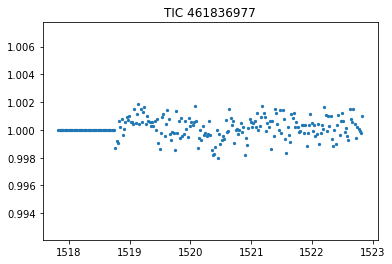

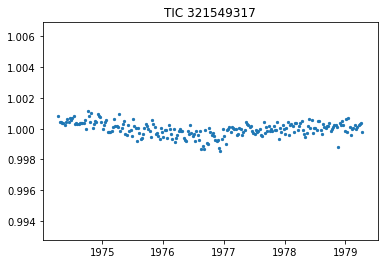

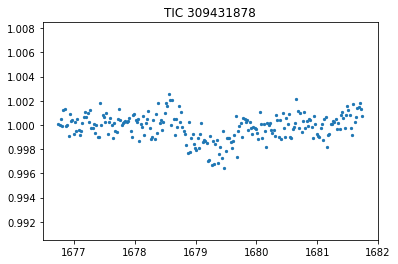

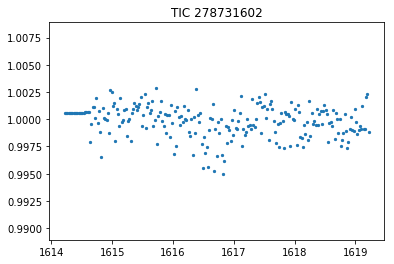

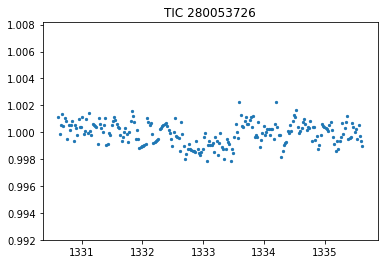

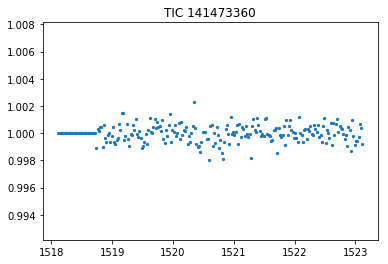

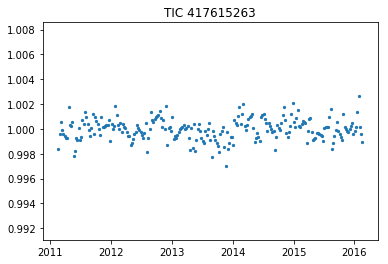

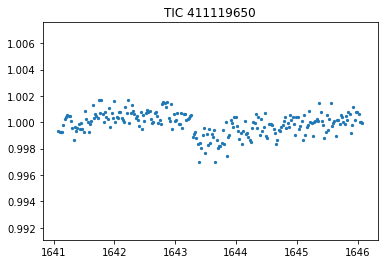

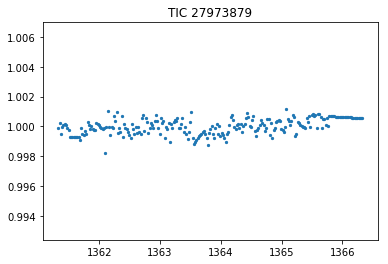

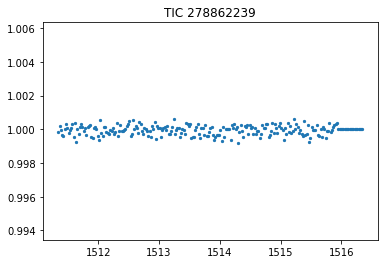

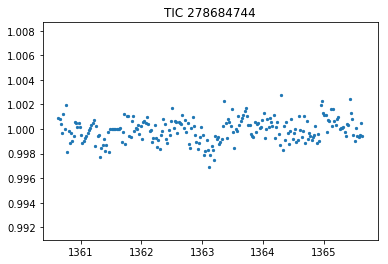

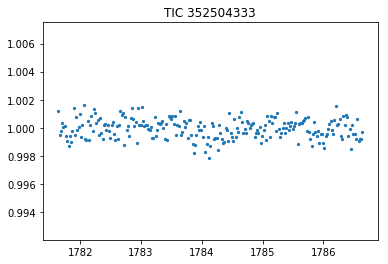

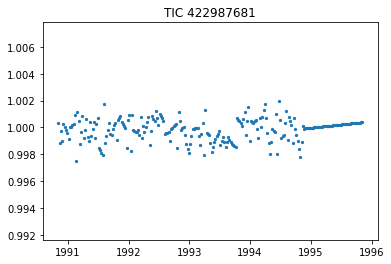

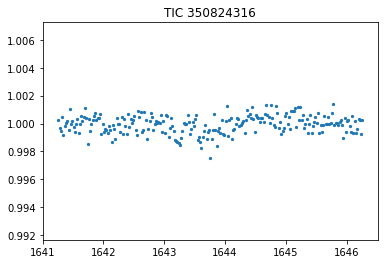

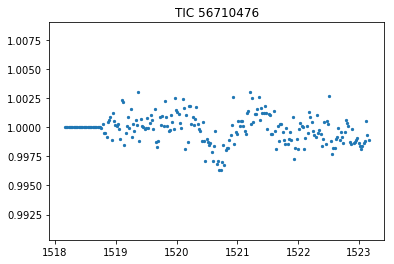

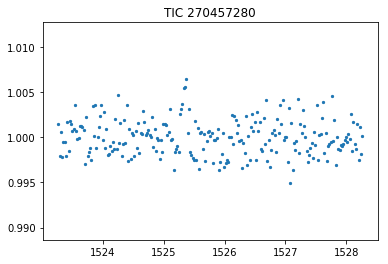

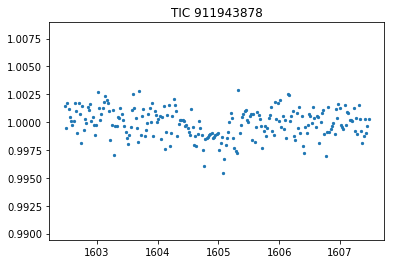

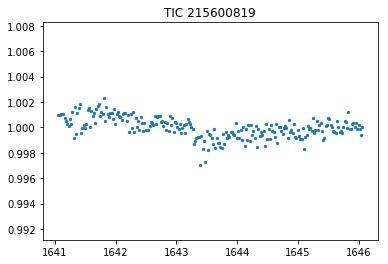

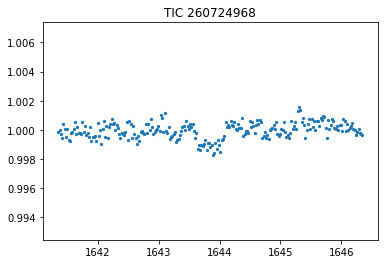

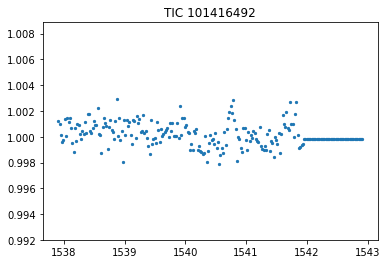

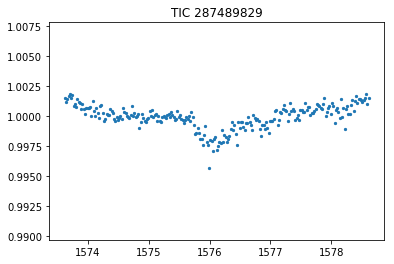

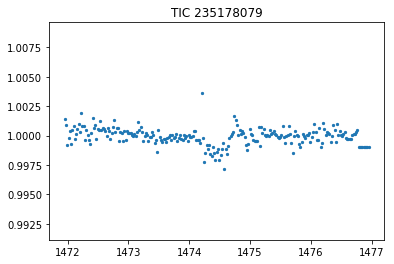

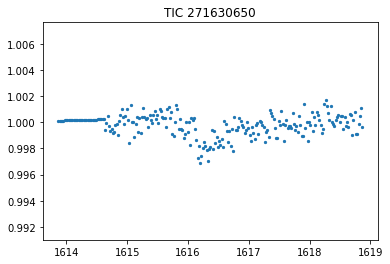

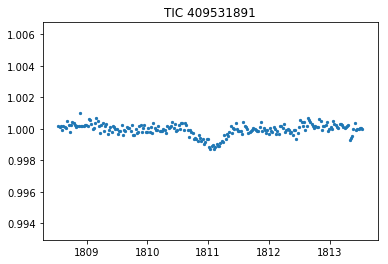

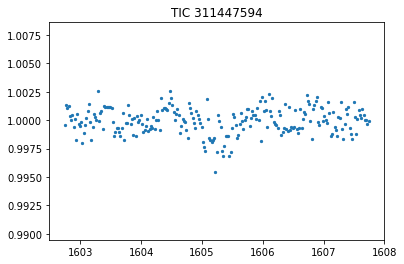

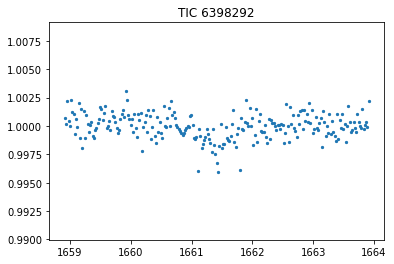

KeyboardInterrupt: 

In [16]:
def get_lightcurves(ids,mapped_tuples,pixel, directory):
    """
    This function retrieves lightcurves in the SOM pixels. 
    
    :ids: TIC IDs from `stack_npz_files`
    :mapped_tuples: Obtained from the SOM process, where this is the coordinates of the lightcurve
    :pixel: desired pixel to retrieve lightcurves
    :dir: Directory of where original `.npz` files are.
    
    outputs:
        lightcurve plots.
    
    pixel has to be in the form of (x,y) coordinates"""
    df = pd.DataFrame(data=[ids,mapped_tuples]).T
    df.columns = ['TIC','coords']
    lightcurves = df.groupby('coords').get_group(pixel).reset_index(drop=True)
    for i in lightcurves.TIC:
        #file_pattern = os.path.join(directory, '**', f'*{number_}*')
        lc = np.load("som_cutouts/{}.npz".format(i))
        plt.title("TIC {}".format(i))
        plt.scatter(lc['time'],lc['flux']/np.nanmedian(lc['flux']),s=5)
        plt.show()
    
get_lightcurves(ids,mapped_tuples,(2,0),'som_cutouts_s6/')

In [37]:
df = pd.DataFrame(data=[ids,mapped_tuples]).T
df.columns = ['TIC','coords']
test = df.groupby('coords').get_group((0,1)).reset_index(drop=True)

---

In [17]:
import pandas as pd

In [18]:
data = pd.read_csv('/storage/astro2/phrdhx/tesslcs/fulllookup.csv')

In [19]:
merged_df = df.merge(data[['Filename','Sector','TIC_ID']], left_on='TIC', right_on='TIC_ID', how='inner')


In [20]:
merged_df.to_csv('check.csv')